# Imports

In [3]:
%load_ext autoreload
%autoreload 2

print("Loading imports...")
from config import *

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data analysis
import glob
import os
import sys
from datetime import datetime, timedelta
import copy
import cftime
import xarray as xr
xr.set_options(keep_attrs=True)
import xrft
import numpy as np
import scipy
import scipy.signal as signal
from scipy.stats import t

# Plotting
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from cartopy import feature as cf
from cartopy import util as cutil
from matplotlib import colors as mcolors
from matplotlib import ticker as mticker
from matplotlib.gridspec import GridSpec

# Aquaplanet specific functions
from load_aquaplanet_data import *
from processing_functions import *
from plotting_functions import *

# General auxiliary functions
sys.path.insert(0, "/glade/u/home/sressel/thesis-work/python/")
import auxiliary_functions.mjo_mean_state_diagnostics as mjo
from auxiliary_functions.bmh_colors import bmh_colors
from auxiliary_functions.one_two_one_filter import one_two_one_filter
from auxiliary_functions.rounding_functions import round_out
from auxiliary_functions.tick_labeller import tick_labeller
from auxiliary_functions.standardize_data import standardize_data

print("Imports loaded")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading imports...
Imports loaded


# Specify parameters

In [12]:
# Set latitude bounds
LATITUDE_SOUTH = -30
LATITUDE_NORTH = 30
latitude_subset_bounds = slice(LATITUDE_SOUTH, LATITUDE_NORTH)

# Set central longitude
CENTRAL_LONGITUDE = 0

# Set longitude bounds
LONGITUDE_MIN = 0
LONGITUDE_MAX = 360

# Set time bounds
missing_days = [
    cftime.DatetimeNoLeap(7, 2, 5, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(7, 2, 6, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(7, 2, 7, 0, 0, 0, 0, has_year_zero=True),
]
missing_timesteps = [missing_days[0] + timedelta(hours=x) for x in range(0, 24*3, 3)]

START_TIME = cftime.DatetimeNoLeap(3, 1, 4, 0, 0, 0, 0, has_year_zero=True)
END_TIME = cftime.DatetimeNoLeap(13, 1, 3, 0, 0, 0, 0, has_year_zero=True)
first_half_subset_bounds = slice(START_TIME, missing_days[0] - timedelta(days=1))
second_half_subset_bounds = slice(missing_days[-1] + timedelta(days=1), END_TIME)

# Cut-off periods for intraseasonal filtering
INTRASEASONAL_LOWCUT = 100
INTRASEASONAL_HIGHCUT = 20
period_subset_bounds = slice(INTRASEASONAL_LOWCUT, INTRASEASONAL_HIGHCUT)

# Cut-off wavenumbers for MJO-filtering
LARGE_SCALE_CUTOFF = 1
SMALL_SCALE_CUTOFF = 3
wavenumber_bounds = slice(LARGE_SCALE_CUTOFF, SMALL_SCALE_CUTOFF)

# Column-integrated bounds
LOWER_LEVEL_PRESSURE = 950
UPPER_LEVEL_PRESSURE = 100
pressure_subset_bounds = slice(UPPER_LEVEL_PRESSURE, LOWER_LEVEL_PRESSURE)

# Load Data

## Budget variables

In [13]:
# data_directory = "/glade/derecho/scratch/sressel"
data_directory = r"/glade/campaign/univ/uwas0152/post_processed_data/"
# budget_to_load = 'MSE'
budget_to_load = 'moisture'
# budget_to_load = 'meridional_moisture_advection'
# data_source_to_load = '3-hourly_model-level'
# data_source_to_load = 'daily_pressure-level'
data_source_to_load = 'daily_model-level'

# processes_to_load = 'single decomposed advection term'
# processes_to_load = 'full budget with decomposed advection terms'
processes_to_load = 'full budget'

multi_experiment_budget_variables = {}
print("Loading budget variables...")
print(f"{'='*str_width}")
budget_data_location = f"{data_directory}/{budget_to_load}_budget_terms/{data_source_to_load}_data"
if budget_to_load == 'MSE':
    budget_variables_to_load = [
        'Moist Static Energy',
        'Moist Static Energy Tendency',
        'Zonal Advection',
        'Meridional Advection',
        'Vertical Advection',
        'Latent Heating',
        'Sensible Heating',
        'Longwave Heating',
        'Shortwave Heating',
        'Residual'
    ]

elif budget_to_load == 'moisture':
    if processes_to_load == 'full budget':
        budget_variables_to_load = [
            'Moisture',
            'Moisture Tendency',
            'Zonal Advection',
            'Meridional Advection',
            'Vertical Advection',
            'Evaporation',
            'Precipitation',
            'Residual'
        ]

    elif processes_to_load == 'single decomposed advection term':
        advection_type = 'Vertical Advection'
        budget_variables_to_load = [
            'Moisture',
            'Moisture Tendency',
            f'{advection_type}',
            f'{advection_type} Mean wind mean moisture',
            f'{advection_type} Mean wind MJO moisture',
            f'{advection_type} Mean wind residial moisture',
            f'{advection_type} MJO wind mean moisture',
            f'{advection_type} MJO wind MJO moisture',
            f'{advection_type} MJO wind residual moisture',
            f'{advection_type} Residual wind mean moisture',
            f'{advection_type} Residual wind MJO moisture',
            f'{advection_type} Residual wind residual moisture',
        ]

    elif processes_to_load == 'full budget with decomposed advection terms':
        budget_variables_to_load = [
            'Moisture',
            'Moisture Tendency',
            'Evaporation',
            'Precipitation',
            f'Zonal Advection Mean wind MJO moisture',
            f'Zonal Advection Residual wind residual moisture',
            f'Meridional Advection MJO wind mean moisture',
            f'Meridional Advection Residual wind residual moisture',
            f'Vertical Advection MJO wind mean moisture',
            'Residual'
        ]

for index, variable_name in enumerate(budget_variables_to_load):
    data = xr.open_dataset(f"{budget_data_location}/multi_experiment_{variable_name.lower().replace(' ', '_')}.nc")
    for variable_data in data.data_vars.values():
        print(f"{f'({index+1}/{len(budget_variables_to_load)}) {variable_name}...':<{str_width-1}}", end="")
        multi_experiment_budget_variables[variable_name] = variable_data
        print(rf"{'✔':>1}")

print(f"{'='*str_width}")
print("Finished")

Loading budget variables...
(1/8) Moisture...                      ✔
(2/8) Moisture Tendency...             ✔
(3/8) Zonal Advection...               ✔
(4/8) Meridional Advection...          ✔
(5/8) Vertical Advection...            ✔
(6/8) Evaporation...                   ✔
(7/8) Precipitation...                 ✔
(8/8) Residual...                      ✔
Finished


## Load/Define Reference Series

In [14]:
reference_variable = 'Precipitation'
# mjo_index_method = 'Huang24'
mjo_index_method = 'Modified AK12'

print(f"{f'Loading reference data':^{str_width}}")
print(f"Regression Method: {mjo_index_method}")
print(f"{'='*str_width}")

if mjo_index_method == 'Modified AK12':
    if not 'multi_experiment_variables_mjo_filtered' in locals():
        multi_experiment_variables_mjo_filtered = load_multi_experiment_processed_data(
            [reference_variable],
            'mjo_filtered'
        )
    else:
        multi_experiment_variables_mjo_filtered = load_multi_experiment_processed_data(
            [reference_variable],
            'mjo_filtered',
            multi_experiment_variables_mjo_filtered,
            False
        )

    time = multi_experiment_variables_mjo_filtered[reference_variable].time
    latitude = multi_experiment_variables_mjo_filtered[reference_variable].lat
    longitude = multi_experiment_variables_mjo_filtered[reference_variable].lon

    print(f"{'-'*str_width}")
    print(f"{f'Defining reference timeseries...':<{str_width-1}}", end="")
    reference_longitude = 180
    reference_latitude = 0

    reference_timeseries = multi_experiment_variables_mjo_filtered[reference_variable].sel(lat=reference_latitude, lon=reference_longitude, method='nearest')

    regression_info = {
        'regression_variable': f"MJO-filtered {reference_variable}",
        'mjo_index_method': 'Modified AK12',
        'reference_longitude': reference_longitude,
        'reference_latitude' : reference_latitude,
    }
    print(rf"{'✔':>1}")

elif mjo_index_method == 'AK12':
    if not 'multi_experiment_variables_mjo_filtered' in locals():
        multi_experiment_variables_mjo_filtered = load_multi_experiment_processed_data(
            [reference_variable],
            'mjo_filtered'
        )
    else:
        multi_experiment_variables_mjo_filtered = load_multi_experiment_processed_data(
            [reference_variable],
            'mjo_filtered',
            multi_experiment_variables_mjo_filtered,
            False
        )

    time = multi_experiment_variables_mjo_filtered[reference_variable].time
    latitude = multi_experiment_variables_mjo_filtered[reference_variable].lat
    longitude = multi_experiment_variables_mjo_filtered[reference_variable].lon

    print(f"{'-'*str_width}")
    print(f"{f'Defining reference timeseries...':<{str_width-1}}", end="")
    reference_longitude = 180
    reference_latitude = (
        multi_experiment_variables_mjo_filtered[reference_variable]
    ).var(dim='time').mean(dim='lon').idxmax(dim='lat')

    # Select the timeseries at the correct reference location for each experiment
    selected_timeseries = []
    for exp, lat in zip(multi_experiment_variables_mjo_filtered[reference_variable].experiment, reference_latitude):

        experiment_reference_timeseries = multi_experiment_variables_mjo_filtered[reference_variable].sel(
            experiment=exp, lat=lat, lon=reference_longitude
        )
        selected_timeseries.append(experiment_reference_timeseries)

    # Combine all timeseries into a single DataArray if needed
    reference_timeseries = xr.concat(selected_timeseries, dim="experiment")

    regression_info = {
        'regression_variable': f"MJO-filtered {reference_variable}",
        'mjo_index_method': 'AK12',
        'reference_longitude': reference_longitude,
        'reference_latitude_-4K': reference_latitude.sel(experiment='-4K').values,
        'reference_latitude_0K': reference_latitude.sel(experiment='0K').values,
        'reference_latitude_4K': reference_latitude.sel(experiment='4K').values
    }
    print(rf"{'✔':>1}")


elif mjo_index_method == 'Huang24':
    reference_region = dict(
        lat=slice(-5,5),
        lon=slice(175,185)
    )

    if not 'multi_experiment_variables_subset' in locals():
        multi_experiment_variables_subset = load_multi_experiment_processed_data(
            [reference_variable],
            'subset'
        )
    else:
        multi_experiment_variables_subset = load_multi_experiment_processed_data(
            [reference_variable],
            'subset',
            multi_experiment_variables_subset,
            False
        )
    print(f"{'-'*str_width}")
    print(f"{f'Defining reference timeseries...':<{str_width-1}}", end="")

    reference_region_data = multi_experiment_variables_subset[reference_variable].sel(reference_region).mean(dim=['lat', 'lon'])
    reference_timeseries = time_filter_data(
        reference_region_data,
        period_subset_bounds
    )
    regression_info = {
        'regression_variable': f"MJO-filtered {reference_variable}",
        'mjo_index_method': 'Huang24',
        'reference_longitude': f"{tick_labeller([reference_region['lon'].start], 'lon', False)[0]}-{tick_labeller([reference_region['lon'].stop], 'lon', False)[0]}",
        'reference_latitude': f"{tick_labeller([reference_region['lat'].start], 'lat', False)[0]}-{tick_labeller([reference_region['lat'].stop], 'lat', False)[0]}",
    }
    print(rf"{'✔':>1}")

elif mjo_index_method == 'Modified Huang24':
    reference_region = dict(
        lat=slice(-5,5),
        lon=slice(175,185)
    )

    if not 'multi_experiment_variables_mjo_filtered' in locals():
        multi_experiment_variables_mjo_filtered = load_multi_experiment_processed_data(
            [reference_variable],
            'mjo_filtered'
        )
    else:
        multi_experiment_variables_mjo_filtered = load_multi_experiment_processed_data(
            [reference_variable],
            'mjo_filtered',
            multi_experiment_variables_mjo_filtered,
            False
        )
    print(f"{'-'*str_width}")
    print(f"{f'Defining reference timeseries...':<{str_width-1}}", end="")

    reference_timeseries = multi_experiment_variables_mjo_filtered[reference_variable].sel(reference_region).mean(dim=['lat', 'lon'])
    regression_info = {
        'regression_variable': f"MJO-filtered {reference_variable}",
        'mjo_index_method': 'Modified Huang24',
        'reference_longitude': f"{tick_labeller([reference_region['lon'].start], 'lon', False)[0]}-{tick_labeller([reference_region['lon'].stop], 'lon', False)[0]}",
        'reference_latitude': f"{tick_labeller([reference_region['lat'].start], 'lat', False)[0]}-{tick_labeller([reference_region['lat'].stop], 'lat', False)[0]}",
    }
    print(rf"{'✔':>1}")

elif mjo_index_method == 'Rossby':
    reference_region = dict(
        lat=slice(-5,5),
        lon=slice(175,185)
    )

    if not 'multi_experiment_variables_rossby_filtered' in locals():
        multi_experiment_variables_rossby_filtered = load_multi_experiment_processed_data(
            [reference_variable],
            'rossby_filtered'
        )
    else:
        multi_experiment_variables_rossby_filtered = load_multi_experiment_processed_data(
            [reference_variable],
            'rossby_filtered',
            multi_experiment_variables_rossby_filtered,
            False
        )
    print(f"{'-'*str_width}")
    print(f"{f'Defining reference timeseries...':<{str_width-1}}", end="")

    reference_timeseries = multi_experiment_variables_rossby_filtered[reference_variable].sel(reference_region).mean(dim=['lat', 'lon'])
    regression_info = {
        'regression_variable': f"MJO-filtered {reference_variable}",
        'mjo_index_method': 'Modified Huang24',
        'reference_longitude': f"{tick_labeller([reference_region['lon'].start], 'lon', False)[0]}-{tick_labeller([reference_region['lon'].stop], 'lon', False)[0]}",
        'reference_latitude': f"{tick_labeller([reference_region['lat'].start], 'lat', False)[0]}-{tick_labeller([reference_region['lat'].stop], 'lat', False)[0]}",
    }
    print(rf"{'✔':>1}")

print(f"{'='*str_width}")
print("Finished")

         Loading reference data         
Regression Method: Modified AK12
       Loading mjo_filtered data        
(1/1) Precipitation...                  
----------------------------------------
Variable already loaded
----------------------------------------
Data Loaded
----------------------------------------
Defining reference timeseries...       ✔
Finished


# Process data

## Subset budget variables

In [15]:
print(f"{'Subset budget variables':^{str_width}}")
print(f"{'='*str_width}")

multi_experiment_budget_variables_subset = {}

for index, (variable_name, variable_data) in enumerate(multi_experiment_budget_variables.items()):
    print(f"{f'({index+1}/{len(multi_experiment_budget_variables)}) {variable_name}...':<{str_width-1}}", end="")

    multi_experiment_budget_variables_subset[variable_name] = variable_data.drop_sel(time=missing_timesteps, errors='ignore')
    print(rf"{'✔':>1}")

# multi_experiment_budget_variables_subset[reference_variable] = variable_data.drop_sel(time=missing_timesteps, errors='ignore')

print(f"{'='*str_width}")
print("Finished")

        Subset budget variables         
(1/8) Moisture...                      ✔
(2/8) Moisture Tendency...             ✔
(3/8) Zonal Advection...               ✔
(4/8) Meridional Advection...          ✔
(5/8) Vertical Advection...            ✔
(6/8) Evaporation...                   ✔
(7/8) Precipitation...                 ✔
(8/8) Residual...                      ✔
Finished


## Regress variables

### Filter by Zonal Wavenumber

In [6]:
# # Print a formatted title header centered within str_width
# print(f"{'Wavenumber Filter Data':^{str_width}}")
# print(f"{'='*str_width}")

# # Define the wavenumbers to retain in filtering
# zonal_wavenumbers_to_filter = [1, 2, 3, 4]

# # Initialize a dictionary to store the filtered results for each variable
# multi_experiment_variables_by_wavenumber = {}

# # Loop through a subset of variables, applying the filtering process to each
# for index, (variable_name, variable_data) in enumerate(multi_experiment_budget_variables_subset.items()):
#     # Print the progress of the current variable being processed
#     print(f"{f'({index+1}/{len(multi_experiment_budget_variables)}) {variable_name}...':<{str_width-1}}", end="")

#     # Perform FFT along the zonal dimension
#     variable_data_fft = xrft.fft(
#         variable_data,
#         dim=['lon'],
#     )

#     # Convert frequency units from cycles per degree to total wavenumber over 360 degrees
#     zonal_wavenumbers = variable_data_fft.freq_lon * 360

#     # Create filtered FFT versions that zero out all but the selected wavenumber
#     variable_data_fft_filtered = {
#         k: xr.where(np.abs(zonal_wavenumbers) != k, 0, variable_data_fft)
#         for k in zonal_wavenumbers_to_filter
#     }

#     # Dictionary to store the filtered spatial-domain variables for each zonal wavenumber
#     variable_data_filtered_by_wavenumber = {}

#     # Inverse FFT to return to spatial domain and clean up axes
#     for zonal_wavenumber in variable_data_fft_filtered.keys():
#         # Create a new DataArray with the same shape as the original
#         variable_data_filtered_by_wavenumber[zonal_wavenumber] = xr.zeros_like(variable_data)

#         # Fill it with the inverse FFT result of the filtered data
#         variable_data_filtered_by_wavenumber[zonal_wavenumber][:,:,:,:] = xrft.ifft(
#             variable_data_fft_filtered[zonal_wavenumber],
#             dim='freq_lon',
#         ).transpose('experiment', 'time', 'lat', 'lon').real.values  # Keep only real part

#         # Adjust longitude to 0–360° range and sort
#         variable_data_filtered_by_wavenumber[zonal_wavenumber]['lon'] = (variable_data_filtered_by_wavenumber[zonal_wavenumber].lon + 180) % 360
#         variable_data_filtered_by_wavenumber[zonal_wavenumber] = variable_data_filtered_by_wavenumber[zonal_wavenumber].sortby('lon')

#     # Create a new dimension for the concatenated data: original + filtered by wavenumber
#     zonal_wavenumbers = xr.DataArray(
#         data=[0] + zonal_wavenumbers_to_filter,
#         dims='zonal_wavenumber',
#         coords={'zonal_wavenumber': [0] + zonal_wavenumbers_to_filter}
#     )

#     # Concatenate the original variable with its filtered versions along the new dimension
#     multi_experiment_variables_by_wavenumber[variable_name] = xr.concat(
#         [variable_data] + [variable_data_filtered_by_wavenumber[zonal_wavenumber] for zonal_wavenumber in zonal_wavenumbers_to_filter],
#         dim=zonal_wavenumbers
#     )

#     # Assign name to the resulting DataArray
#     multi_experiment_variables_by_wavenumber[variable_name].name = variable_name

#     # Print success mark
#     print(rf"{'✔':>1}")

# # Print footer
# print(f"{'='*str_width}")
# print("Finished")

### Perform regression

In [16]:
save_regressed_variables = False
# reference_variable = 'Outgoing Longwave Radiation'

# Initialize output arrays
multi_experiment_budget_variables_regressed = {}
significant_regression_indices = {}

# Process reference timeseries
reference_timeseries = reference_timeseries.drop_sel(time=missing_days, errors='ignore')
standardized_reference_timeseries = standardize_data(reference_timeseries, unit_variance=True, dim='time')
N = len(standardized_reference_timeseries.time)
t_critical = t.ppf(0.95, df=N-2)

print(f"{'Regressions':^{str_width}}")
print(f"{f'Reference Variable: {reference_variable}':^{str_width}}")
print(f"{f'MJO-index Method: {mjo_index_method}':^{str_width}}")
print(f"{'='*str_width}")

# Regress each budget variable onto the MJO-reference time series
for index, (variable_name, variable_data) in enumerate(multi_experiment_budget_variables_subset.items()):
# for index, (variable_name, variable_data) in enumerate(multi_experiment_variables_by_wavenumber.items()):
    print(f'{f"({index+1}/{len(multi_experiment_budget_variables_subset)}) {variable_name}...":<{str_width-1}}', end="")

    # Remove the time mean of the variables to be regressed
    variable_data_anomalies = standardize_data(variable_data, unit_variance=False, dim='time')

    # Re-sample the 3-hourly data to daily if necessary
    if data_source_to_load == '3-hourly_model-level':
        print()
        print(f"{f'  Resampling 3-hourly day to daily...':<{str_width-1}}", end="")
        variable_data_anomalies = variable_data_anomalies.resample(time='D').mean().sel(
            time=slice(standardized_reference_timeseries.time[0], standardized_reference_timeseries.time[-1])
        ).drop_sel(time=missing_days, errors='ignore')

    # Regress the variable anomalies onto the reference timeseries
    multi_experiment_budget_variables_regressed[variable_name] = xr.dot(
        standardized_reference_timeseries,
        variable_data_anomalies,
        dim='time'
    ) / len(standardized_reference_timeseries.time)
    multi_experiment_budget_variables_regressed[variable_name].name = variable_name
    multi_experiment_budget_variables_regressed[variable_name].attrs = variable_data_anomalies.attrs
    multi_experiment_budget_variables_regressed[variable_name].attrs['Regression Method'] = mjo_index_method

    # Assign the regression-related attributes to the new xarray object
    for (key, value) in regression_info.items():
        multi_experiment_budget_variables_regressed[variable_name].attrs[key] = value

    # Calculate the statstical significance of the regression coefficients
    predicted_value = multi_experiment_budget_variables_regressed[variable_name] * standardized_reference_timeseries
    residual_sum_of_squares = ((variable_data_anomalies - predicted_value) ** 2).sum(dim='time')
    residual_variance = residual_sum_of_squares / (N - 2)
    standard_error_slope = np.sqrt(residual_variance / (N - 1))
    t_statistic = multi_experiment_budget_variables_regressed[variable_name] / standard_error_slope
    significant_regression_indices[variable_name] = np.abs(t_statistic) > t_critical
    print(rf"{'✔':>1}")

# reference_variable_regressed = xr.dot(
#     standardize_data(multi_experiment_variables_subset[reference_variable], unit_variance=False),
#     standardize_data(reference_timeseries, unit_variance=True),
#     dim='time'
# ) / len(reference_timeseries.time)

# print(f"{'-'*str_width}")

# Re-scale the regressed values to have a constant reference value
# if reference_variable == 'Outgoing Longwave Radiation':
#     print("Re-scaling regressed timeseries")

#     rescaling_factor = (
#         -40 / reference_variable_regressed.sel(lat=reference_latitude, lon=reference_longitude)
#     )
#     for index, (variable_name, variable_data) in enumerate(multi_experiment_budget_variables_regressed.items()):
#         print(f'{f"({index+1}/{len(multi_experiment_budget_variables_regressed)}) {variable_name}...":<{str_width-1}}', end="")
#         multi_experiment_budget_variables_regressed[variable_name][:] *= rescaling_factor.copy(deep=True)
#         multi_experiment_budget_variables_regressed[variable_name].attrs['rescaled'] = 'True'
#         print(rf"{'✔':>1}")

# elif reference_variable == 'Precipitation':
#     print("Re-scaling regressed timeseries")

#     if mjo_index_method == 'AK12':
#         rescaling_factor = (
#             15 / reference_variable_regressed.sel(lat=reference_latitude, lon=reference_longitude)
#         )
#     elif mjo_index_method == 'Modified AK12':
#         rescaling_factor = (
#             15 / multi_experiment_variables_regressed['Precipitation'].sel(experiment=experiment).sel(lat=0, lon=180, method='nearest')
#         )
#     elif mjo_index_method == 'Huang24':
#         rescaling_factor = (
#             15 / reference_variable_regressed.sel(lat=0, lon=180, method='nearest')
#     )

#     for index, (variable_name, variable_data) in enumerate(multi_experiment_budget_variables_regressed.items()):
#         print(f'{f"({index+1}/{len(multi_experiment_budget_variables_regressed)}) {variable_name}...":<{str_width-1}}', end="")
#         multi_experiment_budget_variables_regressed[variable_name][:] *= rescaling_factor.copy(deep=True)
#         multi_experiment_budget_variables_regressed[variable_name].attrs['rescaled'] = 'True'
#         print(rf"{'✔':>1}")

# # print(f"{'-'*str_width}")

# if save_regressed_variables:
#     print(f"{'Saving regressed variables':^{str_width}}")
#     print(f"{'='*str_width}")

#     for index, (variable_name, variable_data) in enumerate(multi_experiment_budget_variables_regressed.items()):
#         print(f"{f'({index+1}/{len(multi_experiment_budget_variables_regressed)}) {variable_name}...':<{str_width-1}}", end="")

#         filename = (
#             f"{data_directory}/multi_experiment_variables_regressed/"
#             + f"multi_experiment_{variable_data.attrs['file_id']}_"
#             + f"MJO-{multi_experiment_budget_variables_regressed[reference_variable].attrs['file_id']}.nc"
#         )
#         combined_data =  xr.Dataset(
#             {
#                 f"{variable_name} - Coefficients": multi_experiment_budget_variables_regressed[variable_name],
#                 f"{variable_name} - Significance": significant_regression_indices[variable_name]
#             }
#         )
#         if os.path.exists(filename):
#             # Prompt user for confirmation
#             response = input(f"\nFile '{filename}' already exists. Overwrite? (y/n): ").strip().lower()
#             if response == 'y':
#                 os.remove(filename)  # Delete the existing file

#                 # combined_data["name"] = variable_data.name
#                 combined_data.to_netcdf(filename)  # Save the new file
#                 print(rf"{'✔ (overwritten)':>1}")
#             else:
#                 print(rf"{'✘ (skipped)':>1}")
#         else:
#             combined_data.to_netcdf(filename)  # Save the new file
#             print(rf"{'✔':>1}")
# else:
#     print(f"{'Not saving regressed variables':<{str_width}}")

print(f"{'='*str_width}")
print("Finished")

              Regressions               
   Reference Variable: Precipitation    
    MJO-index Method: Modified AK12     
(1/8) Moisture...                      ✔
(2/8) Moisture Tendency...             ✔
(3/8) Zonal Advection...               ✔
(4/8) Meridional Advection...          ✔
(5/8) Vertical Advection...            ✔
(6/8) Evaporation...                   ✔
(7/8) Precipitation...                 ✔
(8/8) Residual...                      ✔
Finished


# Budget contributions

## Calculate budget contributions

In [17]:
print(f"{'Budget Contributions':^{str_width}}")
print(f"{'='*str_width}")

# latitude_integration_bounds = (-10,10)

# projection_variable = 'Moist Static Energy'
projection_variable = 'Moisture'
budget_maintenance_contribution = {}
budget_propagation_contribution = {}

latitude_integration_bounds = {}
latitude_integration_bounds['-4K'] = (-5, 5)
latitude_integration_bounds['0K'] = (-10, 10)
latitude_integration_bounds['4K'] = (-15, 15)

longitude_integration_bounds = {}
longitude_integration_bounds['-4K'] = (30, 260)
longitude_integration_bounds['0K'] = (30, 300)
longitude_integration_bounds['4K'] = (60, 300)

# longitude_integration_bounds['-4K'] = (0, 360)
# longitude_integration_bounds['0K'] = (0, 360)
# longitude_integration_bounds['4K'] = (0, 360)

for index, (budget_term, budget_data) in enumerate(multi_experiment_budget_variables_regressed.items()):
    print(f"{f'({index+1}/{len(multi_experiment_budget_variables_regressed)}) {budget_term}...':<{str_width-1}}", end="")

    maintenance_numerator = (
        multi_experiment_budget_variables_regressed[projection_variable]
        * budget_data
    )
    maintenance_denominator = (
        multi_experiment_budget_variables_regressed[projection_variable]**2
    )

    propagation_numerator = (
        multi_experiment_budget_variables_regressed[f"{projection_variable} Tendency"]
        * budget_data
    )
    propagation_denominator = (
        multi_experiment_budget_variables_regressed[f"{projection_variable} Tendency"]**2
    )

    experiment_budget_maintenance_contribution = []
    experiment_budget_propagation_contribution = []
    for index, experiment in enumerate(experiments_list):

        experiment_budget_maintenance_contribution.append(
            maintenance_numerator.sel(
                experiment=experiment
            ).sel(
                lat=slice(*latitude_integration_bounds[experiment])
            ).integrate('lat').sel(
                lon=slice(*longitude_integration_bounds[experiment])
            ).integrate('lon')
            / maintenance_denominator.sel(
                experiment=experiment
            ).sel(
                lat=slice(*latitude_integration_bounds[experiment])
            ).integrate('lat').sel(
                lon=slice(*longitude_integration_bounds[experiment])
            ).integrate('lon')
        )
        experiment_budget_propagation_contribution.append(
            propagation_numerator.sel(
                experiment=experiment
            ).sel(
                lat=slice(*latitude_integration_bounds[experiment])
            ).integrate('lat').sel(
                lon=slice(*longitude_integration_bounds[experiment])
            ).integrate('lon')
            / propagation_denominator.sel(
                experiment=experiment
            ).sel(
                lat=slice(*latitude_integration_bounds[experiment])
            ).integrate('lat').sel(
                lon=slice(*longitude_integration_bounds[experiment])
            ).integrate('lon')
        )

    budget_maintenance_contribution[budget_term] = xr.concat(
        experiment_budget_maintenance_contribution,
        dim=experiments_array
    )
    budget_maintenance_contribution[budget_term].attrs = budget_data.attrs

    budget_propagation_contribution[budget_term] = xr.concat(
        experiment_budget_propagation_contribution,
        dim=experiments_array
    )
    budget_propagation_contribution[budget_term].attrs = budget_data.attrs
    print(rf"{'✔':>1}")

print(f"{'='*str_width}")
print("Finished")

          Budget Contributions          
(1/8) Moisture...                      ✔
(2/8) Moisture Tendency...             ✔
(3/8) Zonal Advection...               ✔
(4/8) Meridional Advection...          ✔
(5/8) Vertical Advection...            ✔
(6/8) Evaporation...                   ✔
(7/8) Precipitation...                 ✔
(8/8) Residual...                      ✔
Finished


## Plot Budgets

### Specify plot design

In [18]:
calculate_horizontal_advection = True
if projection_variable == 'Moist Static Energy':
    if mjo_index_method == 'Huang24' or mjo_index_method == 'Modified Huang24' or mjo_index_method == 'Rossby':
        # Huang (2024) term order
        budget_term_attributes = {
            'Moist Static Energy Tendency': {
                'label': r"$\langle \partial_{t} h \rangle$",
                'color': plt.get_cmap('Blues'),
            },
            'Longwave Heating': {
                'label': r"$\langle$LW$\rangle$",
                'color': mcolors.LinearSegmentedColormap.from_list("Pinks", ["#ffd6e6", "#ffb3cc", "#ff80b3", "#ff3385", "#e60073"], N=256),
            },
            'Shortwave Heating': {
                'label': r"$\langle$SW$\rangle$",
                'color': mcolors.LinearSegmentedColormap.from_list("Golden",["#fff9cc", "#ffe999", "#ffcc66",  "#e6b347", "#c49e35"], N=256),
            },
            'Latent Heating': {
                'label': r'LH',
                'color': plt.get_cmap('Greens'),
            },
            'Sensible Heating': {
                'label': r'SH',
                'color': mcolors.LinearSegmentedColormap.from_list("Cyans", ["#e0ffff", "#80e0ff", "#00c0ff", "#0080ff", "#0040ff"], N=256),
            },
            'Horizontal Advection': {
                'label': r"-$\langle \vec{v}\cdot \nabla h \rangle$",
                'color': plt.get_cmap('Oranges'),
            },
            'Vertical Advection': {
                'label': r"-$\langle \omega \partial_{p} h \rangle$",
                'color': plt.get_cmap('Purples'),
            },
            'Residual': {
                'label': r"Res.",
                'color': plt.get_cmap('Greys'),
            },
        }
    elif mjo_index_method == 'AK12':
        # Anderson & Kuang term order
        budget_term_attributes = {
            'Moist Static Energy Tendency': {
                'label': r"$\langle \partial_{t} h \rangle$",
                'color': plt.get_cmap('Blues'),
            },
            'Longwave Heating': {
                'label': r"$\langle$LW$\rangle$",
                'color': mcolors.LinearSegmentedColormap.from_list("Pinks", ["#ffd6e6", "#ffb3cc", "#ff80b3", "#ff3385", "#e60073"], N=256),
            },
            'Column Process': {
            'label': r'-$\langle \omega \partial_{p} m \rangle$+$\langle$LW$\rangle$',
            'color': plt.get_cmap('Purples'),
            },
            'Horizontal Advection': {
                'label': r"-$\langle \vec{v}\cdot \nabla h \rangle$",
                'color': plt.get_cmap('Oranges'),
            },
            'Zonal Advection': {
                'label': r"-$\langle u \partial_{x} h \rangle$",
                'color': plt.get_cmap('Oranges'),
            },
            'Meridional Advection': {
            'label': r"-$\langle v \partial_{y} h \rangle$",
            'color': plt.get_cmap('Oranges'),
            },
            'Vertical Advection': {
                'label': r"-$\langle \omega \partial_{p} h \rangle$",
                'color': plt.get_cmap('Purples'),
            },
            'Latent Heating': {
                'label': r'LH',
                'color': plt.get_cmap('Greens'),
            },
            'Sensible Heating': {
                'label': r'SH',
                'color': mcolors.LinearSegmentedColormap.from_list("Cyans", ["#e0ffff", "#80e0ff", "#00c0ff", "#0080ff", "#0040ff"], N=256),
            },
            'Shortwave Heating': {
                'label': r"$\langle$SW$\rangle$",
                'color': mcolors.LinearSegmentedColormap.from_list("Golden",["#fff9cc", "#ffe999", "#ffcc66",  "#e6b347", "#c49e35"], N=256),
            },
            'Residual': {
                'label': r"Res.",
                'color': plt.get_cmap('Greys'),
            },
        }

elif projection_variable == 'Moisture':
    # Huang (2024) term order
    budget_term_attributes = {
        'Moisture Tendency': {
            'label': r"$\langle \partial_{t} q \rangle$",
            'color': plt.get_cmap('Blues'),
        },
        'Evaporation': {
            'label': r'E',
            'color': plt.get_cmap('Greens'),
        },
        'Precipitation': {
            'label': r'-P',
            'color': mcolors.LinearSegmentedColormap.from_list("Cyans", ["#e0ffff", "#80e0ff", "#00c0ff", "#0080ff", "#0040ff"], N=256),
        },
        'Precipitation + Vertical Advection': {
            'label': r"-(P + $\langle \omega \partial_{p} q \rangle$)",
            'color': plt.get_cmap('Purples'),
        },
        'Precipitation + Vertical Advection + Residual': {
            # 'label': r"-(P + $\langle \omega \partial_{p} q \rangle$) + Res.",
            'label': r"-P - $\langle \omega \partial_{p} q \rangle$ + Res.",
            'color': plt.get_cmap('Purples'),
        },
        'Column Process': {
            # 'label': r'-$\langle \omega \partial_{p} q \rangle$-P + Res.',
            'label': r'Col. Process',
            'color': plt.get_cmap('Purples'),
        },
        'Horizontal Advection': {
            'label': r"-$\langle \vec{v}\cdot \nabla q \rangle$",
            'color': plt.get_cmap('Oranges'),
        },
        'Zonal Advection': {
            'label': r'-$\langle u \partial_{x} q \rangle$',
            'color': mcolors.LinearSegmentedColormap.from_list("HighContrastPinks", ["#fff0f5", "#ffb3cc", "#ff80b3", "#ff3385", "#cc005f"], N=256)
        },
        'Meridional Advection': {
            'label': r'-$\langle v \partial_{y} q \rangle$',
            'color': mcolors.LinearSegmentedColormap.from_list("Golden",["#fff9cc", "#ffe999", "#ffcc66",  "#e6b347", "#c49e35"], N=256),
        },
        'Vertical Advection': {
            'label': r"-$\langle \omega \partial_{p} q \rangle$",
            'color': plt.get_cmap('Purples'),
        },
        'Residual': {
            'label': r"Res.",
            'color': plt.get_cmap('Greys'),
        },
    }

    print(f"{f'Column Process...':<{str_width-1}}", end="")
    budget_maintenance_contribution['Column Process'] = (
        budget_maintenance_contribution['Vertical Advection']
        + budget_maintenance_contribution['Evaporation']
        + budget_maintenance_contribution['Precipitation']
        + budget_maintenance_contribution['Residual']
    )
    budget_propagation_contribution['Column Process'] = (
        budget_propagation_contribution['Vertical Advection']
        + budget_propagation_contribution['Evaporation']
        + budget_propagation_contribution['Precipitation']
        + budget_propagation_contribution['Residual']
    )

    budget_maintenance_contribution['Precipitation + Vertical Advection'] = (
        budget_maintenance_contribution['Vertical Advection']
        + budget_maintenance_contribution['Precipitation']
    )
    budget_propagation_contribution['Precipitation + Vertical Advection'] = (
        budget_propagation_contribution['Vertical Advection']
        + budget_propagation_contribution['Precipitation']
    )
    budget_maintenance_contribution['Precipitation + Vertical Advection + Residual'] = (
        budget_maintenance_contribution['Vertical Advection']
        + budget_maintenance_contribution['Precipitation']
        + budget_maintenance_contribution['Residual']
    )
    budget_propagation_contribution['Precipitation + Vertical Advection + Residual'] = (
        budget_propagation_contribution['Vertical Advection']
        + budget_propagation_contribution['Precipitation']
        + budget_propagation_contribution['Residual']
    )
    print(rf"{'✔':>1}")

    if calculate_horizontal_advection:
        print(f"{f'Horizontal Advection...':<{str_width-1}}", end="")
        budget_maintenance_contribution['Horizontal Advection'] = (
            budget_maintenance_contribution['Zonal Advection']
            + budget_maintenance_contribution['Meridional Advection']
        )
        budget_propagation_contribution['Horizontal Advection'] = (
            budget_propagation_contribution['Zonal Advection']
            + budget_propagation_contribution['Meridional Advection']
        )
        print(rf"{'✔':>1}")

Column Process...                      ✔
Horizontal Advection...                ✔


### Maintenance

#### By Experiment

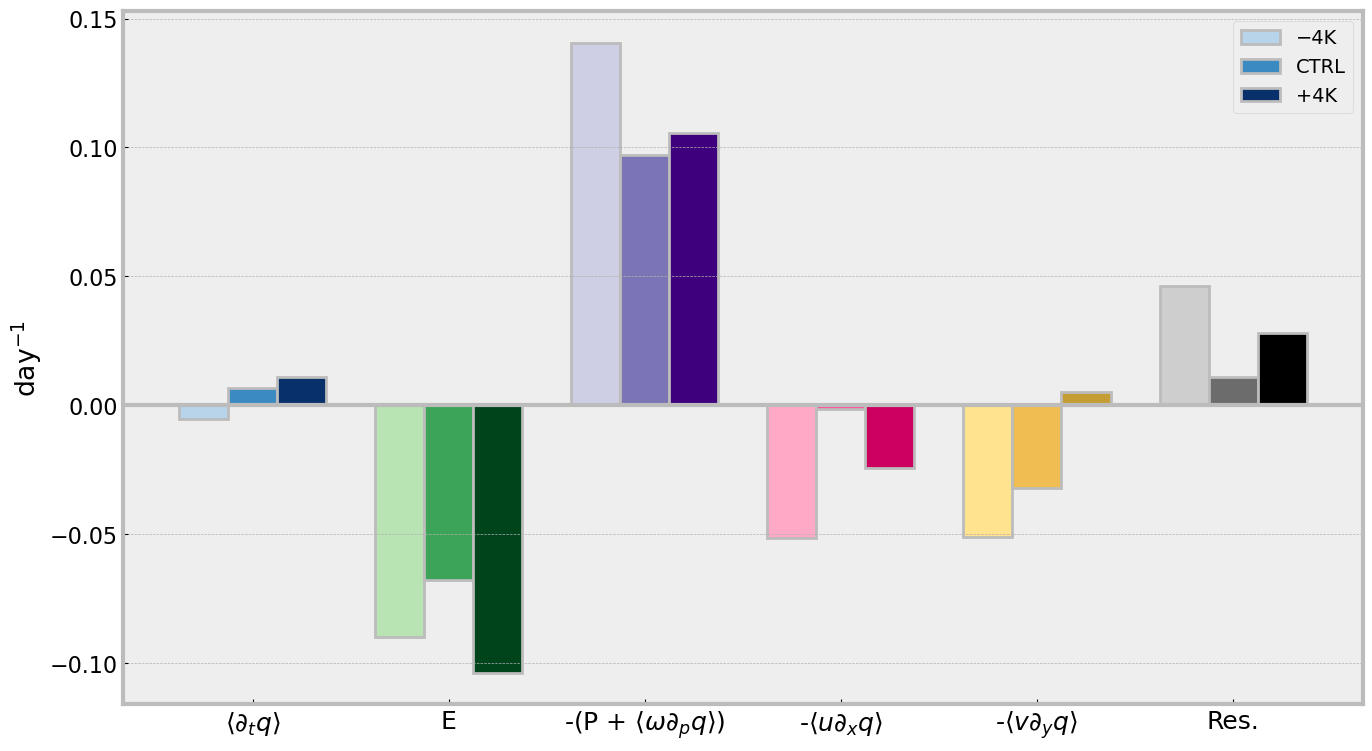

In [20]:
# projected_variable = "Moist Static Energy"

processes_to_plot = [
    'Moisture Tendency',
    'Evaporation',
    'Precipitation + Vertical Advection',
    'Zonal Advection',
    'Meridional Advection',
    # 'Vertical Advection',
    # 'Precipitation',
    # 'Column Process',
    'Residual',
]

plt.style.use('bmh')
plt.rcParams.update({'font.size': 16, 'mathtext.fontset': 'dejavusans'})

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
# ax.set_title(
#     (
#         f"{projection_variable} Budget Maintenance Contributions "
#     + f"\n Ressel Code, {budget_maintenance_contribution[projection_variable].attrs['Regression Method']} Regression Method"
#     ),
#     pad=15
# )

bar_width = 0.25
x_positions = np.arange(len(processes_to_plot))

# Plot bars for each experiment
for i, experiment in enumerate(experiments_list):
    ax.bar(
        x_positions + i * bar_width,
        [SECONDS_PER_DAY*budget_maintenance_contribution[process].sel(experiment=experiment).values for process in processes_to_plot],
        width=bar_width,
        label=experiments_array.sel(experiment=experiment)['name'].item(),
        color=[budget_term_attributes[process]['color'](0.3 + 0.35 * i) for process in processes_to_plot],
        edgecolor='#bcbcbc',
        lw=2,
    )

ax.set_ylabel(r'day$^{-1}$')
ax.set_xticks(x_positions + bar_width, labels=[budget_term_attributes[process]['label'] for process in processes_to_plot], fontsize=18)
ax.axhline(y=0, color='#bcbcbc', lw=3)
ax.grid(axis='x')

for spine in ax.spines.values():
    spine.set_edgecolor("#bcbcbc")
    spine.set_linewidth(3)

# Add legend to distinguish experiments
ax.legend(fontsize=14)

plt.show()


#### By Zonal Wavenumber

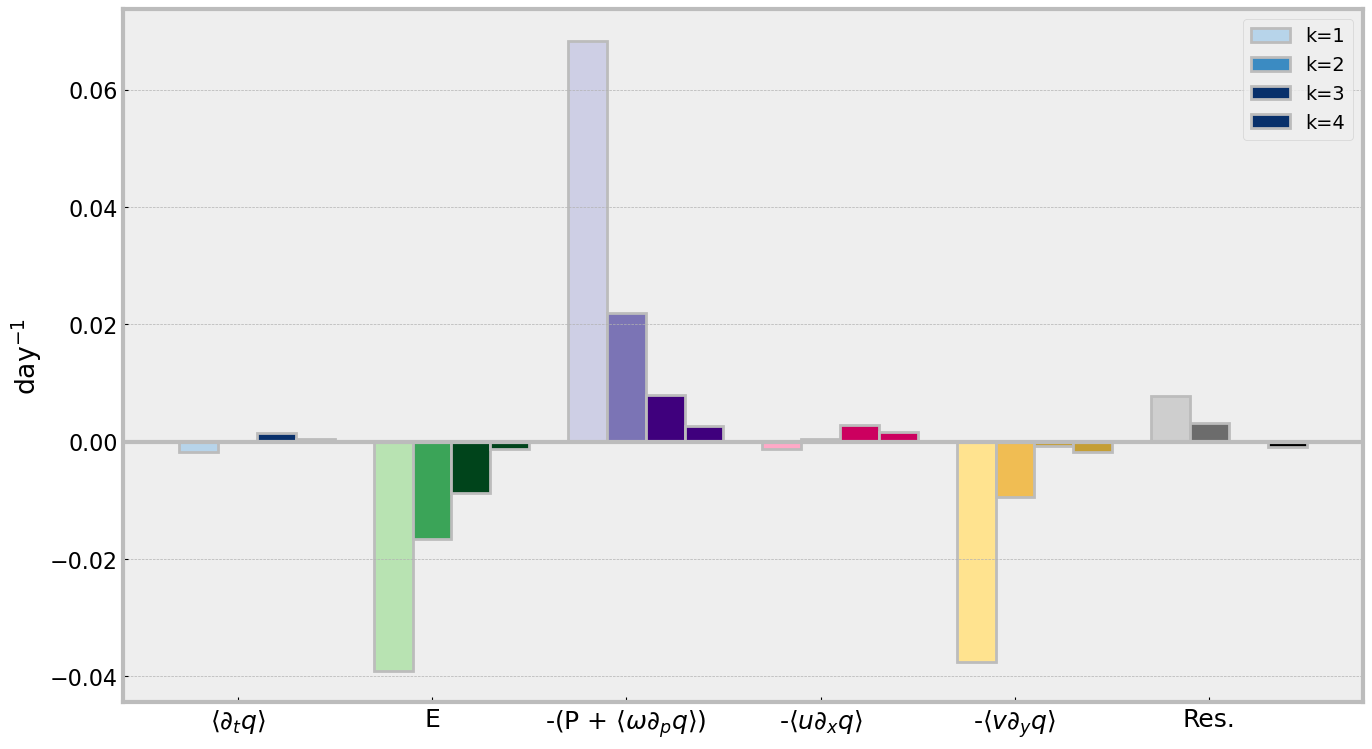

In [17]:
# projected_variable = "Moist Static Energy"

processes_to_plot = [
    'Moisture Tendency',
    'Evaporation',
    'Precipitation + Vertical Advection',
    'Zonal Advection',
    'Meridional Advection',
    # 'Vertical Advection',
    # 'Column Process',
    'Residual',
]

plt.style.use('bmh')
plt.rcParams.update({'font.size': 16, 'mathtext.fontset': 'dejavusans'})

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
# ax.set_title(
#     (
#         f"{projection_variable} Budget Maintenance Contributions "
#     + f"\n Ressel Code, {budget_maintenance_contribution[projection_variable].attrs['Regression Method']} Regression Method"
#     ),
#     pad=15
# )

bar_width = 0.2
x_positions = np.arange(len(processes_to_plot))

# Plot bars for each experiment
for i, wavenumber in enumerate(zonal_wavenumbers_to_filter):
    ax.bar(
        x_positions + i * bar_width,
        [SECONDS_PER_DAY*budget_maintenance_contribution[process].sel(experiment='0K', zonal_wavenumber=wavenumber).values for process in processes_to_plot],
        width=bar_width,
        label=f"k={wavenumber}",
        color=[budget_term_attributes[process]['color'](0.3 + 0.35 * i) for process in processes_to_plot],
        edgecolor='#bcbcbc',
        lw=2,
    )

ax.set_ylabel(r'day$^{-1}$')
ax.set_xticks(x_positions + bar_width, labels=[budget_term_attributes[process]['label'] for process in processes_to_plot], fontsize=18)
ax.axhline(y=0, color='#bcbcbc', lw=3)
ax.grid(axis='x')

for spine in ax.spines.values():
    spine.set_edgecolor("#bcbcbc")
    spine.set_linewidth(3)

# Add legend to distinguish experiments
ax.legend(fontsize=14)

plt.show()

### Propagation

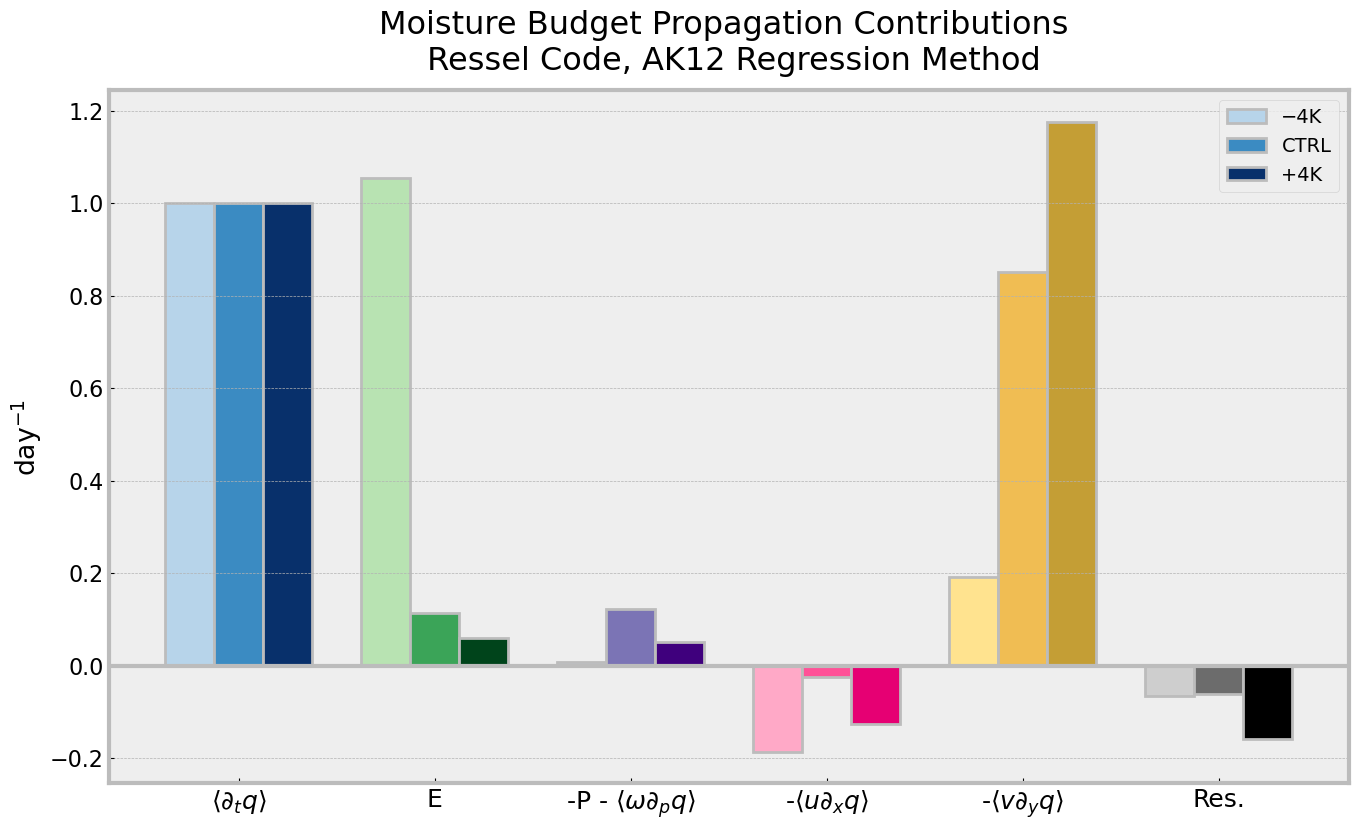

In [39]:
# projected_variable = "Moist Static Energy"

processes_to_plot = [
    'Moisture Tendency',
    'Evaporation',
    'Precipitation + Vertical Advection',
    'Zonal Advection',
    'Meridional Advection',
    # 'Vertical Advection',
    # 'Column Process',
    'Residual',
]

plt.style.use('bmh')
plt.rcParams.update({'font.size': 16, 'mathtext.fontset': 'dejavusans'})

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.set_title(
    (
        f"{projection_variable} Budget Propagation Contributions "
    + f"\n Ressel Code, {budget_propagation_contribution[projection_variable].attrs['Regression Method']} Regression Method"
    ),
    pad=15
)

bar_width = 0.25
x_positions = np.arange(len(processes_to_plot))

# Plot bars for each experiment
for i, experiment in enumerate(experiments_list):
    ax.bar(
        x_positions + i * bar_width,
        [budget_propagation_contribution[process].sel(experiment=experiment).values for process in processes_to_plot],
        width=bar_width,
        label=experiments_array.sel(experiment=experiment)['name'].item(),
        color=[budget_term_attributes[process]['color'](0.3 + 0.35 * i) for process in processes_to_plot],
        edgecolor='#bcbcbc',
        lw=2,
    )

# ax.set_ylabel(r'day$^{-1}$')
ax.set_xticks(x_positions + bar_width, labels=[budget_term_attributes[process]['label'] for process in processes_to_plot], fontsize=18)
ax.axhline(y=0, color='#bcbcbc', lw=3)
ax.grid(axis='x')

for spine in ax.spines.values():
    spine.set_edgecolor("#bcbcbc")
    spine.set_linewidth(3)

# Add legend to distinguish experiments
ax.legend(fontsize=14)

plt.show()

### Combined Maintenance-Propagation

#### By Experiment

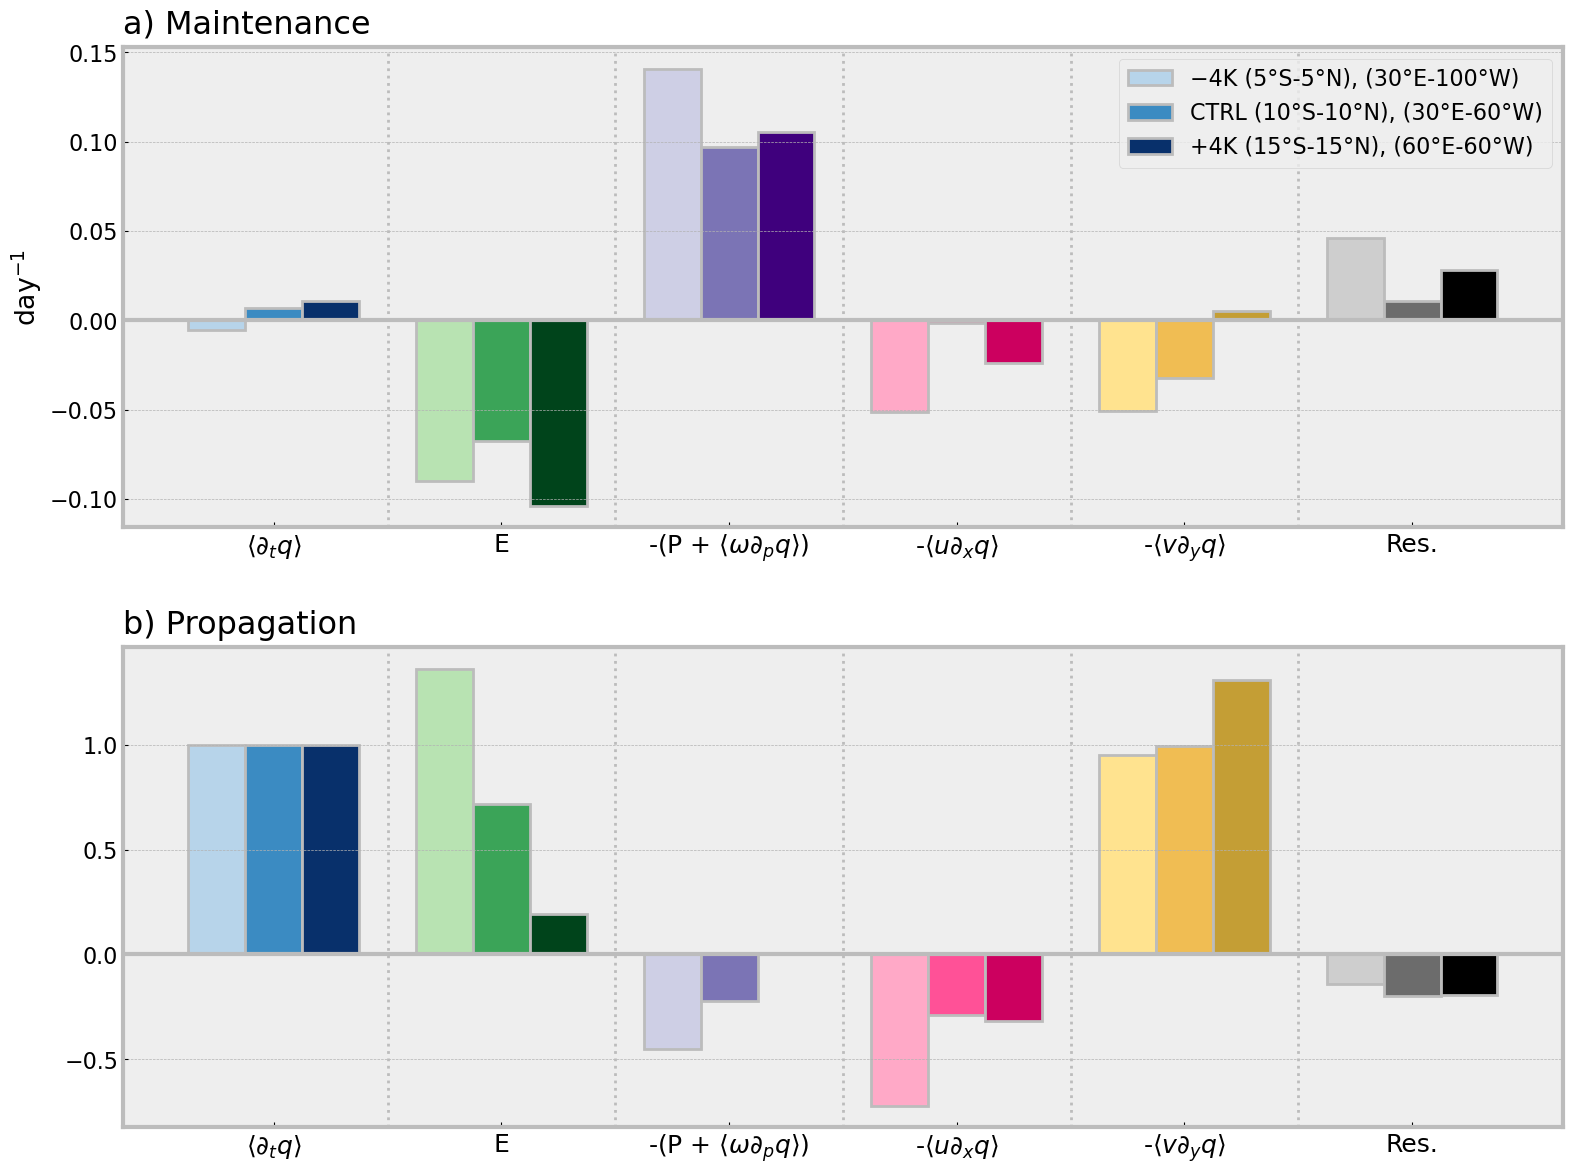

In [23]:
# projected_variable = "Moist Static Energy"

processes_to_plot = [
    'Moisture Tendency',
    'Evaporation',
    # 'Precipitation + Vertical Advection + Residual',
    'Precipitation + Vertical Advection',
    'Zonal Advection',
    'Meridional Advection',
    # 'Precipitation',
    # 'Column Process',
    'Residual',
]

plt.style.use('bmh')
plt.rcParams.update({'font.size': 16, 'mathtext.fontset': 'dejavusans'})

fig = plt.figure(figsize=(16, 12))
gs = GridSpec(2, 1, figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.25)

ax = []
ax.append(fig.add_subplot(gs[0]))
ax.append(fig.add_subplot(gs[1]))
# fig, ax = plt.subplots(2, 1, figsize=(16, 9))
# ax.set_title(
#     (
#         f"{projection_variable} Budget Maintenance Contributions "
#     + f"\n Ressel Code, {budget_maintenance_contribution[projection_variable].attrs['Regression Method']} Regression Method"
#     ),
#     pad=15
# )

bar_width = 0.25
x_positions = np.arange(len(processes_to_plot))

ax[0].set_title('a) Maintenance', pad=10, loc='left')
ax[1].set_title('b) Propagation', pad=10, loc='left')

# Plot bars for each experiment
for i, experiment in enumerate(experiments_list):
    plot_label = (
        f"{experiments_array.sel(experiment=experiment)['name'].item()}"
        + f" ({tick_labeller(latitude_integration_bounds[experiment], 'lat', precision=0)[0]}"
        + f"-{tick_labeller(latitude_integration_bounds[experiment], 'lat', precision=0)[1]}),"
        + f" ({tick_labeller(longitude_integration_bounds[experiment], 'lon', precision=0)[0]}"
        + f"-{tick_labeller(longitude_integration_bounds[experiment], 'lon', precision=0)[1]})"
    )
    ax[0].bar(
        x_positions + i * bar_width,
        [SECONDS_PER_DAY*budget_maintenance_contribution[process].sel(experiment=experiment).values for process in processes_to_plot],
        width=bar_width,
        label=plot_label,
        color=[budget_term_attributes[process]['color'](0.3 + 0.35 * i) for process in processes_to_plot],
        edgecolor='#bcbcbc',
        lw=2,
    )

    ax[1].bar(
        x_positions + i * bar_width,
        [budget_propagation_contribution[process].sel(experiment=experiment).values for process in processes_to_plot],
        width=bar_width,
        label=plot_label,
        color=[budget_term_attributes[process]['color'](0.3 + 0.35 * i) for process in processes_to_plot],
        edgecolor='#bcbcbc',
        lw=2,
    )

ax[0].set_ylabel(r'day$^{-1}$')
# ax[0].set_ylim(-0.15, 0.15)
# Add legend to distinguish experiments
ax[0].legend(fontsize=16)

# ax[1].set_ylim(-0.25, 1.25)
# ax[1].set_yticks(np.arange(-0.25, 1.5, 0.25))

for ax in ax:
    ax.set_xticks(x_positions + bar_width, labels=[budget_term_attributes[process]['label'] for process in processes_to_plot], fontsize=18)
    ax.axhline(y=0, color='#bcbcbc', lw=3)
    ax.grid(axis='x')
    [ax.axvline(x=(position + 3*bar_width), ls=':', color='#bcbcbc') for position in x_positions[:-1]]

    for spine in ax.spines.values():
        spine.set_edgecolor("#bcbcbc")
        spine.set_linewidth(3)

# Save figure
output_filename = f"{projection_variable.lower().replace(" ", "_")}_budget_maintenance_propagation"
print(f"Output directory: {aquaplanet_output_directory}")
print(f"Output filename: {output_filename}/budget_analysis")
if savefig:
    print(f"{f'Saving...':<{str_width-1}}", end="")
    plt.savefig(
        f"{aquaplanet_output_directory}/budget_analysis/{output_filename}.png",
        dpi=500,
        bbox_inches="tight",
    )
    print(rf"{'✔':>1}")
else:
    print("Not Saving")
    plt.show()

#### By Zonal Wavenumber

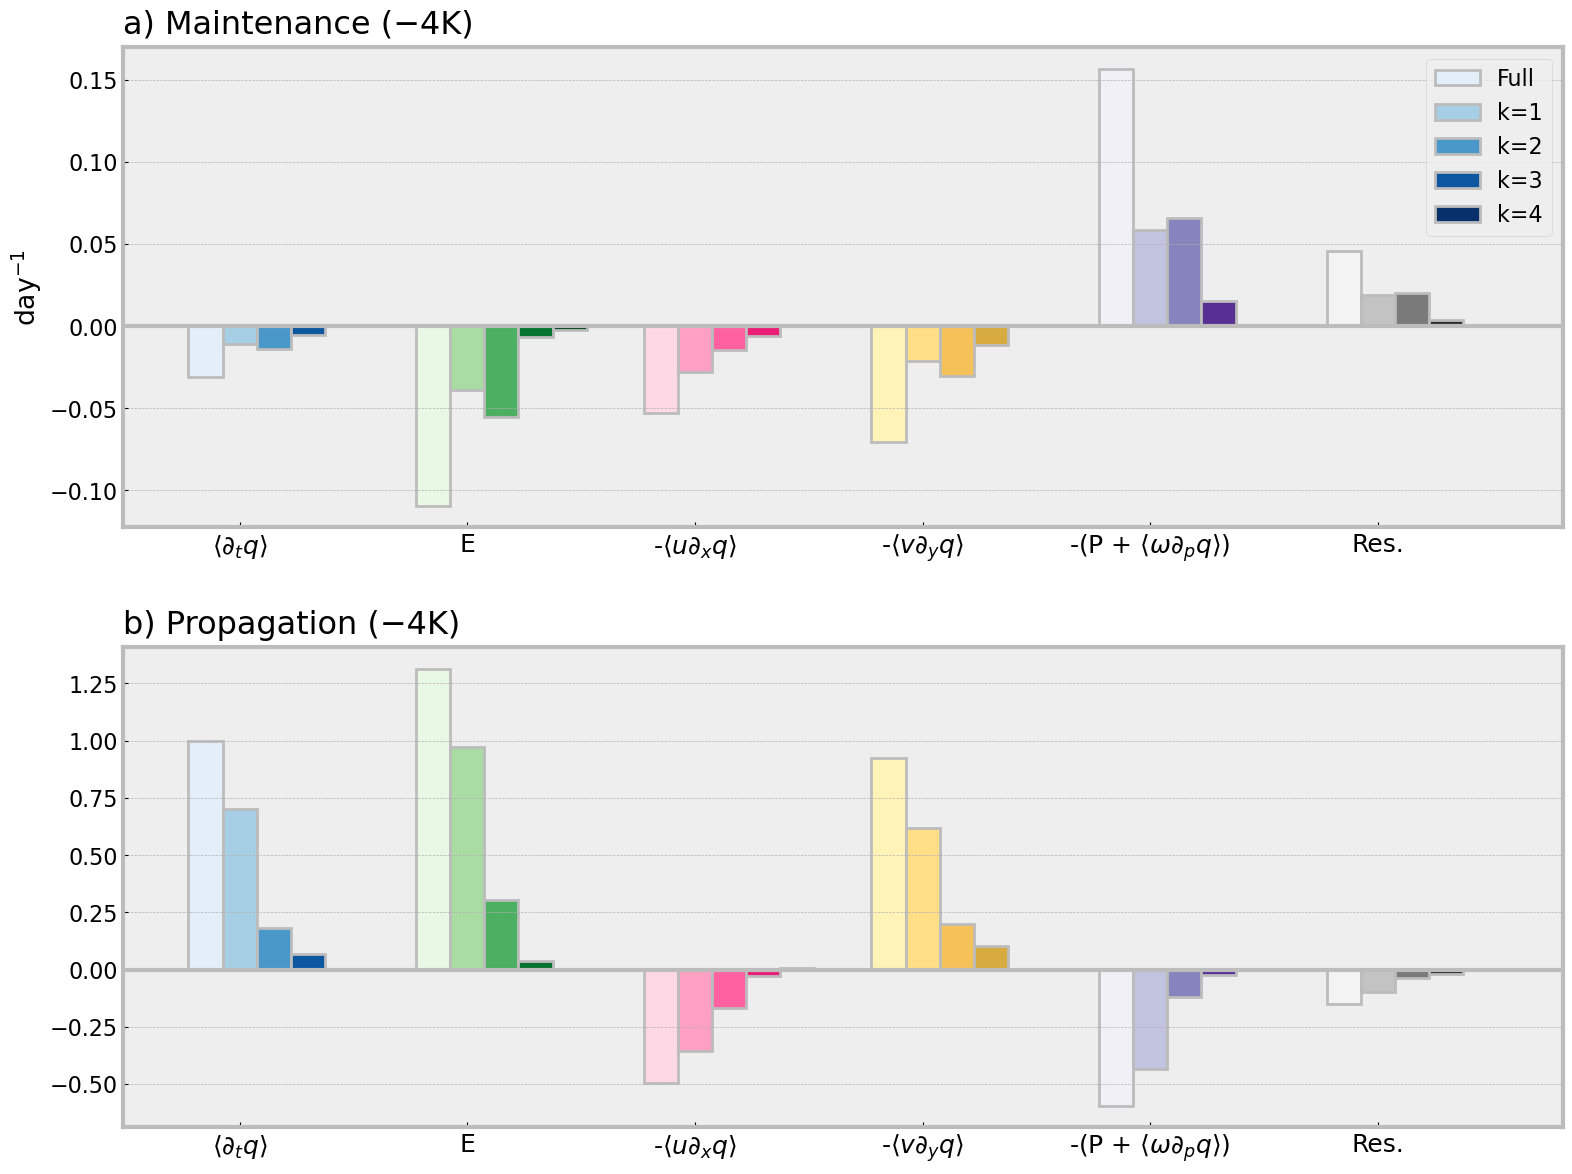

In [55]:
# projected_variable = "Moist Static Energy"

processes_to_plot = [
    'Moisture Tendency',
    'Evaporation',
    # 'Precipitation + Vertical Advection + Residual',
    'Zonal Advection',
    'Meridional Advection',
    # 'Vertical Advection',
    # 'Precipitation',
    'Precipitation + Vertical Advection',
    # 'Column Process',
    'Residual',
]

experiment_to_plot = '-4K'

plt.style.use('bmh')
plt.rcParams.update({'font.size': 16, 'mathtext.fontset': 'dejavusans'})

fig = plt.figure(figsize=(16, 12))
gs = GridSpec(2, 1, figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.25)

ax = []
ax.append(fig.add_subplot(gs[0]))
ax.append(fig.add_subplot(gs[1]))

bar_width = 0.15
x_positions = np.arange(len(processes_to_plot))

ax[0].set_title(f'a) Maintenance ({experiments_array.sel(experiment=experiment_to_plot)['name'].item()})', pad=10, loc='left')
ax[1].set_title(f'b) Propagation ({experiments_array.sel(experiment=experiment_to_plot)['name'].item()})', pad=10, loc='left')

# Plot bars for each experiment
for i, wavenumber in enumerate([0] + zonal_wavenumbers_to_filter):
    plot_label = (
        f"{experiments_array.sel(experiment=experiment)['name'].item()}"
        + f" ({tick_labeller(latitude_integration_bounds[experiment], 'lat', precision=0)[0]}"
        + f"-{tick_labeller(latitude_integration_bounds[experiment], 'lat', precision=0)[1]}),"
        + f" ({tick_labeller(longitude_integration_bounds[experiment], 'lon', precision=0)[0]}"
        + f"-{tick_labeller(longitude_integration_bounds[experiment], 'lon', precision=0)[1]})"
    )
    ax[0].bar(
        x_positions + i * bar_width,
        [
            SECONDS_PER_DAY*budget_maintenance_contribution[process].sel(experiment=experiment_to_plot, zonal_wavenumber=wavenumber).values
            for process
            in processes_to_plot
        ],
        width=bar_width,
        # label=plot_label,
        label=(f"k={wavenumber}" if wavenumber != 0 else 'Full'),
        color=[budget_term_attributes[process]['color'](0.1 + 1/len(zonal_wavenumbers_to_filter) * i) for process in processes_to_plot],
        edgecolor='#bcbcbc',
        lw=2,
    )

    ax[1].bar(
        x_positions + i * bar_width,
        [
            budget_propagation_contribution[process].sel(experiment=experiment_to_plot, zonal_wavenumber=wavenumber).values
            for process
            in processes_to_plot
        ],
        width=bar_width,
        # label=plot_label,
        label=(f"k={wavenumber}" if wavenumber != 0 else 'Full'),
        color=[budget_term_attributes[process]['color'](0.1 + 1/len(zonal_wavenumbers_to_filter) * i) for process in processes_to_plot],
        edgecolor='#bcbcbc',
        lw=2,
    )

ax[0].set_ylabel(r'day$^{-1}$')
# ax[0].set_ylim(-0.15, 0.15)
# Add legend to distinguish experiments
ax[0].legend(fontsize=16)

# ax[1].set_ylim(-0.25, 1.25)
# ax[1].set_yticks(np.arange(-0.25, 1.5, 0.25))

for ax in ax:
    ax.set_xticks(x_positions + bar_width, labels=[budget_term_attributes[process]['label'] for process in processes_to_plot], fontsize=18)
    ax.axhline(y=0, color='#bcbcbc', lw=3)
    ax.grid(axis='x')
    # [ax.axvline(x=(position + 3*bar_width), ls=':', color='#bcbcbc') for position in x_positions[:-1]]

    for spine in ax.spines.values():
        spine.set_edgecolor("#bcbcbc")
        spine.set_linewidth(3)

# Save figure
output_filename = f"{projection_variable.lower().replace(" ", "_")}_budget_maintenance_propagation_by_wavenumber"
print(f"Output directory: {aquaplanet_output_directory}")
print(f"Output filename: {output_filename}/budget_analysis")
if savefig:
    print(f"{f'Saving...':<{str_width-1}}", end="")
    plt.savefig(
        f"{aquaplanet_output_directory}/budget_analysis/{output_filename}.png",
        dpi=500,
        bbox_inches="tight",
    )
    print(rf"{'✔':>1}")
else:
    print("Not Saving")
    plt.show()

### Advection Budget Breakdowns

In [10]:
advection_type_colormap = {}
advection_type_colormap['Zonal Advection'] =\
    mcolors.LinearSegmentedColormap.from_list("HighContrastPinks", ["#fff0f5", "#ffb3cc", "#ff80b3", "#ff3385", "#cc005f"], N=256)
advection_type_colormap['Meridional Advection'] =\
    mcolors.LinearSegmentedColormap.from_list("Golden",["#fff9cc", "#ffe999", "#ffcc66",  "#e6b347", "#c49e35"], N=256)
advection_type_colormap['Vertical Advection'] = plt.get_cmap('Purples')

if processes_to_load == 'single decomposed advection term':
    budget_maintenance_contribution[f'{advection_type} Sum'] = (
        budget_maintenance_contribution[f'{advection_type} Mean wind mean moisture']
        + budget_maintenance_contribution[f'{advection_type} Mean wind MJO moisture']
        + budget_maintenance_contribution[f'{advection_type} Mean wind residial moisture']
        + budget_maintenance_contribution[f'{advection_type} MJO wind mean moisture']
        + budget_maintenance_contribution[f'{advection_type} MJO wind MJO moisture']
        + budget_maintenance_contribution[f'{advection_type} MJO wind residual moisture']
        + budget_maintenance_contribution[f'{advection_type} Residual wind mean moisture']
        + budget_maintenance_contribution[f'{advection_type} Residual wind MJO moisture']
        + budget_maintenance_contribution[f'{advection_type} Residual wind residual moisture']
    )

    budget_propagation_contribution[f'{advection_type} Sum'] = (
        budget_propagation_contribution[f'{advection_type} Mean wind mean moisture']
        + budget_propagation_contribution[f'{advection_type} Mean wind MJO moisture']
        + budget_propagation_contribution[f'{advection_type} Mean wind residial moisture']
        + budget_propagation_contribution[f'{advection_type} MJO wind mean moisture']
        + budget_propagation_contribution[f'{advection_type} MJO wind MJO moisture']
        + budget_propagation_contribution[f'{advection_type} MJO wind residual moisture']
        + budget_propagation_contribution[f'{advection_type} Residual wind mean moisture']
        + budget_propagation_contribution[f'{advection_type} Residual wind MJO moisture']
        + budget_propagation_contribution[f'{advection_type} Residual wind residual moisture']
    )

    budget_term_attributes = {
    f'{advection_type}': {
        'label': budget_maintenance_contribution[f'{advection_type}'].attrs['math_name'],
        'color': advection_type_colormap[advection_type],
    },
    f'{advection_type} Sum': {
        'label': 'Sum',
        'color': advection_type_colormap[advection_type],
    },
    f'{advection_type} Mean wind mean moisture': {
        # 'label': budget_maintenance_contribution[f'{advection_type} Mean wind mean moisture'].attrs['math_name'],
        # 'label': r"$-\langle \bar{u} \cdot \partial_x \bar{q} \rangle$",
        # 'label': r"$-\langle \bar{v} \cdot \partial_y \bar{q} \rangle$",
        'label': r"$-\langle \bar{\omega} \cdot \partial_p \bar{q} \rangle$",
        'color': advection_type_colormap[advection_type],
    },
    f'{advection_type} Mean wind MJO moisture': {
        # 'label': budget_maintenance_contribution[f'{advection_type} Mean wind MJO moisture'].attrs['math_name'],
        # 'label': r"$-\langle \bar{u} \cdot \partial_x q_\text{MJO} \rangle$",
        # 'label': r"$-\langle \bar{v} \cdot \partial_y q_\text{MJO} \rangle$",
        'label': r"$-\langle \bar{\omega} \cdot \partial_p q_\text{MJO} \rangle$",
        'color': advection_type_colormap[advection_type],
    },
    f'{advection_type} Mean wind residial moisture': {
        # 'label': budget_maintenance_contribution[f'{advection_type} Mean wind residial moisture'].attrs['math_name'],
        # 'label': r"$-\langle \bar{u} \cdot \partial_x q_{r} \rangle$",
        # 'label': r"$-\langle \bar{v} \cdot \partial_y q_{r} \rangle$",
        'label': r"$-\langle \bar{\omega} \cdot \partial_p q_{r} \rangle$",
        'color': advection_type_colormap[advection_type],
    },
    f'{advection_type} MJO wind mean moisture': {
        # 'label': budget_maintenance_contribution[f'{advection_type} MJO wind mean moisture'].attrs['math_name'],
        # 'label': r"$-\langle u_\text{MJO} \cdot \partial_x \bar{q} \rangle$",
        # 'label': r"$-\langle v_\text{MJO} \cdot \partial_y \bar{q} \rangle$",
        'label': r"$-\langle \omega_\text{MJO} \cdot \partial_p \bar{q} \rangle$",
        'color': advection_type_colormap[advection_type],
    },
    f'{advection_type} MJO wind MJO moisture': {
        # 'label': budget_maintenance_contribution[f'{advection_type} MJO wind MJO moisture'].attrs['math_name'],
        # 'label': r"$-\langle u_\text{MJO} \cdot \partial_x q_\text{MJO} \rangle$",
        # 'label': r"$-\langle v_\text{MJO} \cdot \partial_y q_\text{MJO} \rangle$",
        'label': r"$-\langle \omega_\text{MJO} \cdot \partial_p q_\text{MJO} \rangle$",
        'color': advection_type_colormap[advection_type],
    },
    f'{advection_type} MJO wind residual moisture': {
        # 'label': budget_maintenance_contribution[f'{advection_type} MJO wind residual moisture'].attrs['math_name'],
        # 'label': r"$-\langle u_\text{MJO} \cdot \partial_x q_r \rangle$",
        # 'label': r"$-\langle v_\text{MJO} \cdot \partial_y q_r \rangle$",
        'label': r"$-\langle \omega_\text{MJO} \cdot \partial_p q_r \rangle$",
        'color': advection_type_colormap[advection_type],
    },
    f'{advection_type} Residual wind mean moisture': {
        # 'label': budget_maintenance_contribution[f'{advection_type} Residual wind mean moisture'].attrs['math_name'],
        # 'label': r"$-\langle u_r \cdot \partial_x \bar{q} \rangle$",
        # 'label': r"$-\langle v_r \cdot \partial_y \bar{q} \rangle$",
        'label': r"$-\langle \omega_r \cdot \partial_p \bar{q} \rangle$",
        'color': advection_type_colormap[advection_type],
    },
    f'{advection_type} Residual wind MJO moisture': {
        # 'label': budget_maintenance_contribution[f'{advection_type} Residual wind MJO moisture'].attrs['math_name'],
        # 'label': r"$-\langle u_r \cdot \partial_x q_\text{MJO} \rangle$",
        # 'label': r"$-\langle v_r \cdot \partial_y q_\text{MJO} \rangle$",
        'label': r"$-\langle \omega_r \cdot \partial_p q_\text{MJO} \rangle$",
        'color': advection_type_colormap[advection_type],
    },
    f'{advection_type} Residual wind residual moisture': {
        # 'label': budget_maintenance_contribution[f'{advection_type} Residual wind residual moisture'].attrs['math_name'],
        # 'label': r"$-\langle u_r \cdot \partial_x q_r \rangle$",
        # 'label': r"$-\langle v_r \cdot \partial_y q_r \rangle$",
        'label': r"$-\langle \omega_r \cdot \partial_p q_r \rangle$",
        'color': advection_type_colormap[advection_type],
    },
    # f'Precipitation': {
    #     'label': budget_maintenance_contribution[Precipitation].attrs['math_name'],
    #     'color': advection_type_colormap[advection_type],
    # },
}

elif processes_to_load == 'full budget with decomposed advection terms':
    budget_maintenance_contribution['Precipitation + Vertical Advection'] = (
        budget_maintenance_contribution[f'Precipitation']
        + budget_maintenance_contribution[f'Vertical Advection MJO wind mean moisture']
    )

    budget_propagation_contribution[f'Precipitation + Vertical Advection'] = (
        budget_propagation_contribution[f'Precipitation']
        + budget_propagation_contribution[f'Vertical Advection MJO wind mean moisture']
    )

    budget_term_attributes = {
        'Moisture Tendency': {
            'label': r"$\langle \partial_{t} q \rangle$",
            'color': plt.get_cmap('Blues'),
        },
        'Evaporation': {
            'label': r'E',
            'color': plt.get_cmap('Greens'),
        },
        'Precipitation': {
            'label': r'-P',
            'color': mcolors.LinearSegmentedColormap.from_list("Cyans", ["#e0ffff", "#80e0ff", "#00c0ff", "#0080ff", "#0040ff"], N=256),
        },
        f'Vertical Advection MJO wind mean moisture': {
            # 'label': budget_maintenance_contribution[f'{advection_type}'].attrs['math_name'],
            'label': r"$-\langle \omega_\text{MJO} \cdot \partial_p \bar{q} \rangle$",
            'color': advection_type_colormap['Vertical Advection'],
        },
        f'Precipitation + Vertical Advection': {
            'label': r"$-(P + \langle \omega_\text{MJO} \cdot \partial_p \bar{q} \rangle$)",
            'color': advection_type_colormap['Vertical Advection'],
        },
        f'Zonal Advection Mean wind MJO moisture': {
            # 'label': budget_maintenance_contribution[f'{advection_type}'].attrs['math_name'],
            'label': r"$-\langle \bar{u} \cdot \partial_x q_\text{MJO} \rangle$",
            'color': advection_type_colormap['Zonal Advection'],
        },
        f'Zonal Advection Residual wind residual moisture': {
            # 'label': budget_maintenance_contribution[f'{advection_type}'].attrs['math_name'],
            'label': r"$-\langle u_r \cdot \partial_x q_r \rangle$",
            'color': advection_type_colormap['Zonal Advection'],
        },
        f'Meridional Advection MJO wind mean moisture': {
            # 'label': budget_maintenance_contribution[f'{advection_type}'].attrs['math_name'],
            'label': r"$-\langle v_\text{MJO} \cdot \partial_y \bar{q} \rangle$",
            'color': advection_type_colormap['Meridional Advection'],
        },
        f'Meridional Advection Residual wind residual moisture': {
            # 'label': budget_maintenance_contribution[f'{advection_type}'].attrs['math_name'],
            'label': r"$-\langle v_r \cdot \partial_y q_r \rangle$",
            'color': advection_type_colormap['Meridional Advection'],
        },
        'Residual': {
            'label': r"Res.",
            'color': plt.get_cmap('Greys'),
        },
}

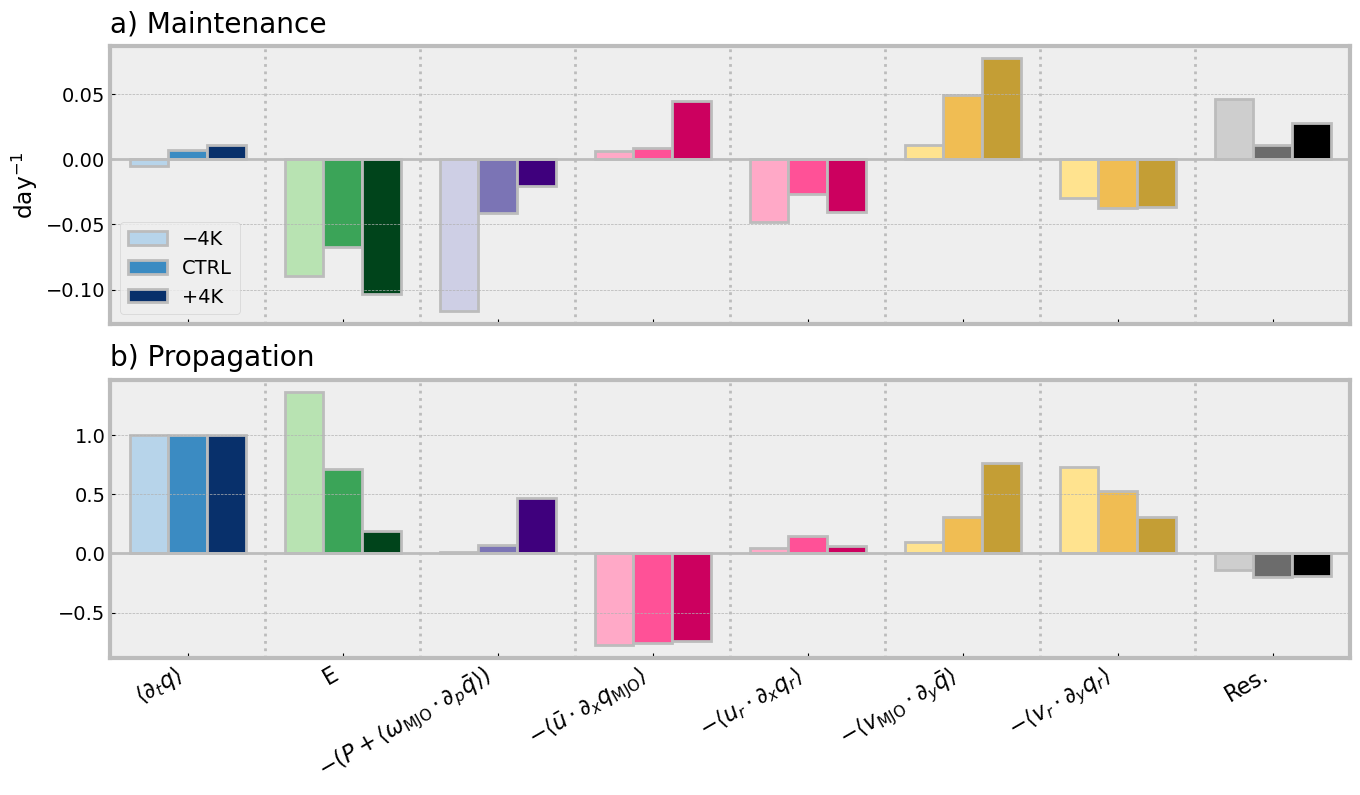

In [11]:
if processes_to_load == 'single decomposed advection term':
    processes_to_plot = [
        # 'Precipitation',
        f'{advection_type} Mean wind mean moisture',
        f'{advection_type} Mean wind MJO moisture',
        f'{advection_type} Mean wind residial moisture',
        f'{advection_type} MJO wind mean moisture',
        f'{advection_type} MJO wind MJO moisture',
        f'{advection_type} MJO wind residual moisture',
        f'{advection_type} Residual wind mean moisture',
        f'{advection_type} Residual wind MJO moisture',
        f'{advection_type} Residual wind residual moisture',
        f'{advection_type} Sum',
        f'{advection_type}',
    ]

elif processes_to_load == 'full budget with decomposed advection terms':
    processes_to_plot = [
        'Moisture Tendency',
        'Evaporation',
        # 'Precipitation',
        # f'Vertical Advection MJO wind mean moisture',
        'Precipitation + Vertical Advection',
        f'Zonal Advection Mean wind MJO moisture',
        f'Zonal Advection Residual wind residual moisture',
        f'Meridional Advection MJO wind mean moisture',
        f'Meridional Advection Residual wind residual moisture',
        'Residual'
    ]

plt.style.use('bmh')
plt.rcParams.update({'font.size': 14, 'mathtext.fontset': 'dejavusans'})

fig, ax = plt.subplots(2, 1, figsize=(16, 9))

bar_width = 0.25
x_positions = np.arange(len(processes_to_plot))

# Plot bars for each experiment
ax[0].set_title("a) Maintenance", pad=10, loc='left')
ax[1].set_title("b) Propagation", pad=10, loc='left')
for i, experiment in enumerate(experiments_list):
    ax[0].bar(
        x_positions + i * bar_width,
        [SECONDS_PER_DAY*budget_maintenance_contribution[process].sel(experiment=experiment).values for process in processes_to_plot],
        width=bar_width,
        label=experiments_array.sel(experiment=experiment)['name'].item(),
        color=[budget_term_attributes[process]['color'](0.3 + 0.35 * i) for process in processes_to_plot],
        edgecolor='#bcbcbc',
        lw=2,
    )

    ax[1].bar(
        x_positions + i * bar_width,
        [budget_propagation_contribution[process].sel(experiment=experiment).values for process in processes_to_plot],
        width=bar_width,
        label=experiments_array.sel(experiment=experiment)['name'].item(),
        color=[budget_term_attributes[process]['color'](0.3 + 0.35 * i) for process in processes_to_plot],
        edgecolor='#bcbcbc',
        lw=2,
    )

ax[0].set_ylabel(r'day$^{-1}$')

# Zonal
# ax[0].set_ylim(-0.05, 0.05)
# ax[0].set_yticks(np.arange(-0.05, 0.075, 0.025))

# Meridional
# ax[0].set_ylim(-0.075, 0.15)
# ax[0].set_yticks(np.arange(-0.075, 0.125+0.05, 0.05))
# ax[1].set_ylim(-0.25, 1.5)
# ax[1].set_yticks(np.arange(-0.25, 1.25+0.5, 0.5))

# Vertical
# ax[0].set_ylim(-0.1, 1.1)
# ax[0].set_yticks(np.arange(-0.1, 1.1+0.1, 0.2))
# ax[1].set_ylim(-3.5, 0.5)
# ax[1].set_yticks(np.arange(-3.5, 0.5+0.75, 0.75))

ax[0].set_xticks(x_positions + bar_width, labels=[])

ax[1].set_xticks(x_positions + bar_width, labels=[budget_term_attributes[process]['label'] for process in processes_to_plot], fontsize=16)#, rotation=-25, ha='left')

# Add legend to distinguish experiments
ax[0].legend(fontsize=14)

for ax in ax:
    ax.set_xlim(x_positions[0] - 0.25, x_positions[-1] + 3*bar_width)
    [ax.axvline(x=(position + 3*bar_width), ls=':', color='#bcbcbc') for position in x_positions]
    # ax.axvline(x=(x_positions[-2] + 3*bar_width), ls=(0, (10, 3)), color='#bcbcbc', lw=3)
    # ax.axvline(x=(x_positions[-3] + 3*bar_width), ls=(0, (10, 3)), color='#bcbcbc', lw=3)
    # [ax.axvline(x=(position + 3*bar_width), ls=':', color='#bcbcbc') for position in x_positions[:-1]]
    ax.axhline(y=0, color='#bcbcbc', lw=2)
    ax.grid(axis='x')

    for spine in ax.spines.values():
        spine.set_edgecolor("#bcbcbc")
        spine.set_linewidth(3)

fig.autofmt_xdate()

plt.show()
# Save figure
output_filename = f"{projection_variable.lower().replace(" ", "_")}_budget_maintenance_propagation_decomposed"
print(f"Output directory: {aquaplanet_output_directory}")
print(f"Output filename: {output_filename}/budget_analysis")
if savefig:
    print(f"{f'Saving...':<{str_width-1}}", end="")
    plt.savefig(
        f"{aquaplanet_output_directory}/budget_analysis/{output_filename}.png",
        dpi=500,
        bbox_inches="tight",
    )
    print(rf"{'✔':>1}")
else:
    print("Not Saving")
    plt.show()

#### Wavenumber Analysis

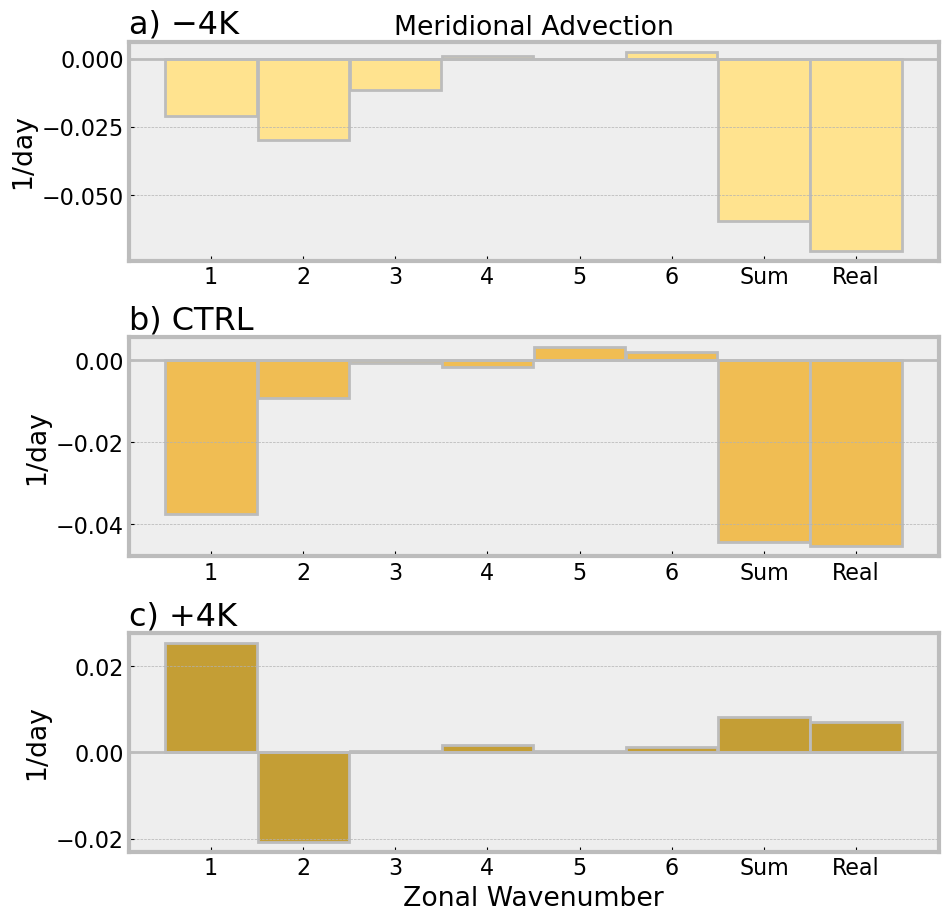

In [263]:
k_vals = [1,2,3,4,5,6]
fig = plt.figure(figsize=(9, 9))
gs = GridSpec(3, 1, figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.35)

ax = []
ax.append(fig.add_subplot(gs[0]))
ax.append(fig.add_subplot(gs[1]))
ax.append(fig.add_subplot(gs[2]))

process_to_plot = 'Meridional Advection'

letter = ['a', 'b', 'c']
bar_width = 0.1
x_positions = [k*(1.01*bar_width) for k in k_vals + [7,8]]

fig.suptitle(f"{process_to_plot}")
for index, experiment in enumerate(experiments_list):

    ax[index].set_title(
        f"{letter[index]}) {experiments_array.sel(experiment=experiment)['name'].item()}",
        loc='left'
    )

    bar_val = []
    for k in k_vals:
        bar_val.append(SECONDS_PER_DAY*budget_maintenance_contribution[process_to_plot].sel(experiment = experiment, zonal_wavenumber=k).real.values)
    # bar_val.append(SECONDS_PER_DAY*multi_experiment_q1dq2.sel(experiment=experiment))
    # bar_val.append(SECONDS_PER_DAY*multi_experiment_q1dq3.sel(experiment=experiment))
    # bar_val.append(SECONDS_PER_DAY*multi_experiment_q2dq1.sel(experiment=experiment))

    bar_val.append(
        np.sum(
            [SECONDS_PER_DAY*budget_maintenance_contribution[process_to_plot].sel(experiment = experiment, zonal_wavenumber=k).real.values for k in k_vals]
            # + [
            #     SECONDS_PER_DAY*multi_experiment_q1dq2.sel(experiment=experiment),
            #     SECONDS_PER_DAY*multi_experiment_q1dq3.sel(experiment=experiment),
            #     SECONDS_PER_DAY*multi_experiment_q2dq1.sel(experiment=experiment),
            # ]
        )
    )
    bar_val.append(SECONDS_PER_DAY*budget_maintenance_contribution[process_to_plot].sel(experiment = experiment, zonal_wavenumber=0).real.values)

    ax[index].bar(
        x = x_positions,
        # x = [0.25*k_val for k_val in k_vals],
        height=bar_val,
        width=bar_width,
        color=[budget_term_attributes[process_to_plot]['color'](0.3 + 0.35 * index)],
        edgecolor='#bcbcbc',
        lw=2,
    )
    ax[index].set_xticks(
        ticks=x_positions,
        labels = [f"{k_val:0.0f}" for k_val in k_vals] +\
        # [r'$q_1 \partial_t q_2$', '$q_1 \partial_t q_3$', '$q_2 \partial_t q_1$', 'Sum', 'Real'])
        ['Sum', 'Real'])
    ax[index].set_ylabel('1/day')
    # ax[index].set_ylim(-0.01, 0.075)
    ax[index].axhline(y=0, color="#bcbcbc", ls='-')

    for spine in ax[index].spines.values():
        spine.set_edgecolor("#bcbcbc")
        spine.set_linewidth(3)

ax[2].set_xlabel('Zonal Wavenumber')
for ax in ax:
    ax.grid(axis='x')

    # for spine in ax.spines.values():
    #     spine.set_edgecolor("#bcbcbc")
    #     spine.set_linewidth(3)

plt.show()

In [ ]:
projection_variable = 'Moisture'
merged_multi_experiment_budget_variables_regressed = xr.merge(
    [
        multi_experiment_budget_variables_regressed['Moisture'],
        multi_experiment_budget_variables_regressed[f'{advection_type} Mean wind mean moisture'],
        multi_experiment_budget_variables_regressed[f'{advection_type} Mean wind MJO moisture'],
        multi_experiment_budget_variables_regressed[f'{advection_type} Mean wind residial moisture'],
        multi_experiment_budget_variables_regressed[f'{advection_type} MJO wind mean moisture'],
        multi_experiment_budget_variables_regressed[f'{advection_type} MJO wind MJO moisture'],
        multi_experiment_budget_variables_regressed[f'{advection_type} MJO wind residual moisture'],
        multi_experiment_budget_variables_regressed[f'{advection_type} Residual wind mean moisture'],
        multi_experiment_budget_variables_regressed[f'{advection_type} Residual wind MJO moisture'],
        multi_experiment_budget_variables_regressed[f'{advection_type} Residual wind residual moisture'],
    ]
)

latitude_bounds = (-20, 20)

experiment_to_plot = '4K'
savefig=False

plt.style.use('default')
plt.rcParams.update({'font.size':20})

colormap = 'RdYlBu_r'

fig = plt.figure(figsize=(16, 12))
gs = GridSpec(5, 5, width_ratios=[15,15,15,15,2], figure=fig)
# gs = GridSpec(3, 5, width_ratios=[15,15,15,15,2], figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.55, wspace=0.25)

axes = []
axes.append(fig.add_subplot(gs[0, :2], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[0, 2:4], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[1, :2], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[1, 2:4], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[2, :2], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[2, 2:4], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[3, :2], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[3, 2:4], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[4, 1:3], projection=ccrs.PlateCarree(central_longitude=180)))

cbar_ax = fig.add_subplot(gs[:,-1])

grand_max = round_out(
    merged_multi_experiment_budget_variables_regressed.sel(
        lat=slice(*latitude_bounds)
    ).drop_vars(projection_variable).to_array().max(),
    order=6
)
grand_min = round_out(
    merged_multi_experiment_budget_variables_regressed.sel(
        lat=slice(*latitude_bounds)
    ).drop_vars(projection_variable).to_array().min(),
    order=6
)
# levels = np.arange(grand_min, grand_max+2.5, 2.5)
levels = np.linspace(grand_min, grand_max, 21)

fig.suptitle(
    f"{experiments_array.sel(
        experiment=experiment_to_plot
    )['name'].item()} MJO {projection_variable.title()} Budget Terms,\n {mjo_index_method} Regression Method",
    x=0.5,
    y=1.075
)

for ax, (variable_name, variable_data) in zip(
    axes,
    list(
        merged_multi_experiment_budget_variables_regressed.drop_vars(projection_variable).data_vars.items()
    )
):
    [cdata, clon] = cutil.add_cyclic_point(
        variable_data.sel(lat=slice(*latitude_bounds)).sel(experiment=experiment_to_plot),
        variable_data.lon
    )

    ax.set_title(f"{variable_data.attrs['math_name']}", pad=10)
    im = ax.contourf(
        clon,
        variable_data.lat.sel(lat=slice(*latitude_bounds)),
        cdata,
        # cmap=colormap,
        cmap=mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05),
        # levels=np.linspace(grand_min, grand_max, 21),
        levels=levels,
        norm=mcolors.CenteredNorm(vcenter=0),
        transform=ccrs.PlateCarree()
    )

    [cmoisture_data, cmoisture_lon] = cutil.add_cyclic_point(
        merged_multi_experiment_budget_variables_regressed[projection_variable].sel(experiment=experiment_to_plot),
        merged_multi_experiment_budget_variables_regressed[projection_variable].lon
    )

    ax.contour(
        cmoisture_lon,
        merged_multi_experiment_budget_variables_regressed[projection_variable].lat,
        cmoisture_data,
        transform=ccrs.PlateCarree(),
        colors='k',
        alpha=0.5,
        levels=7
    )

    if mjo_index_method == 'AK12':
        ax.plot(
            reference_longitude,
            reference_latitude.sel(experiment=experiment_to_plot),
            transform=ccrs.PlateCarree(),
            marker='x',
            color='black',
            ms=10
        )


for index, ax in enumerate(axes):

    ax.set_aspect("auto")
    ax.add_feature(cf.COASTLINE)
    ax.set_xlim(-180, 180)
    # x_ticks = np.arange(0, 360 + 60, 60)
    x_ticks = np.arange(-180, 180 + 60, 60)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(tick_labeller(x_ticks+180, "lon", precision=0))
    ax.xaxis.set_major_locator(mticker.MaxNLocator(7, prune="lower"))

    if index == len(axes)-1:
        ax.set_xlabel("Longitude")

    ax.set_ylim(*latitude_bounds)
    y_ticks = np.arange(latitude_bounds[0], latitude_bounds[1]+10, 10)
    ax.set_yticks(y_ticks)
    if index%2 == 0:
        ax.set_yticklabels(tick_labeller(y_ticks, "lat", precision=0))
        ax.set_ylabel("Latitude")
    else:
        ax.set_yticklabels('')

    grid_kwargs = {"linewidth": 1, "linestyle": (0, (5, 10)), "color": "gray"}
    ax.grid(True, **grid_kwargs)

cbar = fig.colorbar(im, cax=cbar_ax, format='%.2e')
# cbar.set_label(r"W m$^{-2}$")
# cbar.set_label(r"10$^{-6}$ $\times$ kg m$^{-2}$ s$^{-1}$")

# Save figure
output_filename = f"{experiment_to_plot}_budget_terms_latlon"
print(f"Output directory: {aquaplanet_output_directory}")
print(f"Output filename: {output_filename}/budget_analysis")
if savefig:
    print(f"{f'Saving...':<{str_width-1}}", end="")
    plt.savefig(
        f"{aquaplanet_output_directory}/budget_analysis/{output_filename}.png",
        dpi=500,
        bbox_inches="tight",
    )
    print(rf"{'✔':>1}")
else:
    print("Not Saving")
    plt.show()

In [ ]:
projection_variable = 'Moisture'
latitude_bounds = (-20, 20)

savefig=False

plt.style.use('default')
plt.rcParams.update({'font.size':20})

colormap = 'RdYlBu_r'

# variable_data = multi_experiment_budget_variables_regressed['Moisture Tendency']
# variable_data.name = 'Moisture Tendency'
# variable_data = (
#     multi_experiment_budget_variables_regressed['Precipitation']
#     + multi_experiment_budget_variables_regressed['Vertical Advection MJO wind mean moisture']
# )
# variable_data.name = 'Precipitation + Vertical Advection of Mean Moisture by MJO Winds'
# variable_data = multi_experiment_budget_variables_regressed['Precipitation']
# variable_data.name = 'Precipitation'
# variable_data = multi_experiment_budget_variables_regressed['Residual']
# variable_data.name = 'Residual'

# variable_data = multi_experiment_budget_variables_regressed['Evaporation']
# variable_data.name = 'Evaporation'
# variable_data = multi_experiment_budget_variables_regressed['Zonal Advection Mean wind MJO moisture']
# variable_data.name = 'Zonal Advection of MJO Moisture by Mean Winds'
# variable_data = multi_experiment_budget_variables_regressed['Zonal Advection Residual wind residual moisture']
# variable_data.name = 'Zonal Advection of Residual Moisture by Residual Winds'
variable_data = multi_experiment_budget_variables_regressed['Meridional Advection MJO wind mean moisture']
variable_data.name = 'Meridional Advection of Mean Moisture by MJO Winds'
# variable_data = multi_experiment_budget_variables_regressed['Meridional Advection Residual wind residual moisture']
# variable_data.name = 'Meridional Advection of Residual Moisture by Residual Winds'


fig = plt.figure(figsize=(16, 9))
gs = GridSpec(3, 2, width_ratios=[45,1], figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.55, wspace=0.1)

fig.suptitle(
    f"{variable_data.name}",
    x=0.5,
    y=1.075
)

axes = []
axes.append(fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree(central_longitude=180)))

cbar_axes = []
cbar_axes.append(fig.add_subplot(gs[0, -1]))
cbar_axes.append(fig.add_subplot(gs[1, -1]))
cbar_axes.append(fig.add_subplot(gs[2, -1]))

# grand_min = variable_data.sel(experiment='-4K').min()
# grand_max = variable_data.sel(experiment='-4K').max()
# levels = np.linspace(grand_min, grand_max, 21)

for experiment_to_plot, ax, cbar_ax in zip(experiments_list, axes, cbar_axes):
    [cdata, clon] = cutil.add_cyclic_point(
        variable_data.sel(lat=slice(*latitude_bounds)).sel(experiment=experiment_to_plot),
        variable_data.lon
    )

    # ax.set_title(f"{variable_data.attrs['math_name']}", pad=10)
    ax.set_title(experiments_array.sel(experiment=experiment_to_plot)['name'].item())
    im = ax.contourf(
        clon,
        variable_data.lat.sel(lat=slice(*latitude_bounds)),
        cdata,
        # cmap=colormap,
        cmap=mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05),
        # levels=np.linspace(grand_min, grand_max, 21),
        levels=21,
        norm=mcolors.CenteredNorm(vcenter=0),
        transform=ccrs.PlateCarree()
    )
    cbar = fig.colorbar(im, cax=cbar_ax, format='%.1e', orientation='vertical')
    cbar.set_label(r"kg m$^{-2}$ s$^{-1}$")
    cbar.set_ticks(ticks = im.levels[::4])

    [cmoisture_data, cmoisture_lon] = cutil.add_cyclic_point(
        multi_experiment_budget_variables_regressed[projection_variable].sel(experiment=experiment_to_plot),
        multi_experiment_budget_variables_regressed[projection_variable].lon
    )

    cs = ax.contour(
        cmoisture_lon,
        multi_experiment_budget_variables_regressed[projection_variable].lat,
        cmoisture_data,
        transform=ccrs.PlateCarree(),
        colors='k',
        alpha=0.5,
        levels=7
    )
    ax.clabel(cs, fontsize=10)

    if mjo_index_method == 'AK12':
        ax.plot(
            reference_longitude,
            reference_latitude.sel(experiment=experiment_to_plot),
            transform=ccrs.PlateCarree(),
            marker='x',
            color='black',
            ms=10
        )



for index, ax in enumerate(axes):

    ax.set_aspect("auto")
    ax.add_feature(cf.COASTLINE)
    ax.set_xlim(-180, 180)
    # x_ticks = np.arange(0, 360 + 60, 60)
    x_ticks = np.arange(-180, 180 + 60, 60)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(tick_labeller(x_ticks+180, "lon", precision=0))
    ax.xaxis.set_major_locator(mticker.MaxNLocator(7, prune="lower"))

    if index == len(axes)-1:
        ax.set_xlabel("Longitude")

    ax.set_ylim(*latitude_bounds)
    y_ticks = np.arange(latitude_bounds[0], latitude_bounds[1]+10, 10)
    ax.set_yticks(y_ticks)
    # if index%2 == 0:
    ax.set_yticklabels(tick_labeller(y_ticks, "lat", precision=0))
    ax.set_ylabel("Latitude")
    # else:
    #     ax.set_yticklabels('')

    grid_kwargs = {"linewidth": 1, "linestyle": (0, (5, 10)), "color": "gray"}
    ax.grid(True, **grid_kwargs)

# cbar.set_label(r"W m$^{-2}$")
# cbar.set_label(r"10$^{-6}$ $\times$ kg m$^{-2}$ s$^{-1}$")

### Horizontal Structures

In [87]:
# # multi_experiment_budget_variables_regressed['Column Process'] = (
# #     multi_experiment_budget_variables_regressed['Vertical Advection']
# #     + multi_experiment_budget_variables_regressed['Precipitation']
# # )
# # multi_experiment_budget_variables_regressed['Column Process'].name = 'Column Processes'

# # multi_experiment_budget_variables_regressed.drop_vars('Vertical Advection')
# # multi_experiment_budget_variables_regressed.drop_vars('Precipitation')
# merged_multi_experiment_budget_variables_regressed = xr.merge(
#     [
#         variable
#         for variable in multi_experiment_budget_variables_regressed.values()
#         # if (variable.name != "Precipitation") and (variable.name != "Column Vertical Advection")
#     ]
# )

# experiment_to_plot = '-4K'
# savefig=False

# plt.style.use('default')
# plt.rcParams.update({'font.size':20})

# meridional_mean_region = slice(-50,50)
# colormap = 'RdYlBu_r'

# fig = plt.figure(figsize=(16, 12))
# gs = GridSpec(4, 7, width_ratios=[15,15,15,15,15,15,2], height_ratios=[1,1,1,1], figure=fig)
# gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.55, wspace=0.25)

# axes = []
# axes.append(fig.add_subplot(gs[0, 0:3], projection=ccrs.PlateCarree(central_longitude=180)))
# axes.append(fig.add_subplot(gs[0, 3:6], projection=ccrs.PlateCarree(central_longitude=180)))
# axes.append(fig.add_subplot(gs[1, 0:3], projection=ccrs.PlateCarree(central_longitude=180)))
# axes.append(fig.add_subplot(gs[1, 3:6], projection=ccrs.PlateCarree(central_longitude=180)))
# axes.append(fig.add_subplot(gs[2, 0:3], projection=ccrs.PlateCarree(central_longitude=180)))
# axes.append(fig.add_subplot(gs[2, 3:6], projection=ccrs.PlateCarree(central_longitude=180)))
# # axes.append(fig.add_subplot(gs[3, 0:3], projection=ccrs.PlateCarree(central_longitude=180)))
# # axes.append(fig.add_subplot(gs[3, 3:6], projection=ccrs.PlateCarree(central_longitude=180)))
# axes.append(fig.add_subplot(gs[3, 1:5], projection=ccrs.PlateCarree(central_longitude=180)))

# cbar_ax = fig.add_subplot(gs[:,-1])

# grand_max = 10**7*merged_multi_experiment_budget_variables_regressed.sel(lat=meridional_mean_region).drop_vars('Column Moisture').to_array().max()
# grand_min = 10**7*merged_multi_experiment_budget_variables_regressed.sel(lat=meridional_mean_region).drop_vars('Column Moisture').to_array().min()

# fig.suptitle(f"{experiment_to_plot} MJO Moisture Budget Terms", x=0.5, y=1.01)

# for ax, (variable_name, variable_data) in zip(axes, list(merged_multi_experiment_budget_variables_regressed.data_vars.items())):
#     [cdata, clon] = cutil.add_cyclic_point(
#         variable_data.sel(lat=meridional_mean_region).sel(experiment=experiment_to_plot),
#         variable_data.lon
#     )

#     ax.set_title(f"{variable_data.name}")
#     im = ax.contourf(
#         clon,
#         variable_data.lat.sel(lat=meridional_mean_region),
#         10**7*cdata,
#         cmap=colormap,
#         levels=np.linspace(grand_min, grand_max, 21),
#         norm=mcolors.CenteredNorm(vcenter=0),
#         transform=ccrs.PlateCarree()
#     )

#     [cmoisture_data, cmoisture_lon] = cutil.add_cyclic_point(
#         merged_multi_experiment_budget_variables_regressed['Column Moisture'].sel(experiment=experiment_to_plot),
#         merged_multi_experiment_budget_variables_regressed['Column Moisture'].lon
#     )

#     ax.contour(
#         cmoisture_lon,
#         merged_multi_experiment_budget_variables_regressed['Column Moisture Tendency'].lat,
#         cmoisture_data,
#         transform=ccrs.PlateCarree(),
#         colors='k',
#         alpha=0.5,
#         levels=7
#     )

#     ax.plot(
#         reference_longitude,
#         reference_latitude.sel(experiment=experiment_to_plot),
#         transform=ccrs.PlateCarree(),
#         marker='x',
#         color='black',
#         ms=10
#     )

# for index, ax in enumerate(axes):

#     ax.set_aspect("auto")
#     ax.add_feature(cf.COASTLINE)
#     ax.set_xlim(-180, 180)
#     # x_ticks = np.arange(0, 360 + 60, 60)
#     x_ticks = np.arange(-180, 180 + 60, 60)
#     ax.set_xticks(x_ticks)
#     ax.set_xticklabels(tick_labeller(x_ticks+180, "lon"))
#     ax.xaxis.set_major_locator(mticker.MaxNLocator(7, prune="lower"))

#     # if index == len(axes)-3 or index == len(axes)-2 or index == len(axes)-1:
#     #     ax.set_xticklabels(tick_labeller(x_ticks+180, "lon"))
#     #     ax.xaxis.set_major_locator(mticker.MaxNLocator(7, prune="lower"))
#     # else:
#     #     ax.set_xticklabels('')

#     if index == len(axes)-1:
#         ax.set_xlabel("Longitude")

#     ax.set_ylim(-30, 30)
#     y_ticks = np.arange(-30, 45, 15)
#     # ax.set_ylim(-15, 15)
#     # y_ticks = np.arange(-15, 15+7.5, 7.5)
#     ax.set_yticks(y_ticks)
#     if index%2 == 0:
#         ax.set_yticklabels(tick_labeller(y_ticks, "lat"))
#         ax.set_ylabel("Latitude")
#     else:
#         ax.set_yticklabels('')

#     grid_kwargs = {"linewidth": 1, "linestyle": (0, (5, 10)), "color": "gray"}
#     ax.grid(True, **grid_kwargs)

# cbar = fig.colorbar(im, cax=cbar_ax, format='%.3f')
# cbar.set_label(r"x10$^{-7}$ kg m$^{-2}$ s$^{-1}$")

# if not savefig:
#     plt.show()
# else:
#     save_string = f"{experiment_to_plot}_budget_terms_latlon.png"
#     print(f"Saving plot as {save_string}")
#     plt.savefig(
#         f"{aquaplanet_output_directory}/budget_analysis/Anderson_Kuang_{save_string}",
#         dpi=500,
#         bbox_inches="tight",
#     )
#     print("Saved")

#### Moist Static Energy

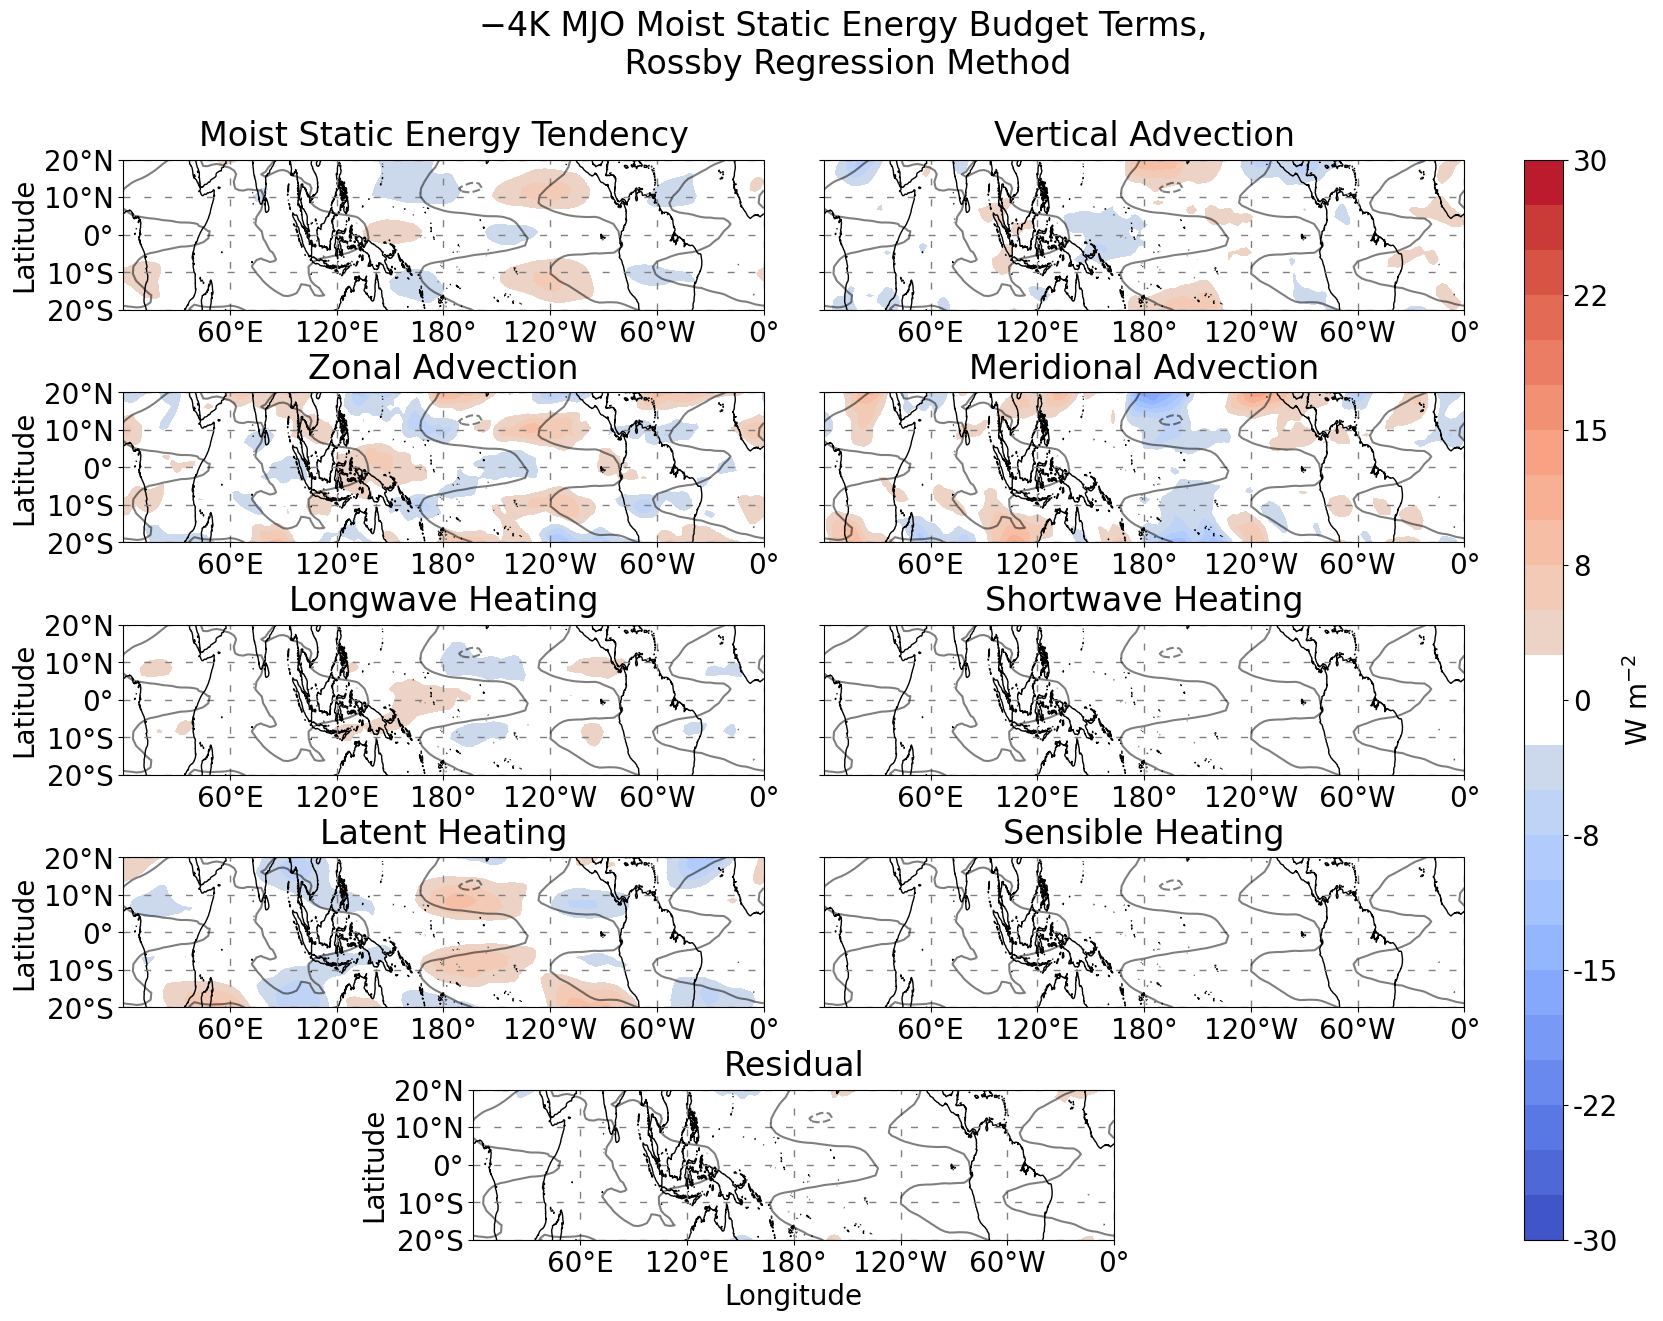

In [47]:
projection_variable = 'Moist Static Energy'
merged_multi_experiment_budget_variables_regressed = xr.merge(
    [
        multi_experiment_budget_variables_regressed['Moist Static Energy'],
        multi_experiment_budget_variables_regressed['Moist Static Energy Tendency'],
        multi_experiment_budget_variables_regressed['Vertical Advection'],
        multi_experiment_budget_variables_regressed['Zonal Advection'],
        multi_experiment_budget_variables_regressed['Meridional Advection'],
        multi_experiment_budget_variables_regressed['Longwave Heating'],
        multi_experiment_budget_variables_regressed['Shortwave Heating'],
        multi_experiment_budget_variables_regressed['Latent Heating'],
        multi_experiment_budget_variables_regressed['Sensible Heating'],
        multi_experiment_budget_variables_regressed['Residual']
    ]
)

latitude_bounds = (-20, 20)

experiment_to_plot = '-4K'
savefig=False

plt.style.use('default')
plt.rcParams.update({'font.size':20})

colormap = 'RdYlBu_r'

fig = plt.figure(figsize=(16, 12))
gs = GridSpec(5, 5, width_ratios=[15,15,15,15,2], figure=fig)
# gs = GridSpec(3, 5, width_ratios=[15,15,15,15,2], figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.55, wspace=0.25)

axes = []
axes.append(fig.add_subplot(gs[0, :2], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[0, 2:4], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[1, :2], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[1, 2:4], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[2, :2], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[2, 2:4], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[3, :2], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[3, 2:4], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[4, 1:3], projection=ccrs.PlateCarree(central_longitude=180)))

cbar_ax = fig.add_subplot(gs[:,-1])

grand_max = round_out(
    merged_multi_experiment_budget_variables_regressed.sel(
        lat=slice(*latitude_bounds)
    ).drop_vars(projection_variable).to_array().max(),
    order=-1
)
grand_min = round_out(
    merged_multi_experiment_budget_variables_regressed.sel(
        lat=slice(*latitude_bounds)
    ).drop_vars(projection_variable).to_array().min(),
    order=-1
)
levels = np.arange(grand_min, grand_max+2.5, 2.5)

fig.suptitle(
    f"{experiments_array.sel(
        experiment=experiment_to_plot
    )['name'].item()} MJO {projection_variable.title()} Budget Terms,\n {mjo_index_method} Regression Method",
    x=0.5,
    y=1.075
)

for ax, (variable_name, variable_data) in zip(
    axes,
    list(
        merged_multi_experiment_budget_variables_regressed.drop_vars(projection_variable).data_vars.items()
    )
):
    [cdata, clon] = cutil.add_cyclic_point(
        variable_data.sel(lat=slice(*latitude_bounds)).sel(experiment=experiment_to_plot),
        variable_data.lon
    )

    ax.set_title(f"{variable_data.name}", pad=10)
    im = ax.contourf(
        clon,
        variable_data.lat.sel(lat=slice(*latitude_bounds)),
        cdata,
        # cmap=colormap,
        cmap=mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05),
        # levels=np.linspace(grand_min, grand_max, 21),
        levels=levels,
        norm=mcolors.CenteredNorm(vcenter=0),
        transform=ccrs.PlateCarree()
    )

    [cmoisture_data, cmoisture_lon] = cutil.add_cyclic_point(
        merged_multi_experiment_budget_variables_regressed[projection_variable].sel(experiment=experiment_to_plot),
        merged_multi_experiment_budget_variables_regressed[projection_variable].lon
    )

    ax.contour(
        cmoisture_lon,
        merged_multi_experiment_budget_variables_regressed[projection_variable].lat,
        cmoisture_data,
        transform=ccrs.PlateCarree(),
        colors='k',
        alpha=0.5,
        levels=7
    )

    if mjo_index_method == 'AK12':
        ax.plot(
            reference_longitude,
            reference_latitude.sel(experiment=experiment_to_plot),
            transform=ccrs.PlateCarree(),
            marker='x',
            color='black',
            ms=10
        )


for index, ax in enumerate(axes):

    ax.set_aspect("auto")
    ax.add_feature(cf.COASTLINE)
    ax.set_xlim(-180, 180)
    # x_ticks = np.arange(0, 360 + 60, 60)
    x_ticks = np.arange(-180, 180 + 60, 60)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(tick_labeller(x_ticks+180, "lon", precision=0))
    ax.xaxis.set_major_locator(mticker.MaxNLocator(7, prune="lower"))

    if index == len(axes)-1:
        ax.set_xlabel("Longitude")

    ax.set_ylim(*latitude_bounds)
    y_ticks = np.arange(latitude_bounds[0], latitude_bounds[1]+10, 10)
    ax.set_yticks(y_ticks)
    if index%2 == 0:
        ax.set_yticklabels(tick_labeller(y_ticks, "lat", precision=0))
        ax.set_ylabel("Latitude")
    else:
        ax.set_yticklabels('')

    grid_kwargs = {"linewidth": 1, "linestyle": (0, (5, 10)), "color": "gray"}
    ax.grid(True, **grid_kwargs)

cbar = fig.colorbar(im, cax=cbar_ax, format='%.0f')
cbar.set_label(r"W m$^{-2}$")
# cbar.set_label(r"10$^{-6}$ $\times$ kg m$^{-2}$ s$^{-1}$")

# Save figure
output_filename = f"{experiment_to_plot}_budget_terms_latlon"
print(f"Output directory: {aquaplanet_output_directory}")
print(f"Output filename: {output_filename}/budget_analysis")
if savefig:
    print(f"{f'Saving...':<{str_width-1}}", end="")
    plt.savefig(
        f"{aquaplanet_output_directory}/budget_analysis/{output_filename}.png",
        dpi=500,
        bbox_inches="tight",
    )
    print(rf"{'✔':>1}")
else:
    print("Not Saving")
    plt.show()

#### Moisture

In [33]:
# multi_experiment_budget_variables_regressed['Column Process'] = (
#     multi_experiment_budget_variables_regressed['Vertical Advection']
#     + multi_experiment_budget_variables_regressed['Precipitation']
#     + + multi_experiment_budget_variables_regressed['Residual']
# )
# multi_experiment_budget_variables_regressed['Column Process'].name = 'Column Process'

multi_experiment_budget_variables_regressed['Precipitation + Vertical Advection'] = (
    multi_experiment_budget_variables_regressed[f'Precipitation']
    + multi_experiment_budget_variables_regressed[f'Vertical Advection']
)
multi_experiment_budget_variables_regressed['Precipitation + Vertical Advection'].name = 'Column Process'
multi_experiment_budget_variables_regressed['Precipitation + Vertical Advection'].attrs['math_name'] = r"$-(P + \langle \omega_\text{MJO} \cdot \partial_p \bar{q} \rangle$)"

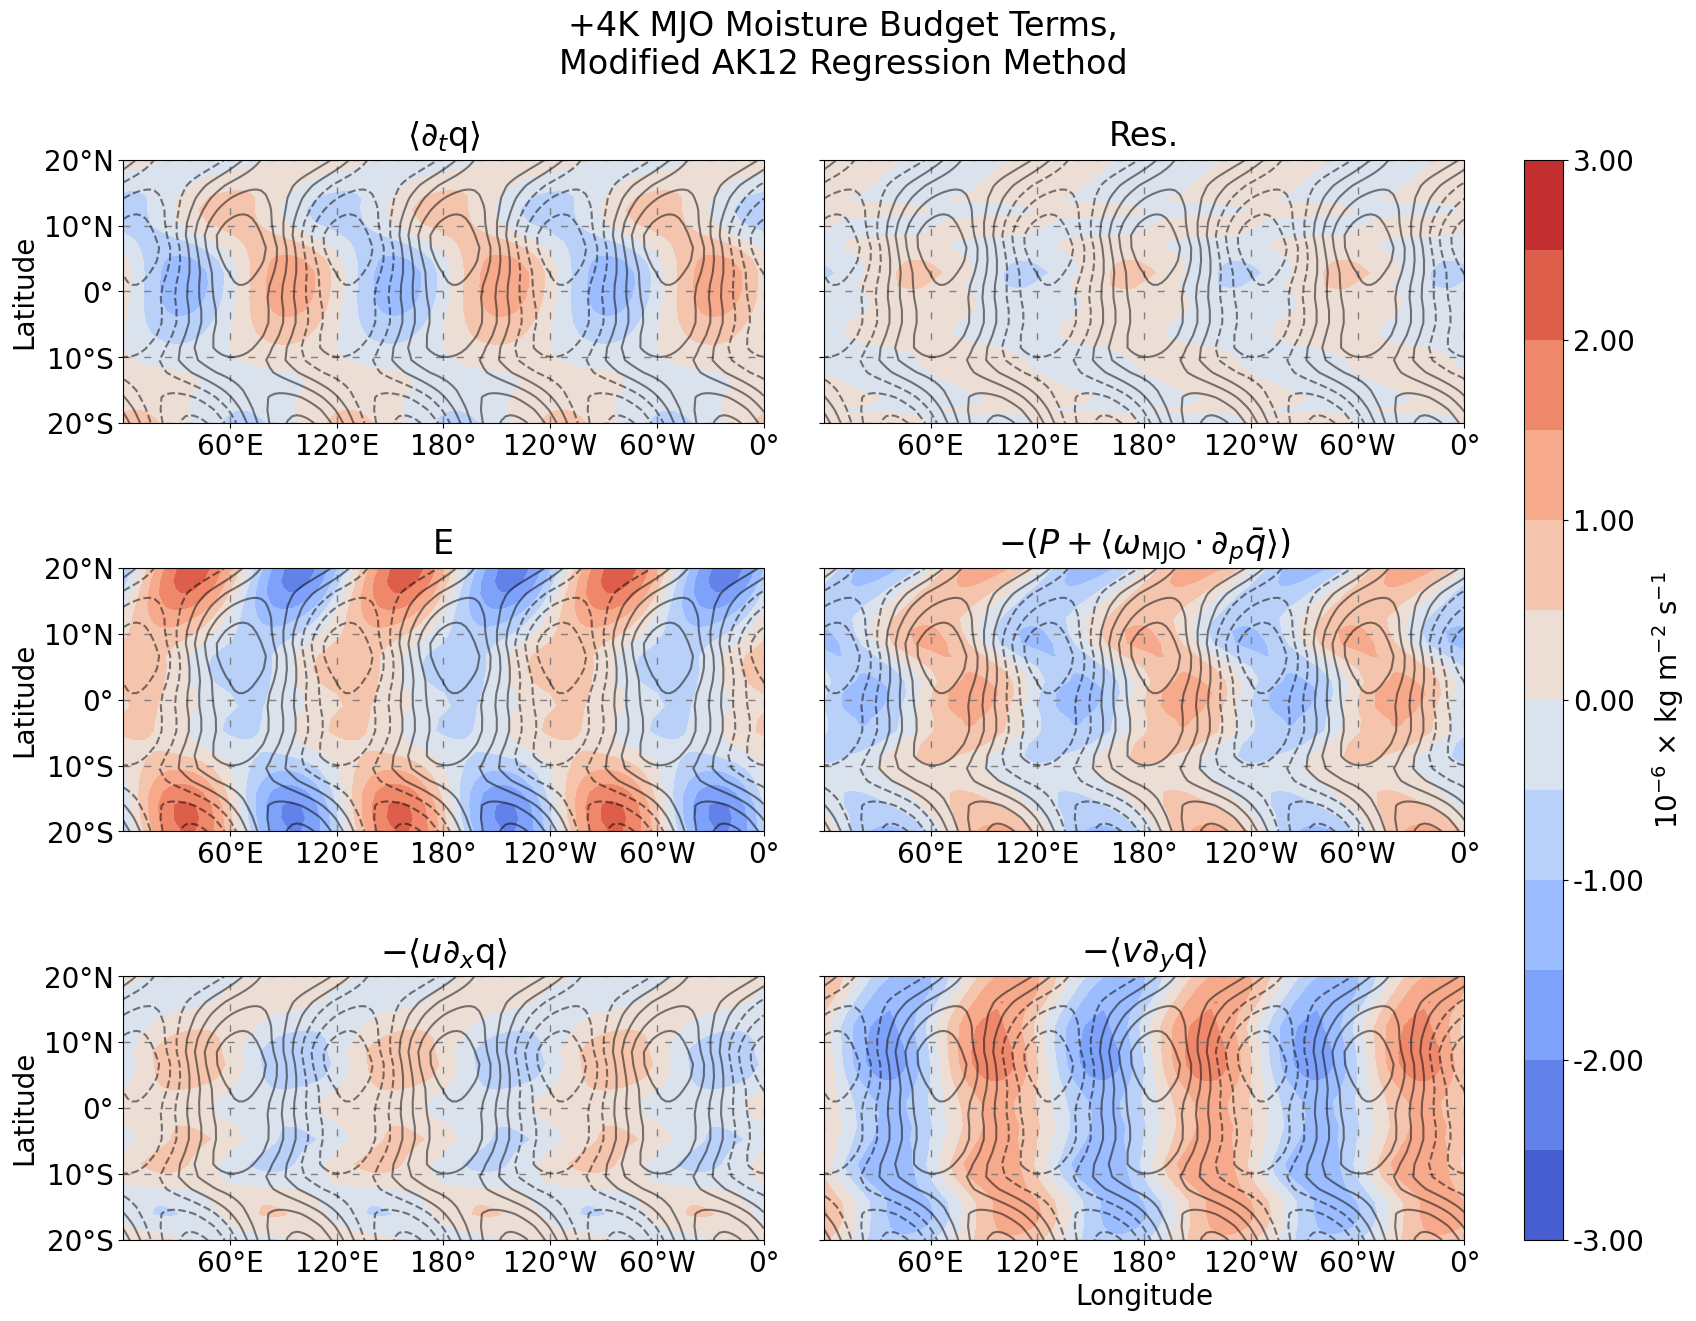

In [48]:
# merged_multi_experiment_budget_variables_regressed = xr.merge(
#     [variable.sel(lat=slice(-15,15)) for variable in multi_experiment_budget_variables_regressed.values()]
# )

# merged_multi_experiment_budget_variables_regressed = xr.merge(
#     [
#         10**6*multi_experiment_budget_variables_regressed['Moisture'].sel(zonal_wavenumber=0),
#         10**6*multi_experiment_budget_variables_regressed['Moisture Tendency'].sel(zonal_wavenumber=0),
#         10**6*multi_experiment_budget_variables_regressed['Residual'].sel(zonal_wavenumber=0),
#         10**6*multi_experiment_budget_variables_regressed['Evaporation'].sel(zonal_wavenumber=0),
#         10**6*multi_experiment_budget_variables_regressed['Precipitation + Vertical Advection'].sel(zonal_wavenumber=0),
#         10**6*multi_experiment_budget_variables_regressed['Zonal Advection Mean wind MJO moisture'].sel(zonal_wavenumber=0),
#         10**6*multi_experiment_budget_variables_regressed['Meridional Advection MJO wind mean moisture'].sel(zonal_wavenumber=0),
#         10**6*multi_experiment_budget_variables_regressed['Zonal Advection Residual wind residual moisture'].sel(zonal_wavenumber=0),
#         10**6*multi_experiment_budget_variables_regressed['Meridional Advection Residual wind residual moisture'].sel(zonal_wavenumber=0),
#         # 10**6*multi_experiment_budget_variables_regressed['Vertical Advection MJO wind mean moisture'].sel(zonal_wavenumber=0),

#     ]
# )

experiment_to_plot = '4K'
k_to_plot = 3

merged_multi_experiment_budget_variables_regressed = xr.merge(
    [
        10**6*multi_experiment_budget_variables_regressed['Moisture'].sel(zonal_wavenumber=k_to_plot),
        10**6*multi_experiment_budget_variables_regressed['Moisture Tendency'].sel(zonal_wavenumber=k_to_plot),
        10**6*multi_experiment_budget_variables_regressed['Residual'].sel(zonal_wavenumber=k_to_plot),
        10**6*multi_experiment_budget_variables_regressed['Evaporation'].sel(zonal_wavenumber=k_to_plot),
        10**6*multi_experiment_budget_variables_regressed['Precipitation + Vertical Advection'].sel(zonal_wavenumber=k_to_plot),
        10**6*multi_experiment_budget_variables_regressed['Zonal Advection'].sel(zonal_wavenumber=k_to_plot),
        10**6*multi_experiment_budget_variables_regressed['Meridional Advection'].sel(zonal_wavenumber=k_to_plot),
    ]
)

savefig=False

plt.style.use('default')
plt.rcParams.update({'font.size':20})

latitude_bounds = (-20,20)
colormap = 'RdYlBu_r'

fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 5, width_ratios=[15,15,15,15,2], figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.55, wspace=0.25)

axes = []
axes.append(fig.add_subplot(gs[0, :2], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[0, 2:4], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[1, :2], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[1, 2:4], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[2, :2], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[2, 2:4], projection=ccrs.PlateCarree(central_longitude=180)))
# axes.append(fig.add_subplot(gs[3, :2], projection=ccrs.PlateCarree(central_longitude=180)))
# axes.append(fig.add_subplot(gs[3, 2:4], projection=ccrs.PlateCarree(central_longitude=180)))
# axes.append(fig.add_subplot(gs[4, 1:3], projection=ccrs.PlateCarree(central_longitude=180)))

cbar_ax = fig.add_subplot(gs[:,-1])

grand_max = round_out(
    merged_multi_experiment_budget_variables_regressed.sel(
        lat=slice(*latitude_bounds)
    ).drop_vars(projection_variable).to_array().max(),
    order=0
)
grand_min = round_out(
    merged_multi_experiment_budget_variables_regressed.sel(
        lat=slice(*latitude_bounds)
    ).drop_vars(projection_variable).to_array().min(),
    order=0
)
levels = np.arange(grand_min, grand_max+0.5, 0.5)

fig.suptitle(
    f"{experiments_array.sel(
        experiment=experiment_to_plot
    )['name'].item()} MJO {projection_variable.title()} Budget Terms,\n{mjo_index_method} Regression Method",
    x=0.5,
    y=1.075
)

for ax, (variable_name, variable_data) in zip(
    axes,
    list(
        merged_multi_experiment_budget_variables_regressed.drop_vars(projection_variable).data_vars.items()
    )
):
    [cdata, clon] = cutil.add_cyclic_point(
        variable_data.sel(lat=slice(*latitude_bounds)).sel(experiment=experiment_to_plot),
        variable_data.lon
    )

    ax.set_title(f"{variable_data.attrs['math_name']}", pad=10)
    im = ax.contourf(
        clon,
        variable_data.lat.sel(lat=slice(*latitude_bounds)),
        cdata,
        # cmap=colormap,
        cmap=mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05),
        # levels=np.linspace(grand_min, grand_max, 21),
        levels=levels,
        norm=mcolors.CenteredNorm(vcenter=0),
        transform=ccrs.PlateCarree()
    )

    [cmoisture_data, cmoisture_lon] = cutil.add_cyclic_point(
        merged_multi_experiment_budget_variables_regressed[projection_variable].sel(experiment=experiment_to_plot),
        merged_multi_experiment_budget_variables_regressed[projection_variable].lon
    )

    ax.contour(
        cmoisture_lon,
        merged_multi_experiment_budget_variables_regressed[projection_variable].lat,
        cmoisture_data,
        transform=ccrs.PlateCarree(),
        colors='k',
        alpha=0.5,
        levels=7
    )

    if mjo_index_method == 'AK12':
        ax.plot(
            reference_longitude,
            reference_latitude.sel(experiment=experiment_to_plot),
            transform=ccrs.PlateCarree(),
            marker='x',
            color='black',
            ms=10
        )


for index, ax in enumerate(axes):

    ax.set_aspect("auto")
    # ax.add_feature(cf.COASTLINE)
    ax.set_xlim(-180, 180)
    # x_ticks = np.arange(0, 360 + 60, 60)
    x_ticks = np.arange(-180, 180 + 60, 60)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(tick_labeller(x_ticks+180, "lon", precision=0))
    ax.xaxis.set_major_locator(mticker.MaxNLocator(7, prune="lower"))

    if index == len(axes)-1:
        ax.set_xlabel("Longitude")

    ax.set_ylim(*latitude_bounds)
    # y_ticks = np.arange(-30, 45, 15)
    # ax.set_ylim(-15, 15)
    y_ticks = np.arange(latitude_bounds[0], latitude_bounds[1]+10, 10)
    ax.set_yticks(y_ticks)
    if index%2 == 0:
        ax.set_yticklabels(tick_labeller(y_ticks, "lat", precision=0))
        ax.set_ylabel("Latitude")
    else:
        ax.set_yticklabels('')

    grid_kwargs = {"linewidth": 1, "linestyle": (0, (5, 10)), "color": "gray"}
    ax.grid(True, **grid_kwargs)

cbar = fig.colorbar(im, cax=cbar_ax, format='%.2f')
# cbar.set_label(r"W m$^{-2}$")
cbar.set_label(r"10$^{-6}$ $\times$ kg m$^{-2}$ s$^{-1}$")

# Save figure
output_filename = f"{experiment_to_plot}_budget_terms_latlon"
print(f"Output directory: {aquaplanet_output_directory}")
print(f"Output filename: {output_filename}/budget_analysis")
if savefig:
    print(f"{f'Saving...':<{str_width-1}}", end="")
    plt.savefig(
        f"{aquaplanet_output_directory}/budget_analysis/{output_filename}.png",
        dpi=500,
        bbox_inches="tight",
    )
    print(rf"{'✔':>1}")
else:
    print("Not Saving")
    plt.show()

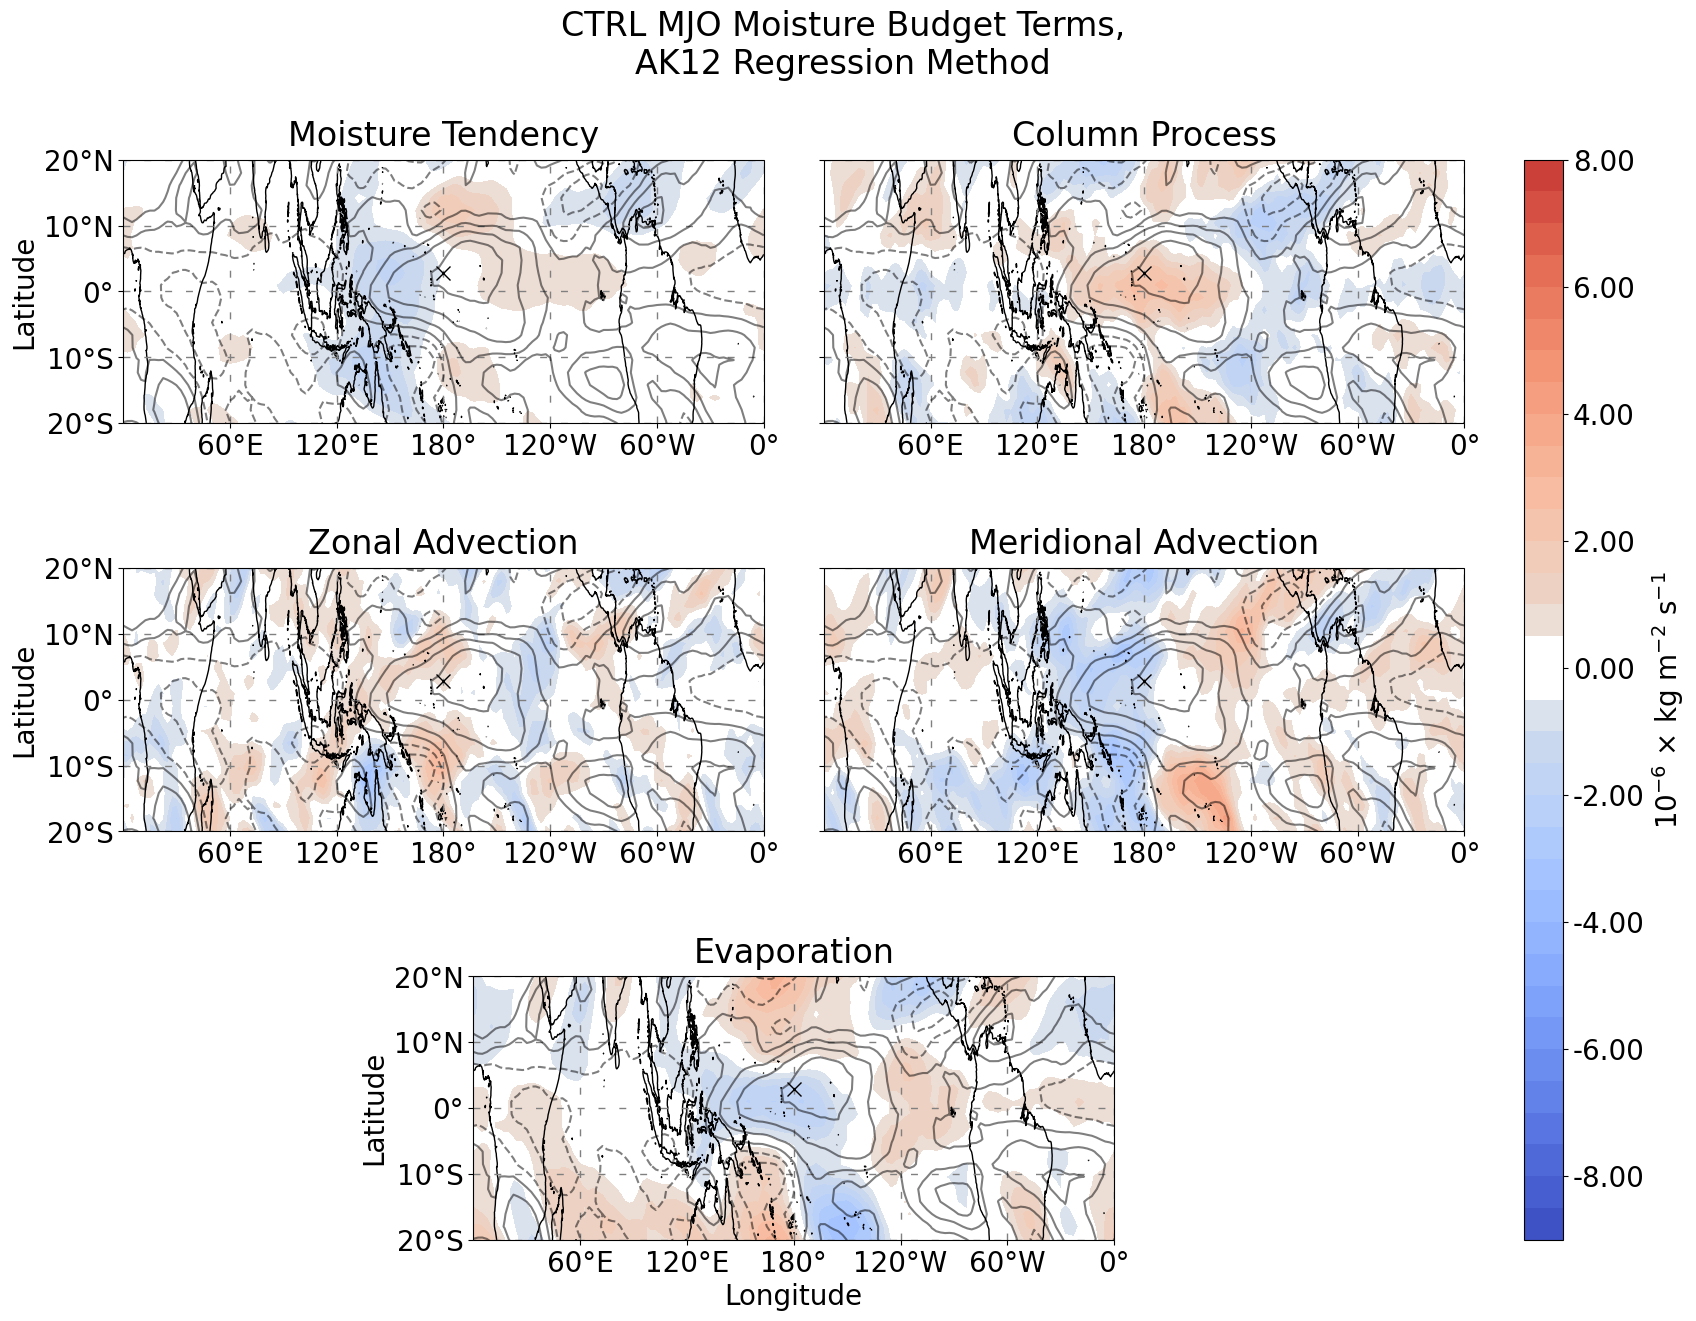

In [43]:
# merged_multi_experiment_budget_variables_regressed = xr.merge(
#     [variable.sel(lat=slice(-15,15)) for variable in multi_experiment_budget_variables_regressed.values()]
# )

merged_multi_experiment_budget_variables_regressed = xr.merge(
    [
        # 10**6*multi_experiment_budget_variables_regressed['Moisture'],
        # 10**6*multi_experiment_budget_variables_regressed['Moisture Tendency'],
        # 10**6*multi_experiment_budget_variables_regressed['Column Process'],
        # 10**6*multi_experiment_budget_variables_regressed['Zonal Advection'],
        # 10**6*multi_experiment_budget_variables_regressed['Meridional Advection'],
        # 10**6*multi_experiment_budget_variables_regressed['Evaporation'],
        # 10**6*multi_experiment_budget_variables_regressed['Residual'],
        10**6*multi_experiment_budget_variables_regressed['Moisture'],
        10**6*multi_experiment_budget_variables_regressed['Moisture Tendency'],
        10**6*multi_experiment_budget_variables_regressed['Evaporation'],
        10**6*multi_experiment_budget_variables_regressed['Precipitation + Vertical Advection'],
        10**6*multi_experiment_budget_variables_regressed['Zonal Advection Mean wind mjo moisture'],
        10**6*multi_experiment_budget_variables_regressed['Zonal Advection Residual wind residual moisture'],
        10**6*multi_experiment_budget_variables_regressed['Meridional Advection MJO wind mean moisture'],
        10**6*multi_experiment_budget_variables_regressed['Meridional Advection Residual wind residual moisture'],
        10**6*multi_experiment_budget_variables_regressed['Vertical Advection Mean wind mjo moisture'],
        10**6*multi_experiment_budget_variables_regressed['Residual'],
    ]
)

experiment_to_plot = '0K'
savefig=False

plt.style.use('default')
plt.rcParams.update({'font.size':20})

latitude_bounds = (-20,20)
colormap = 'RdYlBu_r'

fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 5, width_ratios=[15,15,15,15,2], figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.55, wspace=0.25)

axes = []
axes.append(fig.add_subplot(gs[0, :2], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[0, 2:4], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[1, :2], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[1, 2:4], projection=ccrs.PlateCarree(central_longitude=180)))
# axes.append(fig.add_subplot(gs[2, :2], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[2, 1:3], projection=ccrs.PlateCarree(central_longitude=180)))

cbar_ax = fig.add_subplot(gs[:,-1])

grand_max = round_out(
    merged_multi_experiment_budget_variables_regressed.sel(
        lat=slice(*latitude_bounds)
    ).drop_vars(projection_variable).to_array().max(),
    order=0
)
grand_min = round_out(
    merged_multi_experiment_budget_variables_regressed.sel(
        lat=slice(*latitude_bounds)
    ).drop_vars(projection_variable).to_array().min(),
    order=0
)
levels = np.arange(grand_min, grand_max+0.5, 0.5)

fig.suptitle(
    f"{experiments_array.sel(
        experiment=experiment_to_plot
    )['name'].item()} MJO {projection_variable.title()} Budget Terms,\n{mjo_index_method} Regression Method",
    x=0.5,
    y=1.075
)

for ax, (variable_name, variable_data) in zip(
    axes,
    list(
        merged_multi_experiment_budget_variables_regressed.drop_vars(projection_variable).data_vars.items()
    )
):
    [cdata, clon] = cutil.add_cyclic_point(
        variable_data.sel(lat=slice(*latitude_bounds)).sel(experiment=experiment_to_plot),
        variable_data.lon
    )

    ax.set_title(f"{variable_data.name}", pad=10)
    im = ax.contourf(
        clon,
        variable_data.lat.sel(lat=slice(*latitude_bounds)),
        cdata,
        # cmap=colormap,
        cmap=mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05),
        # levels=np.linspace(grand_min, grand_max, 21),
        levels=levels,
        norm=mcolors.CenteredNorm(vcenter=0),
        transform=ccrs.PlateCarree()
    )

    [cmoisture_data, cmoisture_lon] = cutil.add_cyclic_point(
        merged_multi_experiment_budget_variables_regressed[projection_variable].sel(experiment=experiment_to_plot),
        merged_multi_experiment_budget_variables_regressed[projection_variable].lon
    )

    ax.contour(
        cmoisture_lon,
        merged_multi_experiment_budget_variables_regressed[projection_variable].lat,
        cmoisture_data,
        transform=ccrs.PlateCarree(),
        colors='k',
        alpha=0.5,
        levels=7
    )

    if mjo_index_method == 'AK12':
        ax.plot(
            reference_longitude,
            reference_latitude.sel(experiment=experiment_to_plot),
            transform=ccrs.PlateCarree(),
            marker='x',
            color='black',
            ms=10
        )


for index, ax in enumerate(axes):

    ax.set_aspect("auto")
    ax.add_feature(cf.COASTLINE)
    ax.set_xlim(-180, 180)
    # x_ticks = np.arange(0, 360 + 60, 60)
    x_ticks = np.arange(-180, 180 + 60, 60)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(tick_labeller(x_ticks+180, "lon", precision=0))
    ax.xaxis.set_major_locator(mticker.MaxNLocator(7, prune="lower"))

    if index == len(axes)-1:
        ax.set_xlabel("Longitude")

    ax.set_ylim(*latitude_bounds)
    # y_ticks = np.arange(-30, 45, 15)
    # ax.set_ylim(-15, 15)
    y_ticks = np.arange(latitude_bounds[0], latitude_bounds[1]+10, 10)
    ax.set_yticks(y_ticks)
    if index%2 == 0:
        ax.set_yticklabels(tick_labeller(y_ticks, "lat", precision=0))
        ax.set_ylabel("Latitude")
    else:
        ax.set_yticklabels('')

    grid_kwargs = {"linewidth": 1, "linestyle": (0, (5, 10)), "color": "gray"}
    ax.grid(True, **grid_kwargs)

cbar = fig.colorbar(im, cax=cbar_ax, format='%.2f')
# cbar.set_label(r"W m$^{-2}$")
cbar.set_label(r"10$^{-6}$ $\times$ kg m$^{-2}$ s$^{-1}$")

# Save figure
output_filename = f"{experiment_to_plot}_budget_terms_latlon"
print(f"Output directory: {aquaplanet_output_directory}")
print(f"Output filename: {output_filename}/budget_analysis")
if savefig:
    print(f"{f'Saving...':<{str_width-1}}", end="")
    plt.savefig(
        f"{aquaplanet_output_directory}/budget_analysis/{output_filename}.png",
        dpi=500,
        bbox_inches="tight",
    )
    print(rf"{'✔':>1}")
else:
    print("Not Saving")
    plt.show()

### Estimated evaporation

In [105]:
experiments_list = ['-4K', '0K', '4K']

variables_to_load = [
    "PS",
    "T",
    "Q",
    "U",
    "V",
    "LHFLX"
]

if 'multi_experiment_variables_loaded' in locals():
    multi_experiment_variables_loaded = load_multi_experiment_daily_model_level_data(
        variables_to_load,
        multi_experiment_variables_loaded
    )
else:
    multi_experiment_variables_loaded = load_multi_experiment_daily_model_level_data(
        variables_to_load,
    )

hyam = xr.open_dataset(f"{data_directory}/model_parameter_data/SST_AQP3_Qobs_27_hyam.nc")['hyam']
hybm = xr.open_dataset(f"{data_directory}/model_parameter_data/SST_AQP3_Qobs_27_hybm.nc")['hybm']
P0 = xr.open_dataset(f"{data_directory}/model_parameter_data/SST_AQP3_Qobs_27_P0.nc")['P0']

surface_pressure = multi_experiment_variables_loaded['PS']
pressure_array = hyam*P0 + hybm*surface_pressure
pressure_array = pressure_array.transpose("experiment", "time", "lev", "lat", "lon")

print(f"{f'Estimate Evaporation from Bulk Parameterization':^{str_width}}")
print(f"{'='*str_width}")

print(f"{f'Air Density...':<{str_width-1}}", end="")
air_density = pressure_array.isel(lev=-1)/(DRY_AIR_GAS_CONSTANT*multi_experiment_variables_loaded['T'].isel(lev=-1))
print(rf"{'✔':>1}")

print(f"{f'Surface Wind Magnitude...':<{str_width-1}}", end="")
surface_wind_magnitude = xr.zeros_like(multi_experiment_variables_loaded['U'].isel(lev=-1, drop=True))
surface_wind_magnitude[:] = 0.5*np.sqrt((multi_experiment_variables_loaded['U'].isel(lev=-1)**2 + multi_experiment_variables_loaded['V'].isel(lev=-1)**2))
surface_wind_magnitude.name = 'Surface Wind Magnitude'
print(rf"{'✔':>1}")

print(f"{f'Specific Humidity Gradient...':<{str_width-1}}", end="")
sea_surface_temperature = np.zeros_like(surface_wind_magnitude.lat)
sea_surface_temperature[np.abs(surface_wind_magnitude.lat) <= 60] = 27*(
    1
    - 0.5*(np.sin(np.pi*surface_wind_magnitude.lat[np.abs(surface_wind_magnitude.lat) <= 60]/120)**2)
    - 0.5*(np.sin(np.pi*surface_wind_magnitude.lat[np.abs(surface_wind_magnitude.lat) <= 60]/120)**4)
)

multi_experiment_sea_surface_temperature = xr.zeros_like(surface_wind_magnitude)
multi_experiment_sea_surface_temperature[0, :, :] = (sea_surface_temperature[:, np.newaxis] -4) + 273.15
multi_experiment_sea_surface_temperature[1, :, :] = (sea_surface_temperature[:, np.newaxis] ) + 273.15
multi_experiment_sea_surface_temperature[2, :, :] = (sea_surface_temperature[:, np.newaxis] +4) + 273.15

saturation_vapor_pressure = 6.112 * np.exp(
    (17.67*(multi_experiment_sea_surface_temperature-273.15))
    / (multi_experiment_sea_surface_temperature - 29.65)
)

epsilon = 0.6219569100577033
surface_saturation_specific_humidity = (HEAT_OF_VAPORIZATION/SPECIFIC_HEAT)*epsilon*saturation_vapor_pressure/pressure_array.isel(lev=-1)
surface_saturation_specific_humidity.name = 'Surface Saturation Specific Humidity'
surface_saturation_specific_humidity.attrs['units'] = 'kg/kg'
surface_saturation_specific_humidity.attrs['long_name'] = 'Surface Saturation Specific Humidity'

surface_specific_humidity = multi_experiment_variables_loaded['Q'].isel(lev=-1)
surface_specific_humidity.name = 'Surface Specific Humidity'
surface_specific_humidity.attrs['units'] = 'kg/kg'
surface_specific_humidity.attrs['long_name'] = 'Surface Specific Humidity'

specific_humidity_gradient =  surface_specific_humidity - surface_saturation_specific_humidity
print(rf"{'✔':>1}")

print(f"{f'Estimated Evaporation...':<{str_width-1}}", end="")
estimated_evaporation = air_density*specific_humidity_gradient*surface_wind_magnitude
estimated_evaporation.name = 'Estimated Evaporation'
estimated_evaporation.attrs['units'] = r'kg m$^{-2}$ s$^{-1}$'
estimated_evaporation.attrs['long_name'] = 'Estimated Evaporation'
print(rf"{'✔':>1}")

print(f"{'='*str_width}")
print("Finished")

     Loading daily model-level data     
(1/6) PS...                             
----------------------------------------
Variable already loaded
(2/6) T...                              
----------------------------------------
Variable already loaded
(3/6) Q...                              
----------------------------------------
Variable already loaded
(4/6) U...                              
----------------------------------------
Variable already loaded
(5/6) V...                              
----------------------------------------
Variable already loaded
(6/6) LHFLX...                          
----------------------------------------
Variable already loaded
----------------------------------------
Data Loaded
Estimate Evaporation from Bulk Parameterization
Air Density...                         ✔
Surface Wind Magnitude...              ✔
Specific Humidity Gradient...          ✔
Estimated Evaporation...               ✔
Finished


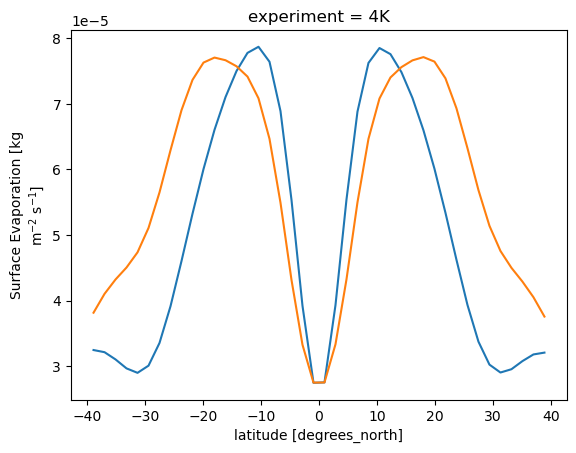

In [66]:
(-2.25*10**(-5)*estimated_evaporation).sel(experiment='4K').mean(dim=['time', 'lon']).plot()
# plt.figure()
multi_experiment_budget_variables_subset['Evaporation'].sel(experiment='4K').mean(dim=['time', 'lon']).plot()
constant = -2.25*10**(-5)
estimated_mean_latent_heat_flux = (constant*estimated_evaporation).mean(dim='time')

In [91]:
# mean_evaporation = estimated_evaporation.mean(dim='time')
mean_wind = surface_wind_magnitude.mean(dim='time')
anomalous_wind = surface_wind_magnitude - mean_wind
anomalous_wind.name = 'Wind Term'

mean_specific_humidity = surface_specific_humidity.mean(dim='time')
anomalous_specific_humidity = surface_specific_humidity - mean_specific_humidity
anomalous_specific_humidity.name = 'Specific Humidity'

mean_saturation_specific_humidity = surface_saturation_specific_humidity.mean(dim='time')
anomalous_saturation_specific_humidity = surface_saturation_specific_humidity - mean_saturation_specific_humidity
anomalous_saturation_specific_humidity.name = 'Saturation Specific Humidity'

mean_evaporation = constant*air_density*mean_wind*(mean_saturation_specific_humidity - mean_specific_humidity)
mean_evaporation.name = 'Mean Evaporation'
mean_evaporation.attrs['units'] = 'kg/m2/s'

wind_term = constant*air_density*anomalous_wind*(mean_saturation_specific_humidity - mean_specific_humidity)
wind_term.name = 'Wind Term'
wind_term.attrs['long_name'] = 'Wind-Driven Evaporation Anomalies'
wind_term.attrs['units'] = 'kg/m2/s'

specific_humidity_term = -constant*air_density*mean_wind*anomalous_specific_humidity
specific_humidity_term.name = 'Specific Humidity Term'
specific_humidity_term.attrs['long_name'] = 'Specific Humidity-Driven Evaporation Anomalies'
specific_humidity_term.attrs['units'] = 'kg/m2/s'

saturation_term = constant*air_density*mean_wind*anomalous_saturation_specific_humidity
saturation_term.name = 'Saturation Term'
saturation_term.attrs['long_name'] = 'Saturation Specific Humidity-Driven Evaporation Anomalies'
saturation_term.attrs['units'] = 'kg/m2/s'

estimated_evaporation = mean_evaporation + wind_term + specific_humidity_term + saturation_term
estimated_evaporation.name = 'Estimated Evaporation'
estimated_evaporation.attrs['long_name'] = 'Estimated Evaporation Anomalies'
estimated_evaporation.attrs['units'] = 'kg/m2/s'

In [99]:
wind_term.max()

<xarray.DataArray 'Wind Term' ()> Size: 8B
array(7.85299463e-05)
Coordinates:
    lev      float64 8B 992.6
Attributes:
    long_name:  Wind-Driven Evaporation Anomalies
    units:      kg/m2/s

In [106]:
regressed_data = {}
for variable_data in [
    # wind_term,
    # specific_humidity_term,
    # saturation_term,
    # estimated_evaporation,
    surface_wind_magnitude,
    surface_saturation_specific_humidity,
    surface_specific_humidity
]:
    variable_data_anomalies = standardize_data(variable_data, unit_variance=False, dim='time')

    variable_data_anomalies = variable_data_anomalies.resample(time='D').mean().sel(
        time=slice(standardized_reference_timeseries.time[0], standardized_reference_timeseries.time[-1])
    ).drop_sel(time=missing_days, errors='ignore')

    # Regress the variable anomalies onto the reference timeseries
    regressed_data[variable_data.name] = xr.dot(
        standardized_reference_timeseries,
        variable_data_anomalies,
        dim='time'
    ) / len(standardized_reference_timeseries.time)
    regressed_data[variable_data.name].attrs = variable_data.attrs


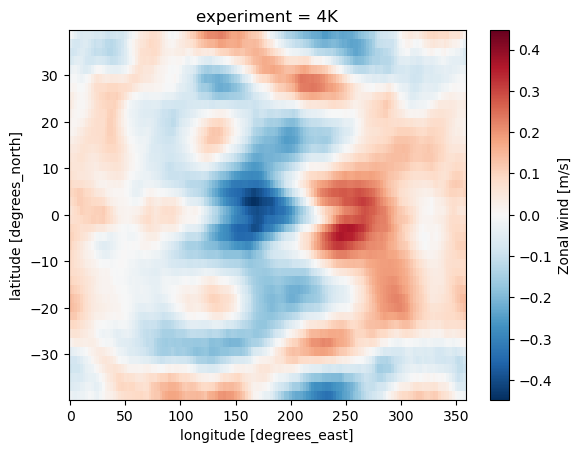

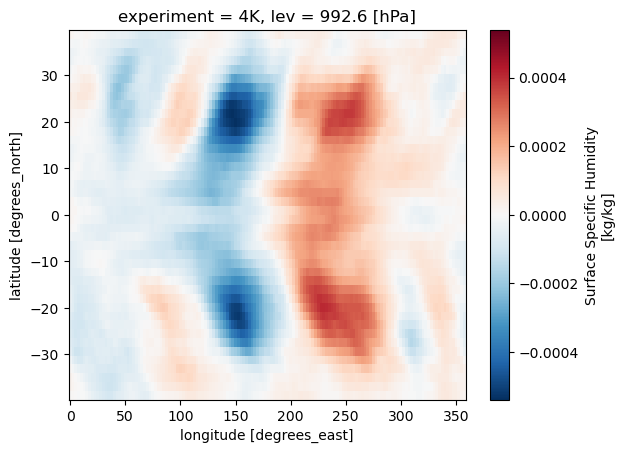

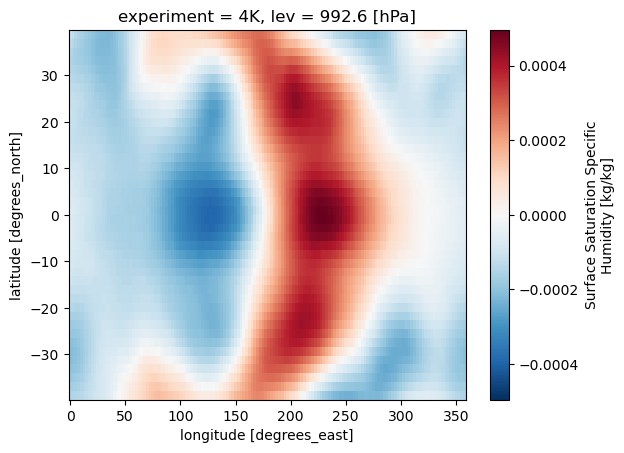

In [107]:
regressed_data['Surface Wind Magnitude'].sel(experiment='4K').plot()
plt.figure()
regressed_data['Surface Specific Humidity'].sel(experiment='4K').plot()
plt.figure()
regressed_data['Surface Saturation Specific Humidity'].sel(experiment='4K').plot()

In [121]:
# mean_evaporation = estimated_evaporation.mean(dim='time')
mean_wind = surface_wind_magnitude.mean(dim='time')
mean_specific_humidity = surface_specific_humidity.mean(dim='time')
mean_saturation_specific_humidity = surface_saturation_specific_humidity.mean(dim='time')

mean_evaporation = constant*air_density.mean(dim='time')*mean_wind*(mean_saturation_specific_humidity - mean_specific_humidity)
mean_evaporation.name = 'Mean Evaporation'
mean_evaporation.attrs['units'] = 'kg/m2/s'

wind_term = constant*air_density.mean(dim='time')*regressed_data['Surface Wind Magnitude']*(mean_saturation_specific_humidity - mean_specific_humidity)
wind_term.name = 'Wind Term'
wind_term.attrs['long_name'] = 'Wind-Driven Evaporation Anomalies'
wind_term.attrs['units'] = 'kg/m2/s'

specific_humidity_term = -constant*air_density.mean(dim='time')*mean_wind*regressed_data['Surface Specific Humidity']
specific_humidity_term.name = 'Specific Humidity Term'
specific_humidity_term.attrs['long_name'] = 'Specific Humidity-Driven Evaporation Anomalies'
specific_humidity_term.attrs['units'] = 'kg/m2/s'

saturation_term = constant*air_density.mean(dim='time')*mean_wind*regressed_data['Surface Saturation Specific Humidity']
saturation_term.name = 'Saturation Term'
saturation_term.attrs['long_name'] = 'Saturation Specific Humidity-Driven Evaporation Anomalies'
saturation_term.attrs['units'] = 'kg/m2/s'

estimated_evaporation = mean_evaporation + wind_term + specific_humidity_term + saturation_term
estimated_evaporation.name = 'Estimated Evaporation'
estimated_evaporation.attrs['long_name'] = 'Estimated Evaporation Anomalies'
estimated_evaporation.attrs['units'] = 'kg/m2/s'

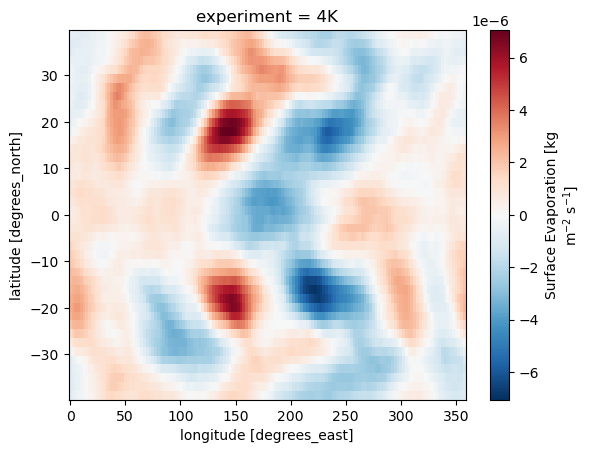

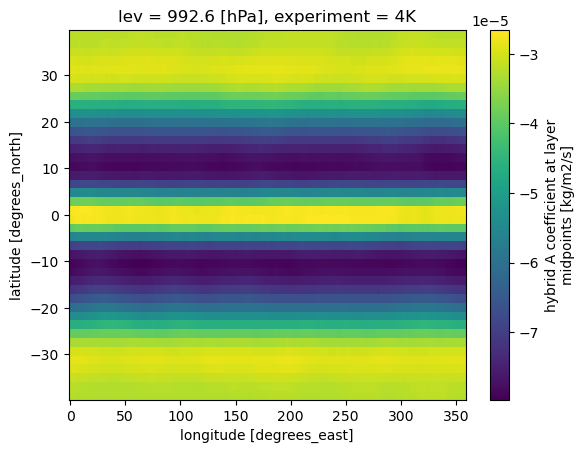

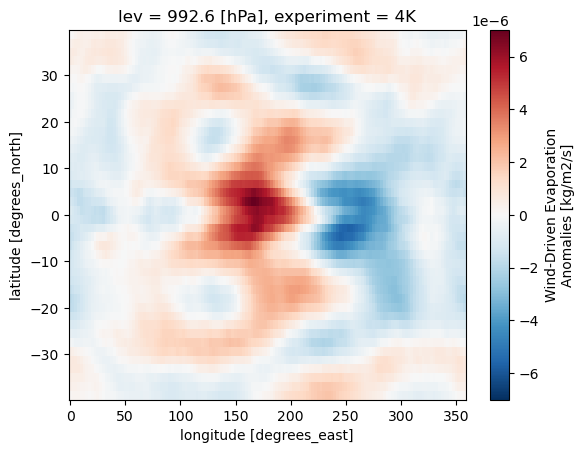

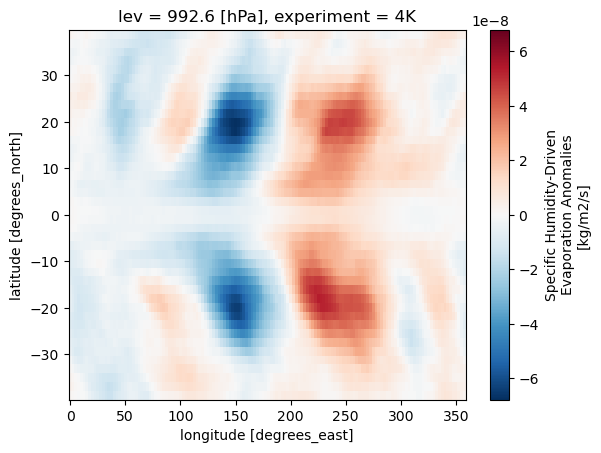

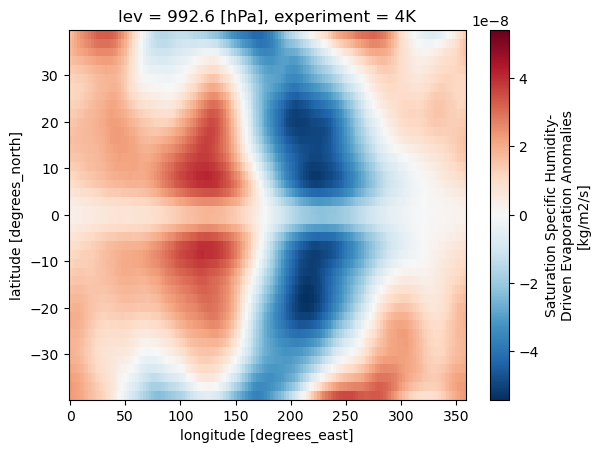

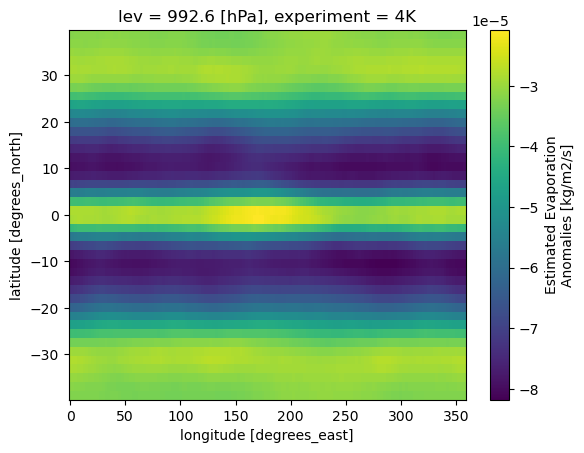

In [124]:
experiment = '4K'
multi_experiment_budget_variables_regressed['Evaporation'].sel(experiment=experiment).plot()
plt.figure()
mean_evaporation.sel(experiment=experiment).plot()
plt.figure()
wind_term.sel(experiment=experiment).plot()
plt.figure()
specific_humidity_term.sel(experiment=experiment).plot()
plt.figure()
saturation_term.sel(experiment=experiment).plot()
plt.figure()
estimated_evaporation.sel(experiment=experiment).plot()

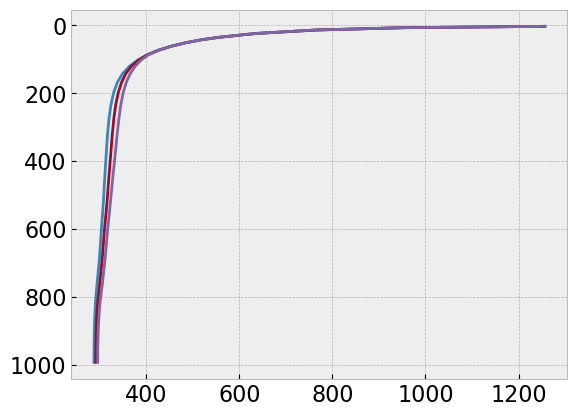

In [55]:
plt.figure()
for experiment in experiments_list:
    plt.plot(
        potential_temperature.sel(experiment=experiment).mean(dim=['time', 'lat', 'lon']),
        potential_temperature.lev
    )
plt.gca().invert_yaxis()
plt.show()

In [25]:
for (variable_name, variable_data) in zip(
    ['Surface Wind Magnitude', 'Specific Humidity Gradient', 'Zonal Wind', 'Meridional Wind', 'Estimated Evaporation'],
    [surface_wind_magnitude, specific_humidity_gradient, multi_experiment_variables_loaded['U'].isel(lev=-1), multi_experiment_variables_loaded['V'].isel(lev=-1), estimated_evaporation]
):
    print(f"{variable_name}")
    variable_data_anomalies = standardize_data(variable_data, unit_variance=False, dim='time')

    multi_experiment_budget_variables_regressed[variable_name] = xr.dot(
            standardized_reference_timeseries,
            variable_data_anomalies,
            dim='time'
        ) / len(standardized_reference_timeseries.time)
    multi_experiment_budget_variables_regressed[variable_name].attrs = variable_data_anomalies.attrs
    multi_experiment_budget_variables_regressed[variable_name].attrs['Regression Method'] = mjo_index_method
    multi_experiment_budget_variables_regressed[variable_name].name = variable_name

print(f"{'='*str_width}")
print("Finished")

Surface Wind Magnitude
Specific Humidity Gradient
Zonal Wind
Meridional Wind
Estimated Evaporation
Finished


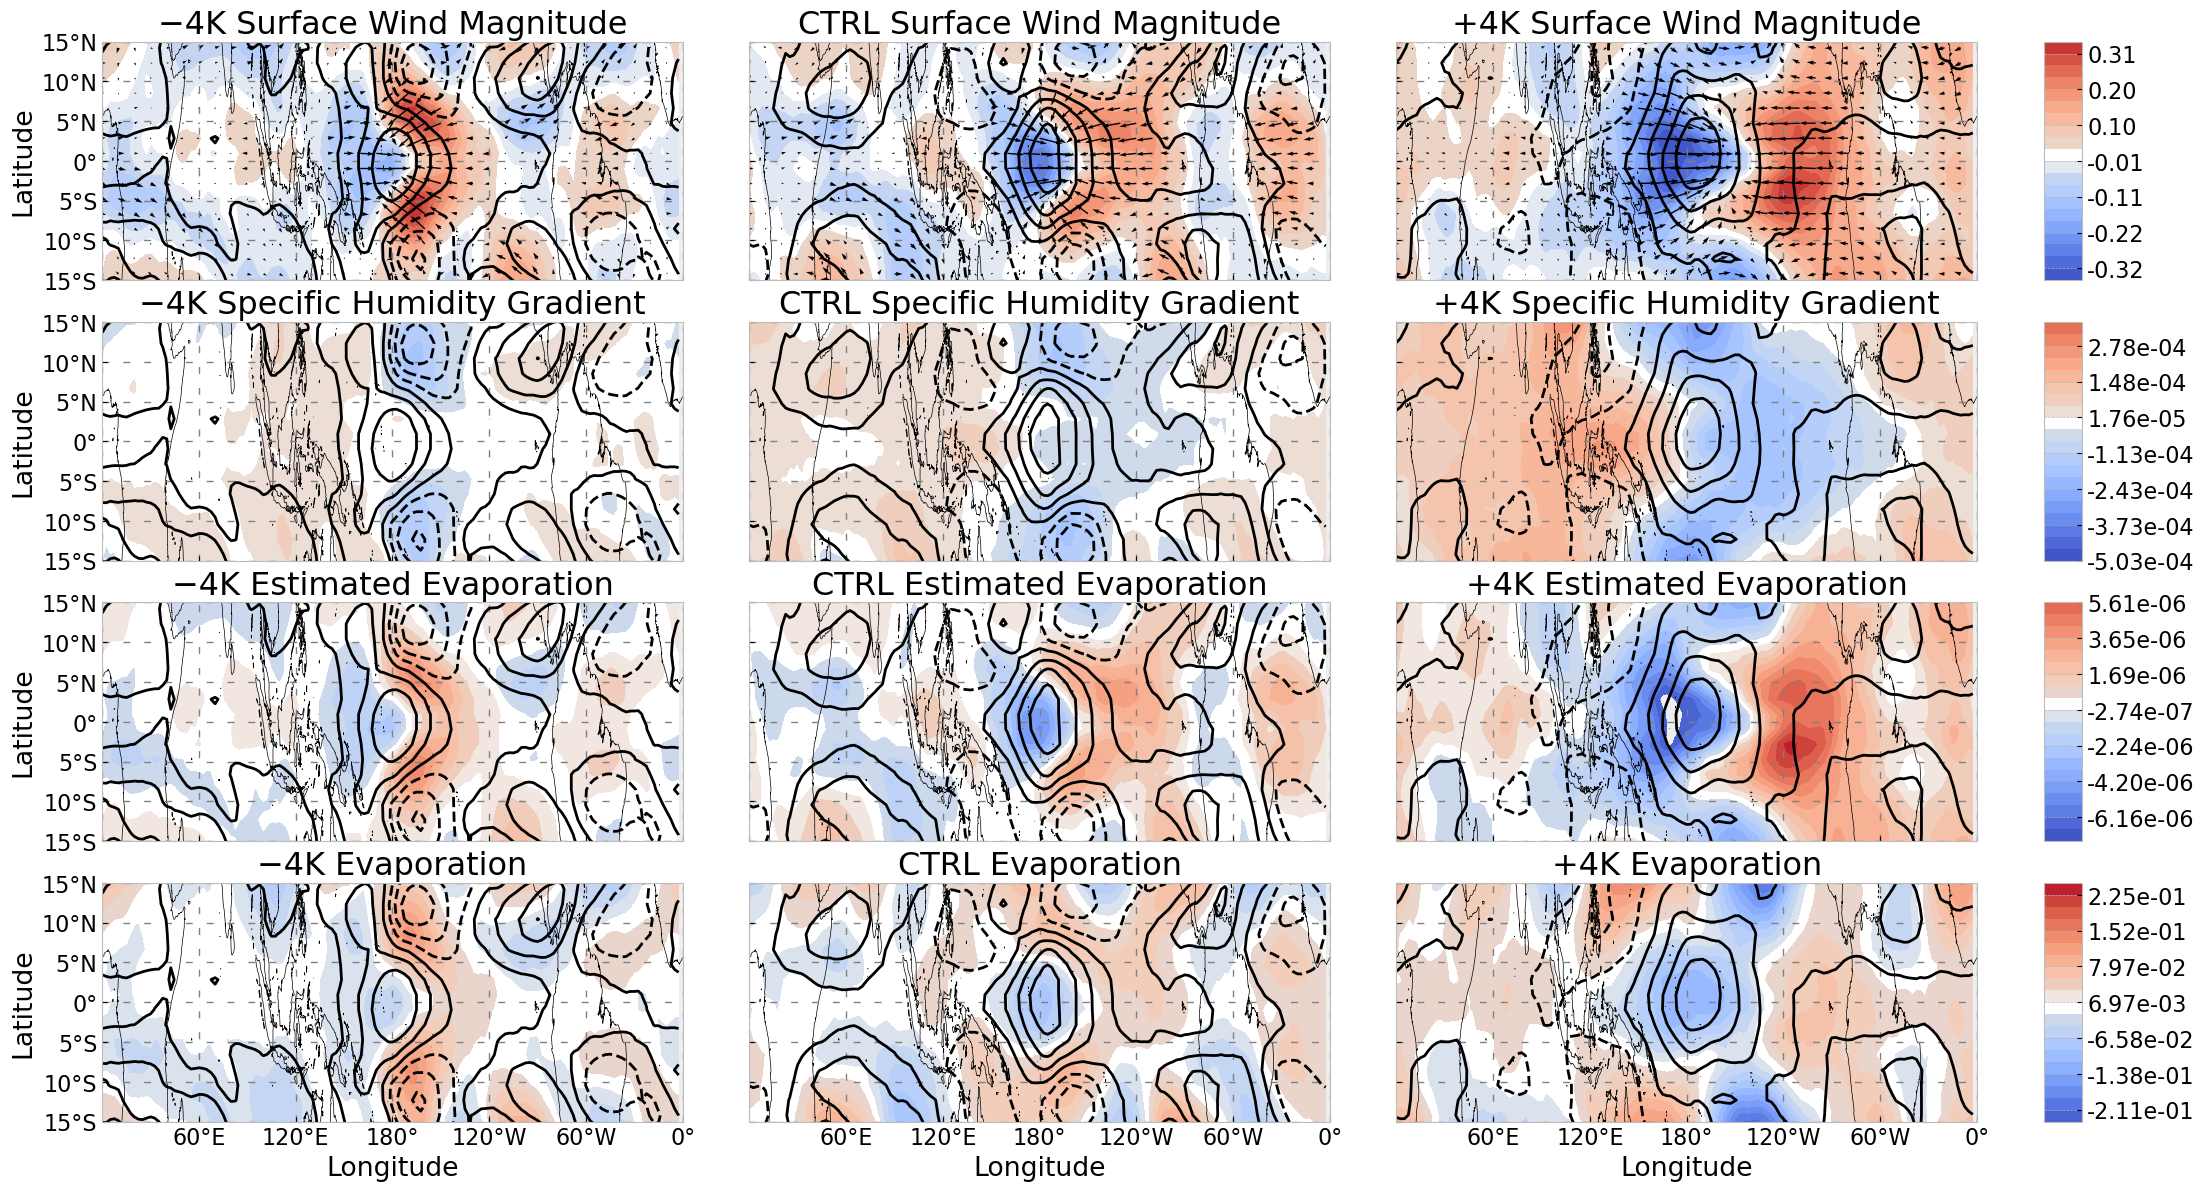

In [28]:
fig = plt.figure(figsize=(22, 12))
gs = GridSpec(4, 4, width_ratios=[15, 15, 15, 1], figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.175, wspace=0.15)

experiment_axes = []
for index in range(len(experiments_list)):
    experiment_axes.append([])
    experiment_axes[index].append(fig.add_subplot(gs[0, index], projection=ccrs.PlateCarree(central_longitude=180)))
    experiment_axes[index].append(fig.add_subplot(gs[1, index], projection=ccrs.PlateCarree(central_longitude=180)))
    experiment_axes[index].append(fig.add_subplot(gs[2, index], projection=ccrs.PlateCarree(central_longitude=180)))
    experiment_axes[index].append(fig.add_subplot(gs[3, index], projection=ccrs.PlateCarree(central_longitude=180)))

wind_grand_min = multi_experiment_budget_variables_regressed['Surface Wind Magnitude'].min()
wind_grand_max = multi_experiment_budget_variables_regressed['Surface Wind Magnitude'].max()

sh_grand_min = multi_experiment_budget_variables_regressed['Specific Humidity Gradient'].min()
sh_grand_max = multi_experiment_budget_variables_regressed['Specific Humidity Gradient'].max()

estimated_evap_grand_min = multi_experiment_budget_variables_regressed['Estimated Evaporation'].min()
estimated_evap_grand_max = multi_experiment_budget_variables_regressed['Estimated Evaporation'].max()

evap_grand_min = multi_experiment_budget_variables_regressed['Evaporation'].min()
evap_grand_max = multi_experiment_budget_variables_regressed['Evaporation'].max()

cbar_ax = []
cbar_ax.append(fig.add_subplot(gs[0, -1]))
cbar_ax.append(fig.add_subplot(gs[1, -1]))
cbar_ax.append(fig.add_subplot(gs[2, -1]))
cbar_ax.append(fig.add_subplot(gs[3, -1]))

for index, experiment in enumerate(experiments_list):
    experiment_axes[index][0].set_title(
        f"{experiments_array.sel(experiment=experiment)['name'].item()} Surface Wind Magnitude"
    )
    wind_im = experiment_axes[index][0].contourf(
        multi_experiment_budget_variables_regressed['Surface Wind Magnitude'].lon,
        multi_experiment_budget_variables_regressed['Surface Wind Magnitude'].lat,
        multi_experiment_budget_variables_regressed['Surface Wind Magnitude'].sel(experiment=experiment),
        levels=np.linspace(wind_grand_min, wind_grand_max, 21),
        cmap=mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05),
        norm=mcolors.CenteredNorm(vcenter=0),
        transform=ccrs.PlateCarree()
    )
    experiment_axes[index][0].contour(
        multi_experiment_budget_variables_regressed['Moisture'].lon,
        multi_experiment_budget_variables_regressed['Moisture'].lat,
        multi_experiment_budget_variables_regressed['Moisture'].sel(experiment=experiment),
        colors='k',
        transform=ccrs.PlateCarree()
    )

    [X, Y] = np.meshgrid(
        multi_experiment_budget_variables_regressed['Surface Wind Magnitude'].lon,
        multi_experiment_budget_variables_regressed['Surface Wind Magnitude'].lat,
    )
    experiment_axes[index][0].quiver(
        X[::1, ::4],
        Y[::1, ::4],
        multi_experiment_budget_variables_regressed['Zonal Wind'].sel(experiment=experiment).values[::1, ::4],
        multi_experiment_budget_variables_regressed['Meridional Wind'].sel(experiment=experiment).values[::1, ::4],
        # levels=np.linspace(wind_grand_min, wind_grand_max, 21),
        # cmap=mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05),
        # norm=mcolors.CenteredNorm(vcenter=0),
        transform=ccrs.PlateCarree()
    )

    experiment_axes[index][1].set_title(
        f"{experiments_array.sel(experiment=experiment)['name'].item()} Specific Humidity Gradient"
    )
    specific_humidity_im = experiment_axes[index][1].contourf(
        multi_experiment_budget_variables_regressed['Specific Humidity Gradient'].lon,
        multi_experiment_budget_variables_regressed['Specific Humidity Gradient'].lat,
        multi_experiment_budget_variables_regressed['Specific Humidity Gradient'].sel(experiment=experiment),
        levels=np.linspace(sh_grand_min, sh_grand_max, 21),
        cmap=mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05),
        norm=mcolors.CenteredNorm(vcenter=0),
        transform=ccrs.PlateCarree()
    )
    experiment_axes[index][1].contour(
        multi_experiment_budget_variables_regressed['Moisture'].lon,
        multi_experiment_budget_variables_regressed['Moisture'].lat,
        multi_experiment_budget_variables_regressed['Moisture'].sel(experiment=experiment),
        colors='k',
        transform=ccrs.PlateCarree()
    )

    experiment_axes[index][2].set_title(
        f"{experiments_array.sel(experiment=experiment)['name'].item()} Estimated Evaporation"
    )
    est_evaporation_im = experiment_axes[index][2].contourf(
        multi_experiment_budget_variables_regressed['Evaporation'].lon,
        multi_experiment_budget_variables_regressed['Evaporation'].lat,
        -multi_experiment_budget_variables_regressed['Estimated Evaporation'].sel(experiment=experiment),
        levels=np.linspace(estimated_evap_grand_min, estimated_evap_grand_max, 21),
        cmap=mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05),
        norm=mcolors.CenteredNorm(vcenter=0),
        transform=ccrs.PlateCarree()
    )
    experiment_axes[index][2].contour(
        multi_experiment_budget_variables_regressed['Moisture'].lon,
        multi_experiment_budget_variables_regressed['Moisture'].lat,
        multi_experiment_budget_variables_regressed['Moisture'].sel(experiment=experiment),
        colors='k',
        transform=ccrs.PlateCarree()
    )

    experiment_axes[index][3].set_title(
        f"{experiments_array.sel(experiment=experiment)['name'].item()} Evaporation"
    )
    evaporation_im = experiment_axes[index][3].contourf(
        multi_experiment_budget_variables_regressed['Evaporation'].lon,
        multi_experiment_budget_variables_regressed['Evaporation'].lat,
        multi_experiment_budget_variables_regressed['Evaporation'].sel(experiment=experiment),
        levels=np.linspace(evap_grand_min, evap_grand_max, 21),
        cmap=mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05),
        norm=mcolors.CenteredNorm(vcenter=0),
        transform=ccrs.PlateCarree()
    )
    # evaporation_im = experiment_axes[index][2].contourf(
    #     multi_experiment_budget_variables_regressed['Evaporation'].lon,
    #     multi_experiment_budget_variables_regressed['Evaporation'].lat,
    #     (
    #         multi_experiment_budget_variables_regressed['Surface Wind Magnitude']
    #         * multi_experiment_budget_variables_regressed['Surface Saturation Specific Humidity']
    #     ).sel(experiment=experiment),
    #     cmap=mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05),
    #     norm=mcolors.CenteredNorm(vcenter=0),
    #     transform=ccrs.PlateCarree()
    # )
    experiment_axes[index][3].contour(
        multi_experiment_budget_variables_regressed['Moisture'].lon,
        multi_experiment_budget_variables_regressed['Moisture'].lat,
        multi_experiment_budget_variables_regressed['Moisture'].sel(experiment=experiment),
        colors='k',
        transform=ccrs.PlateCarree()
    )

wind_cbar = fig.colorbar(wind_im, cax=cbar_ax[0], format='%.2f')
specific_humidity_cbar = fig.colorbar(specific_humidity_im, cax=cbar_ax[1], format='%.2e')
evaporation_cbar = fig.colorbar(evaporation_im, cax=cbar_ax[2], format='%.2e')
est_evaporation_cbar = fig.colorbar(est_evaporation_im, cax=cbar_ax[3], format='%.2e')


# import itertools
# axes_list = list(itertools.chain.from_iterable(experiment_axes))
# for index, ax in enumerate(axes_list):

for experiment_index in range(len(experiments_list)):
    for var_index in range(4):
        experiment_axes[experiment_index][var_index].set_aspect("auto")
        # ax.set_aspect(360/40)
        experiment_axes[experiment_index][var_index].add_feature(cf.COASTLINE)
        experiment_axes[experiment_index][var_index].set_xlim(-180, 180)
        # x_ticks = np.arange(0, 360 + 60, 60)
        x_ticks = np.arange(-180, 180 + 60, 60)
        experiment_axes[experiment_index][var_index].set_xticks(x_ticks)

        if var_index == 3:
            experiment_axes[experiment_index][var_index].set_xticklabels(tick_labeller(x_ticks+180, "lon"))
            experiment_axes[experiment_index][var_index].xaxis.set_major_locator(mticker.MaxNLocator(7, prune="lower"))
            experiment_axes[experiment_index][var_index].set_xlabel("Longitude")
        else:
            experiment_axes[experiment_index][var_index].set_xticklabels([])
            experiment_axes[experiment_index][var_index].set_xlabel("")

        experiment_axes[experiment_index][var_index].set_ylim(-15, 15)
        # y_ticks = np.arange(-30, 45, 15)
        # ax.set_ylim(-15, 15)
        y_ticks = np.arange(-15, 15+5, 5)
        experiment_axes[experiment_index][var_index].set_yticks(y_ticks)

        if experiment_index == 0:
            experiment_axes[experiment_index][var_index].set_yticklabels(tick_labeller(y_ticks, "lat"))
            experiment_axes[experiment_index][var_index].set_ylabel("Latitude")
        else:
            experiment_axes[experiment_index][var_index].set_yticklabels([])
            experiment_axes[experiment_index][var_index].set_ylabel("")

        grid_kwargs = {"linewidth": 1, "linestyle": (0, (5, 10)), "color": "gray"}
        experiment_axes[experiment_index][var_index].grid(True, **grid_kwargs)

plt.show()

### Column processes

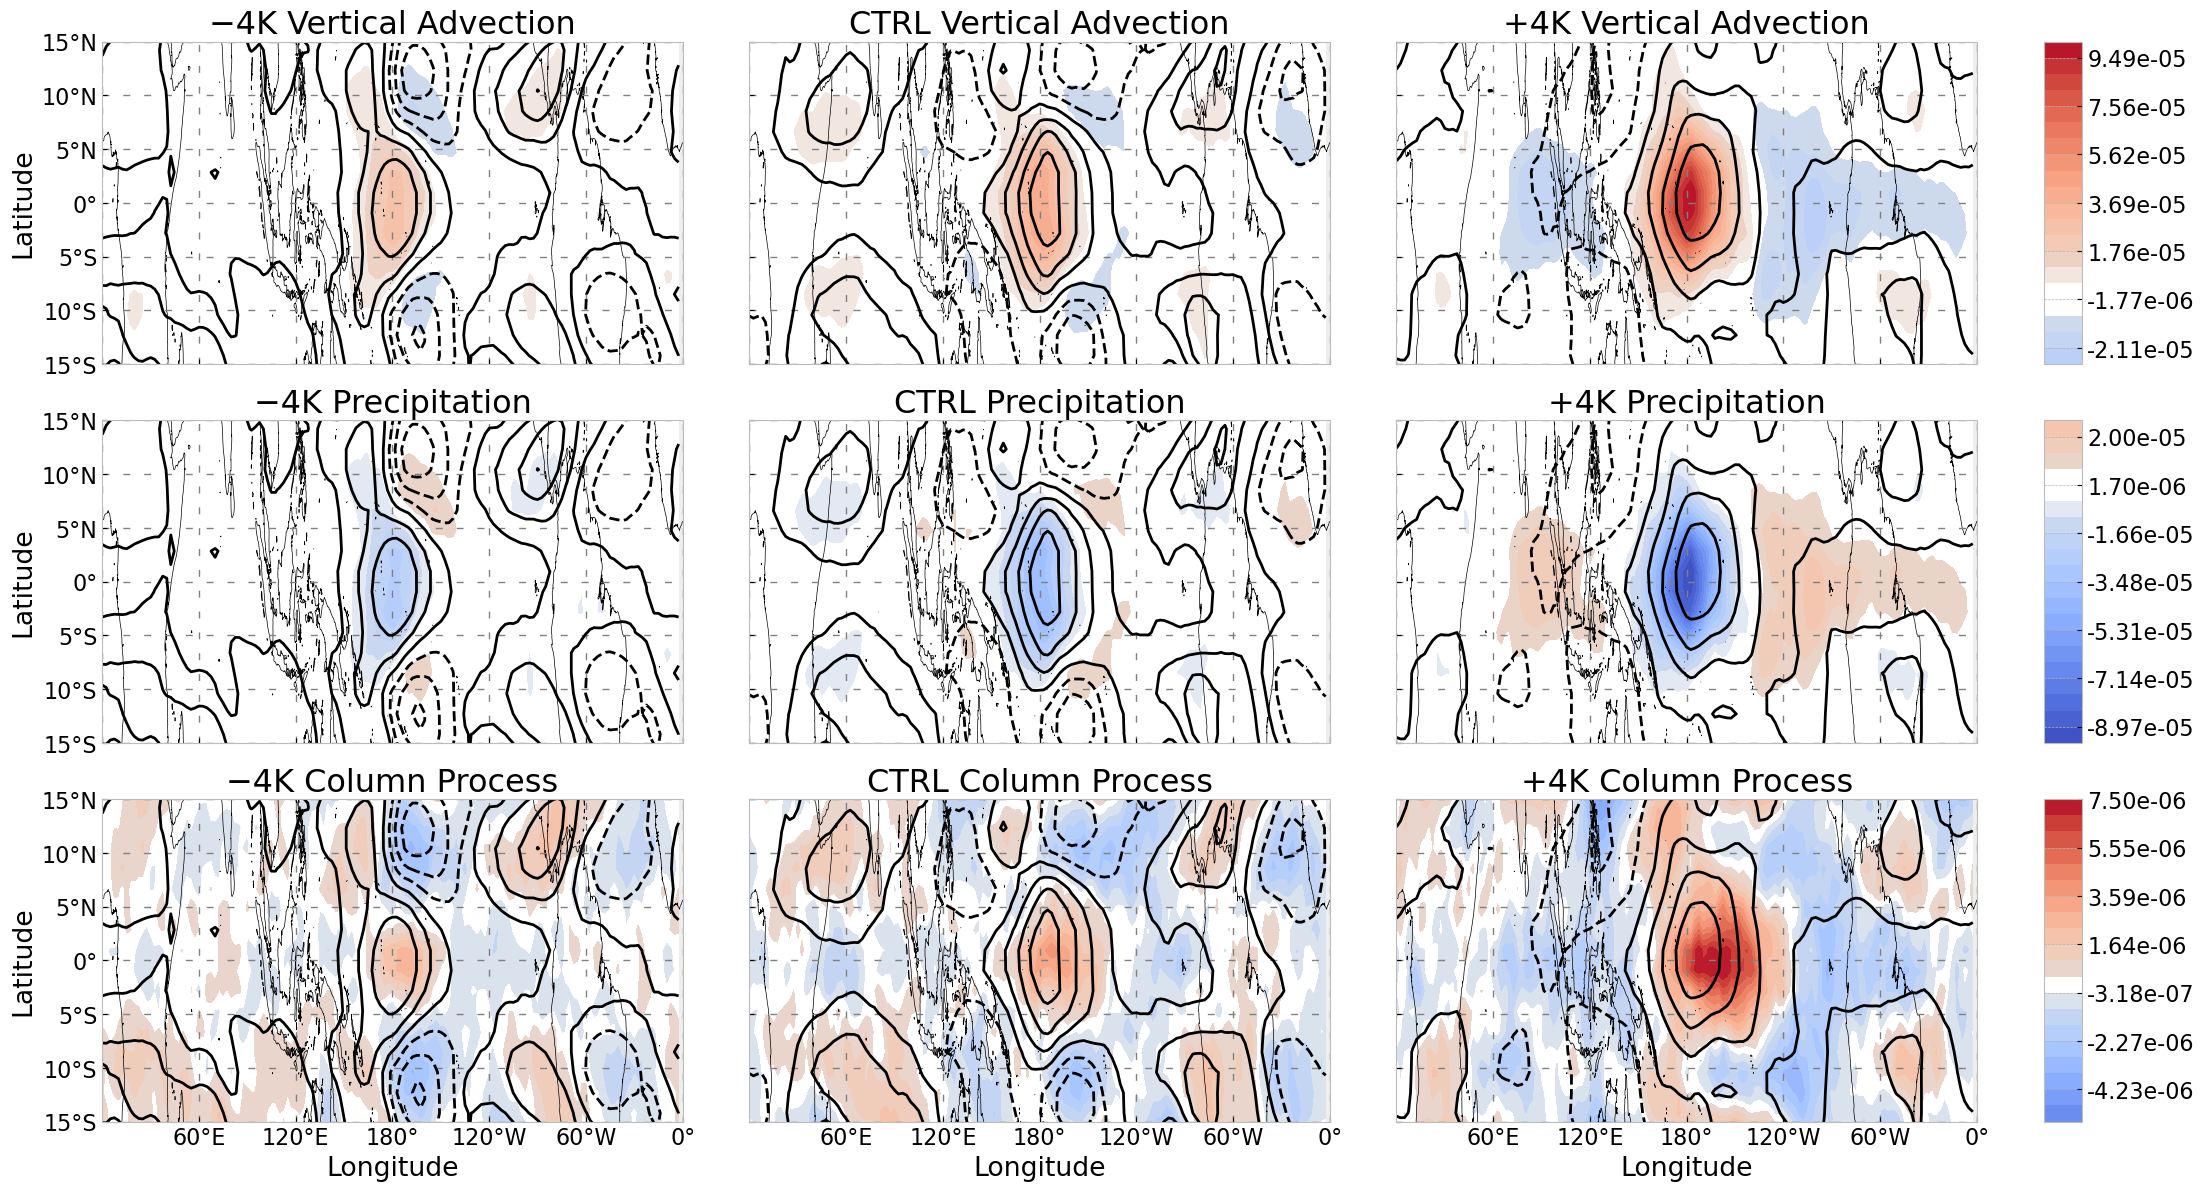

In [20]:
fig = plt.figure(figsize=(22, 12))
gs = GridSpec(3, 4, width_ratios=[15, 15, 15, 1], figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.175, wspace=0.15)

experiment_axes = []
for index in range(len(experiments_list)):
    experiment_axes.append([])
    experiment_axes[index].append(fig.add_subplot(gs[0, index], projection=ccrs.PlateCarree(central_longitude=180)))
    experiment_axes[index].append(fig.add_subplot(gs[1, index], projection=ccrs.PlateCarree(central_longitude=180)))
    experiment_axes[index].append(fig.add_subplot(gs[2, index], projection=ccrs.PlateCarree(central_longitude=180)))


vertical_advection_grand_min = multi_experiment_budget_variables_regressed['Vertical Advection'].min()
vertical_advection_grand_max = multi_experiment_budget_variables_regressed['Vertical Advection'].max()

precip_grand_min = multi_experiment_budget_variables_regressed['Precipitation'].min()
precip_grand_max = multi_experiment_budget_variables_regressed['Precipitation'].max()

column_process_grand_min = multi_experiment_budget_variables_regressed['Column Process'].min()
column_process_grand_max = multi_experiment_budget_variables_regressed['Column Process'].max()

cbar_ax = []
cbar_ax.append(fig.add_subplot(gs[0, -1]))
cbar_ax.append(fig.add_subplot(gs[1, -1]))
cbar_ax.append(fig.add_subplot(gs[2, -1]))

for index, experiment in enumerate(experiments_list):
    experiment_axes[index][0].set_title(
        f"{experiments_array.sel(experiment=experiment)['name'].item()} Vertical Advection"
    )
    vadv_im = experiment_axes[index][0].contourf(
        multi_experiment_budget_variables_regressed['Vertical Advection'].lon,
        multi_experiment_budget_variables_regressed['Vertical Advection'].lat,
        multi_experiment_budget_variables_regressed['Vertical Advection'].sel(experiment=experiment),
        levels=np.linspace(vertical_advection_grand_min, vertical_advection_grand_max, 21),
        cmap=mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05),
        norm=mcolors.CenteredNorm(vcenter=0),
        transform=ccrs.PlateCarree()
    )
    experiment_axes[index][0].contour(
        multi_experiment_budget_variables_regressed['Moisture'].lon,
        multi_experiment_budget_variables_regressed['Moisture'].lat,
        multi_experiment_budget_variables_regressed['Moisture'].sel(experiment=experiment),
        colors='k',
        transform=ccrs.PlateCarree()
    )

    experiment_axes[index][1].set_title(
        f"{experiments_array.sel(experiment=experiment)['name'].item()} Precipitation"
    )
    precip_im = experiment_axes[index][1].contourf(
        multi_experiment_budget_variables_regressed['Precipitation'].lon,
        multi_experiment_budget_variables_regressed['Precipitation'].lat,
        multi_experiment_budget_variables_regressed['Precipitation'].sel(experiment=experiment),
        levels=np.linspace(precip_grand_min, precip_grand_max, 21),
        cmap=mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05),
        norm=mcolors.CenteredNorm(vcenter=0),
        transform=ccrs.PlateCarree()
    )
    experiment_axes[index][1].contour(
        multi_experiment_budget_variables_regressed['Moisture'].lon,
        multi_experiment_budget_variables_regressed['Moisture'].lat,
        multi_experiment_budget_variables_regressed['Moisture'].sel(experiment=experiment),
        colors='k',
        transform=ccrs.PlateCarree()
    )

    experiment_axes[index][2].set_title(
        f"{experiments_array.sel(experiment=experiment)['name'].item()} Column Process"
    )
    column_im = experiment_axes[index][2].contourf(
        multi_experiment_budget_variables_regressed['Column Process'].lon,
        multi_experiment_budget_variables_regressed['Column Process'].lat,
        multi_experiment_budget_variables_regressed['Column Process'].sel(experiment=experiment),
        levels=np.linspace(column_process_grand_min, column_process_grand_max, 21),
        cmap=mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05),
        norm=mcolors.CenteredNorm(vcenter=0),
        transform=ccrs.PlateCarree()
    )
    experiment_axes[index][2].contour(
        multi_experiment_budget_variables_regressed['Moisture'].lon,
        multi_experiment_budget_variables_regressed['Moisture'].lat,
        multi_experiment_budget_variables_regressed['Moisture'].sel(experiment=experiment),
        colors='k',
        transform=ccrs.PlateCarree()
    )

vadv_cbar = fig.colorbar(vadv_im, cax=cbar_ax[0], format='%.2e')
precip_cbar = fig.colorbar(precip_im, cax=cbar_ax[1], format='%.2e')
column_cbar = fig.colorbar(column_im, cax=cbar_ax[2], format='%.2e')

# import itertools
# axes_list = list(itertools.chain.from_iterable(experiment_axes))
# for index, ax in enumerate(axes_list):

for experiment_index in range(len(experiments_list)):
    for var_index in range(3):
        experiment_axes[experiment_index][var_index].set_aspect("auto")
        # ax.set_aspect(360/40)
        experiment_axes[experiment_index][var_index].add_feature(cf.COASTLINE)
        experiment_axes[experiment_index][var_index].set_xlim(-180, 180)
        # x_ticks = np.arange(0, 360 + 60, 60)
        x_ticks = np.arange(-180, 180 + 60, 60)
        experiment_axes[experiment_index][var_index].set_xticks(x_ticks)

        if var_index == 2:
            experiment_axes[experiment_index][var_index].set_xticklabels(tick_labeller(x_ticks+180, "lon"))
            experiment_axes[experiment_index][var_index].xaxis.set_major_locator(mticker.MaxNLocator(7, prune="lower"))
            experiment_axes[experiment_index][var_index].set_xlabel("Longitude")
        else:
            experiment_axes[experiment_index][var_index].set_xticklabels([])
            experiment_axes[experiment_index][var_index].set_xlabel("")

        experiment_axes[experiment_index][var_index].set_ylim(-15, 15)
        # y_ticks = np.arange(-30, 45, 15)
        # ax.set_ylim(-15, 15)
        y_ticks = np.arange(-15, 15+5, 5)
        experiment_axes[experiment_index][var_index].set_yticks(y_ticks)

        if experiment_index == 0:
            experiment_axes[experiment_index][var_index].set_yticklabels(tick_labeller(y_ticks, "lat"))
            experiment_axes[experiment_index][var_index].set_ylabel("Latitude")
        else:
            experiment_axes[experiment_index][var_index].set_yticklabels([])
            experiment_axes[experiment_index][var_index].set_ylabel("")

        grid_kwargs = {"linewidth": 1, "linestyle": (0, (5, 10)), "color": "gray"}
        experiment_axes[experiment_index][var_index].grid(True, **grid_kwargs)

plt.show()

# Huang2024 Budgets

## Load data

In [72]:
data_directory = "/glade/derecho/scratch/sressel"

MSE = []
dhdt = []
LW = []
SW = []
LH = []
SH = []
hadv = []
vadv = []
residual = []

print("Loading budget terms...")
print(f"{'='*str_width}")
for experiment in ['-4K', '0K', '4K']:
    print(f"Experiment: {experiment}")
    MSE.append(xr.open_dataset(f"{data_directory}/{experiment}_regressed_column_MSE.nc")['MSE'])
    dhdt.append(24*3600*xr.open_dataset(f"{data_directory}/{experiment}_regressed_column_MSE_tendency.nc")['dhdt'])
    LW.append(24*3600*xr.open_dataset(f"{data_directory}/{experiment}_regressed_longwave_heating.nc")['LW'])
    SW.append(24*3600*xr.open_dataset(f"{data_directory}/{experiment}_regressed_shortwave_heating.nc")['SW'])
    LH.append(24*3600*xr.open_dataset(f"{data_directory}/{experiment}_regressed_latent_heating.nc")['LH'])
    SH.append(24*3600*xr.open_dataset(f"{data_directory}/{experiment}_regressed_sensible_heating.nc")['SH'])
    hadv.append(-24*3600*xr.open_dataset(f"{data_directory}/{experiment}_regressed_horizontal_advection.nc")['hadv'])
    vadv.append(-24*3600*xr.open_dataset(f"{data_directory}/{experiment}_regressed_vertical_advection.nc")['vadv'])


huang_budget_terms_regressed = {}

# Moist Static Energy
huang_budget_terms_regressed['Moist Static Energy'] = xr.concat(
    MSE, dim=experiments_array
)
huang_budget_terms_regressed['Moist Static Energy'].name = 'Moist Static Energy'
huang_budget_terms_regressed['Moist Static Energy'].attrs['short_name'] = r"$\langle m \rangle$"
# multi_experiment_MSE = xr.concat(
#     MSE, dim=experiments_array
# )
# multi_experiment_MSE.attrs['short_name'] = r"$\langle m \rangle$"

# Moist Static Energy Tendency
huang_budget_terms_regressed['Moist Static Energy Tendency'] = xr.concat(
    dhdt, dim=experiments_array
)
huang_budget_terms_regressed['Moist Static Energy Tendency'].name = 'Moist Static Energy Tendency'
huang_budget_terms_regressed['Moist Static Energy Tendency'].attrs['short_name'] = r"$\langle \partial_{t}m \rangle$"

# Longwave Heating
huang_budget_terms_regressed['Longwave Heating'] = xr.concat(
    LW, dim=experiments_array
)
huang_budget_terms_regressed['Longwave Heating'].name = 'Longwave Heating'
huang_budget_terms_regressed['Longwave Heating'].attrs['short_name'] = r"$\langle$LW$\rangle$"

# Shortwave Heating
huang_budget_terms_regressed['Shortwave Heating'] = xr.concat(
    SW, dim=experiments_array
)
huang_budget_terms_regressed['Shortwave Heating'].name = 'Shortwave Heating'
huang_budget_terms_regressed['Shortwave Heating'].attrs['short_name'] = r"$\langle$SW$\rangle$"

# Latent Heating
huang_budget_terms_regressed['Latent Heating'] = xr.concat(
    LH, dim=experiments_array
)
huang_budget_terms_regressed['Latent Heating'].name = 'Latent Heating'
huang_budget_terms_regressed['Latent Heating'].attrs['short_name'] = r"LH"

# Sensible Heating
huang_budget_terms_regressed['Sensible Heating'] = xr.concat(
    SH, dim=experiments_array
)
huang_budget_terms_regressed['Sensible Heating'].name = 'Sensible Heating'
huang_budget_terms_regressed['Sensible Heating'].attrs['short_name'] = r"SH"

# Horizontal Advection
huang_budget_terms_regressed['Horizontal Advection'] = xr.concat(
    hadv, dim=experiments_array
)
huang_budget_terms_regressed['Horizontal Advection'].name = 'Horizontal Advection'
huang_budget_terms_regressed['Horizontal Advection'].attrs['short_name'] = r"-$\langle (\vec{v} \cdot \nabla_{h})m \rangle$"

# Vertical Advection
huang_budget_terms_regressed['Vertical Advection'] = xr.concat(
    vadv, dim=experiments_array
)
huang_budget_terms_regressed['Vertical Advection'].name = 'Vertical Advection'
huang_budget_terms_regressed['Vertical Advection'].attrs['short_name'] = r"-$\langle \omega \partial_{p}m \rangle$"

# Residual
estimated_moist_static_energy_tendency = (
    + huang_budget_terms_regressed['Longwave Heating']
    + huang_budget_terms_regressed['Shortwave Heating']
    + huang_budget_terms_regressed['Latent Heating']
    + huang_budget_terms_regressed['Sensible Heating']
    + huang_budget_terms_regressed['Horizontal Advection']
    + huang_budget_terms_regressed['Vertical Advection']
)
huang_budget_terms_regressed['Residual'] = (
    huang_budget_terms_regressed['Moist Static Energy Tendency']
    - estimated_moist_static_energy_tendency
)
huang_budget_terms_regressed['Residual'].name = 'Residual'
huang_budget_terms_regressed['Residual'].attrs['short_name'] = r"Res."

print(f"{'='*str_width}")
print("Finished")

Loading budget terms...
Experiment: -4K
Experiment: 0K
Experiment: 4K
Finished


## Calculate Budget contributions

In [79]:
print(f"{'Budget Contributions':^{str_width}}")
print(f"{'='*str_width}")

projection_variable = 'Moist Static Energy'
latitude_integration_bounds = (-15,15)

budget_maintenance_contribution = {}
budget_propagation_contribution = {}

for index, (budget_term, data) in enumerate(huang_budget_terms_regressed.items()):
    print(f"{f'({index+1}/{len(huang_budget_terms_regressed)}) {budget_term}...':<{str_width-1}}", end="")

    maintenance_numerator = (
        huang_budget_terms_regressed[projection_variable]
        * data
    )
    maintenance_denominator = huang_budget_terms_regressed[projection_variable]**2
    budget_maintenance_contribution[budget_term] = (
        maintenance_numerator.sel(lat=slice(*latitude_integration_bounds)).integrate('lat').integrate('lon')
        / maintenance_denominator.sel(lat=slice(*latitude_integration_bounds)).integrate('lat').integrate('lon')
    )
    budget_maintenance_contribution[budget_term].attrs = data.attrs

    propagation_numerator = huang_budget_terms_regressed[f"{projection_variable} Tendency"]*data
    propagation_denominator = huang_budget_terms_regressed[f"{projection_variable} Tendency"]**2

    budget_propagation_contribution[budget_term] = (
        propagation_numerator.sel(lat=slice(*latitude_integration_bounds)).integrate('lat').integrate('lon')
        / propagation_denominator.sel(lat=slice(*latitude_integration_bounds)).integrate('lat').integrate('lon')
    )
    budget_propagation_contribution[budget_term].attrs = data.attrs
    print(rf"{'✔':>1}")

print(f"{'='*str_width}")
print("Finished")

          Budget Contributions          
(1/9) Moist Static Energy...           ✔
(2/9) Moist Static Energy Tendency...  ✔
(3/9) Longwave Heating...              ✔
(4/9) Shortwave Heating...             ✔
(5/9) Latent Heating...                ✔
(6/9) Sensible Heating...              ✔
(7/9) Horizontal Advection...          ✔
(8/9) Vertical Advection...            ✔
(9/9) Residual...                      ✔
Finished


## Plot Budgets

### Specify plot design

In [80]:
bar_processes = {
    'Moist Static Energy Tendency': {
        'label': r"$\langle \partial_{t} h \rangle$",
        'color': plt.get_cmap('Blues'),
    },
    'Longwave Heating': {
        'label': r"$\langle$LW$\rangle$",
        'color': mcolors.LinearSegmentedColormap.from_list("Pinks", ["#ffd6e6", "#ffb3cc", "#ff80b3", "#ff3385", "#e60073"], N=256),
    },
    'Shortwave Heating': {
        'label': r"$\langle$SW$\rangle$",
        'color': mcolors.LinearSegmentedColormap.from_list("Golden",["#fff9cc", "#ffe999", "#ffcc66",  "#e6b347", "#c49e35"], N=256),
    },
    'Latent Heating': {
        'label': r'LH',
        'color': plt.get_cmap('Greens'),
    },
    'Sensible Heating': {
        'label': r'SH',
        'color': mcolors.LinearSegmentedColormap.from_list("Cyans", ["#e0ffff", "#80e0ff", "#00c0ff", "#0080ff", "#0040ff"], N=256),
    },
    'Horizontal Advection': {
        'label': r"-$\langle \vec{v}\cdot \nabla h \rangle$",
        'color': plt.get_cmap('Oranges'),
    },
    'Vertical Advection': {
        'label': r"-$\langle \omega \partial_{p} h \rangle$",
        'color': plt.get_cmap('Purples'),
    },
    'Residual': {
        'label': r"Res.",
        'color': plt.get_cmap('Greys'),
    },
}

### Maintenance

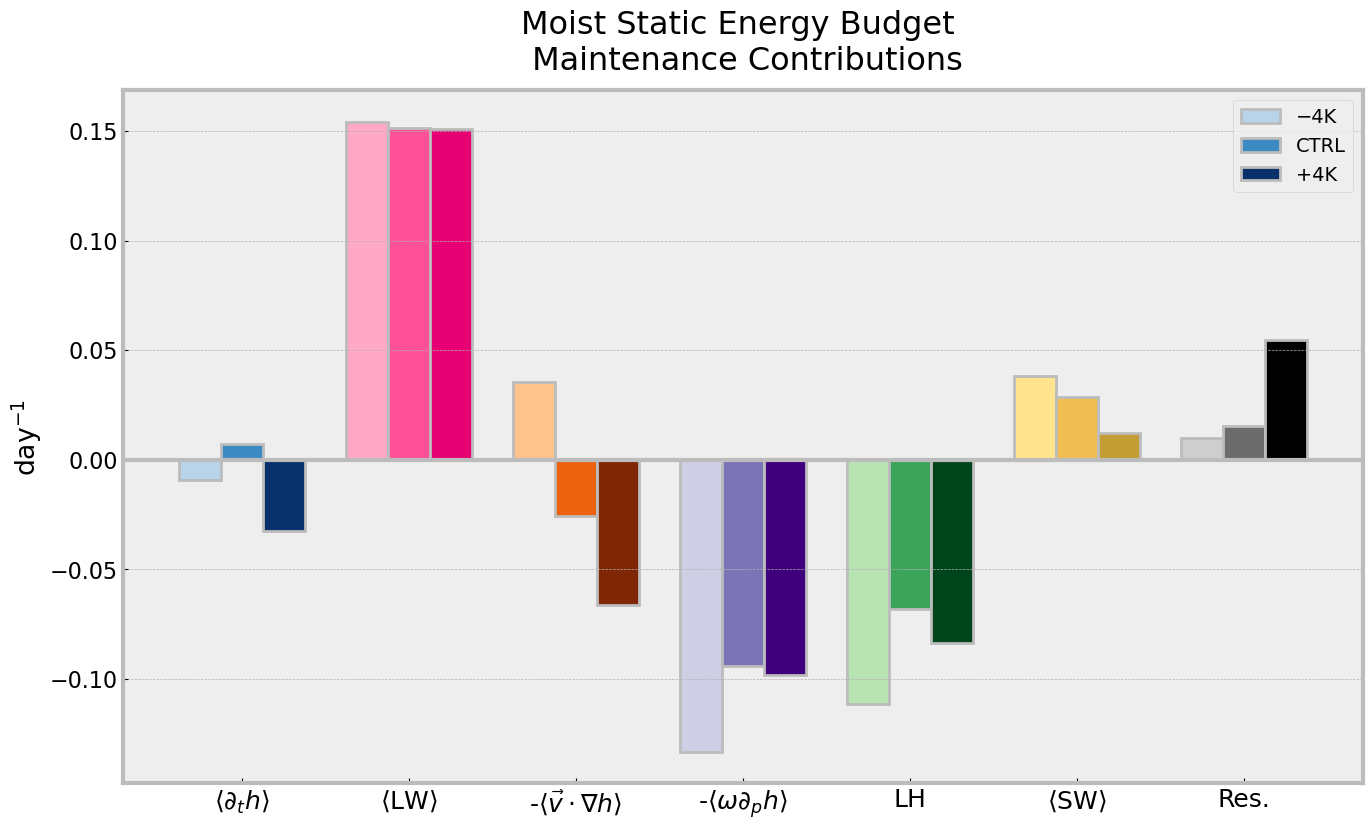

In [20]:
projected_variable = "Moist Static Energy"

plt.style.use('bmh')
plt.rcParams.update({'font.size': 16, 'mathtext.fontset': 'dejavusans'})

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.set_title(f"{projected_variable} Budget \n Maintenance Contributions", pad=15)

bar_width = 0.25
x_positions = np.arange(len(bar_processes.keys()))

# Plot bars for each experiment with different hatching
for i, experiment in enumerate(experiments_list):
    ax.bar(
        x_positions + i * bar_width,
        [budget_maintenance_contribution[process].sel(experiment=experiment).values for process in bar_processes.keys()],
        width=bar_width,
        label=experiments_array.sel(experiment=experiment)['name'].item(),
        color=[process['color'](0.3 + 0.35 * i) for process in bar_processes.values()],
        edgecolor='#bcbcbc',
        lw=2,
    )

ax.set_ylabel(r'day$^{-1}$')
ax.set_xticks(x_positions + bar_width, labels=[process['label'] for process in bar_processes.values()], fontsize=18)
ax.axhline(y=0, color='#bcbcbc', lw=3)
ax.grid(axis='x')

for spine in ax.spines.values():
    spine.set_edgecolor("#bcbcbc")
    spine.set_linewidth(3)

# Add legend to distinguish experiments
ax.legend(fontsize=14)

plt.show()

### Propagation

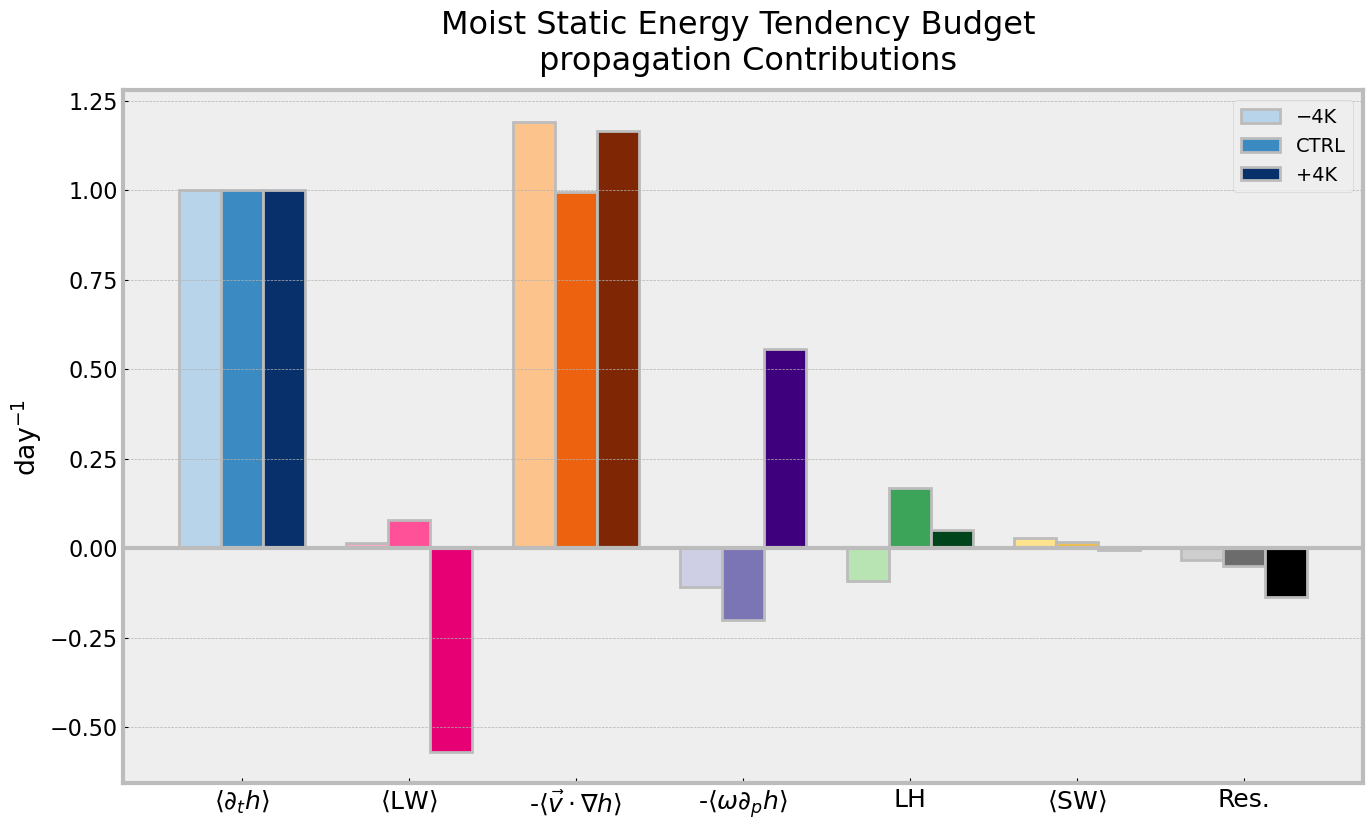

In [21]:
projected_variable = "Moist Static Energy Tendency"


plt.style.use('bmh')
plt.rcParams.update({'font.size': 16, 'mathtext.fontset': 'dejavusans'})

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.set_title(f"{projected_variable} Budget \n propagation Contributions", pad=15)

bar_width = 0.25
x_positions = np.arange(len(bar_processes.keys()))

# Plot bars for each experiment with different hatching
for i, experiment in enumerate(experiments_list):
    ax.bar(
        x_positions + i * bar_width,
        [budget_propagation_contribution[process].sel(experiment=experiment).values for process in bar_processes.keys()],
        width=bar_width,
        label=experiments_array.sel(experiment=experiment)['name'].item(),
        color=[process['color'](0.3 + 0.35 * i) for process in bar_processes.values()],
        edgecolor='#bcbcbc',
        lw=2,
    )

ax.set_ylabel(r'day$^{-1}$')
ax.set_xticks(x_positions + bar_width, labels=[process['label'] for process in bar_processes.values()], fontsize=18)
ax.axhline(y=0, color='#bcbcbc', lw=3)
ax.grid(axis='x')

for spine in ax.spines.values():
    spine.set_edgecolor("#bcbcbc")
    spine.set_linewidth(3)

# Add legend to distinguish experiments
ax.legend(fontsize=14)

plt.show()

### Combined Maintenance-Propagation

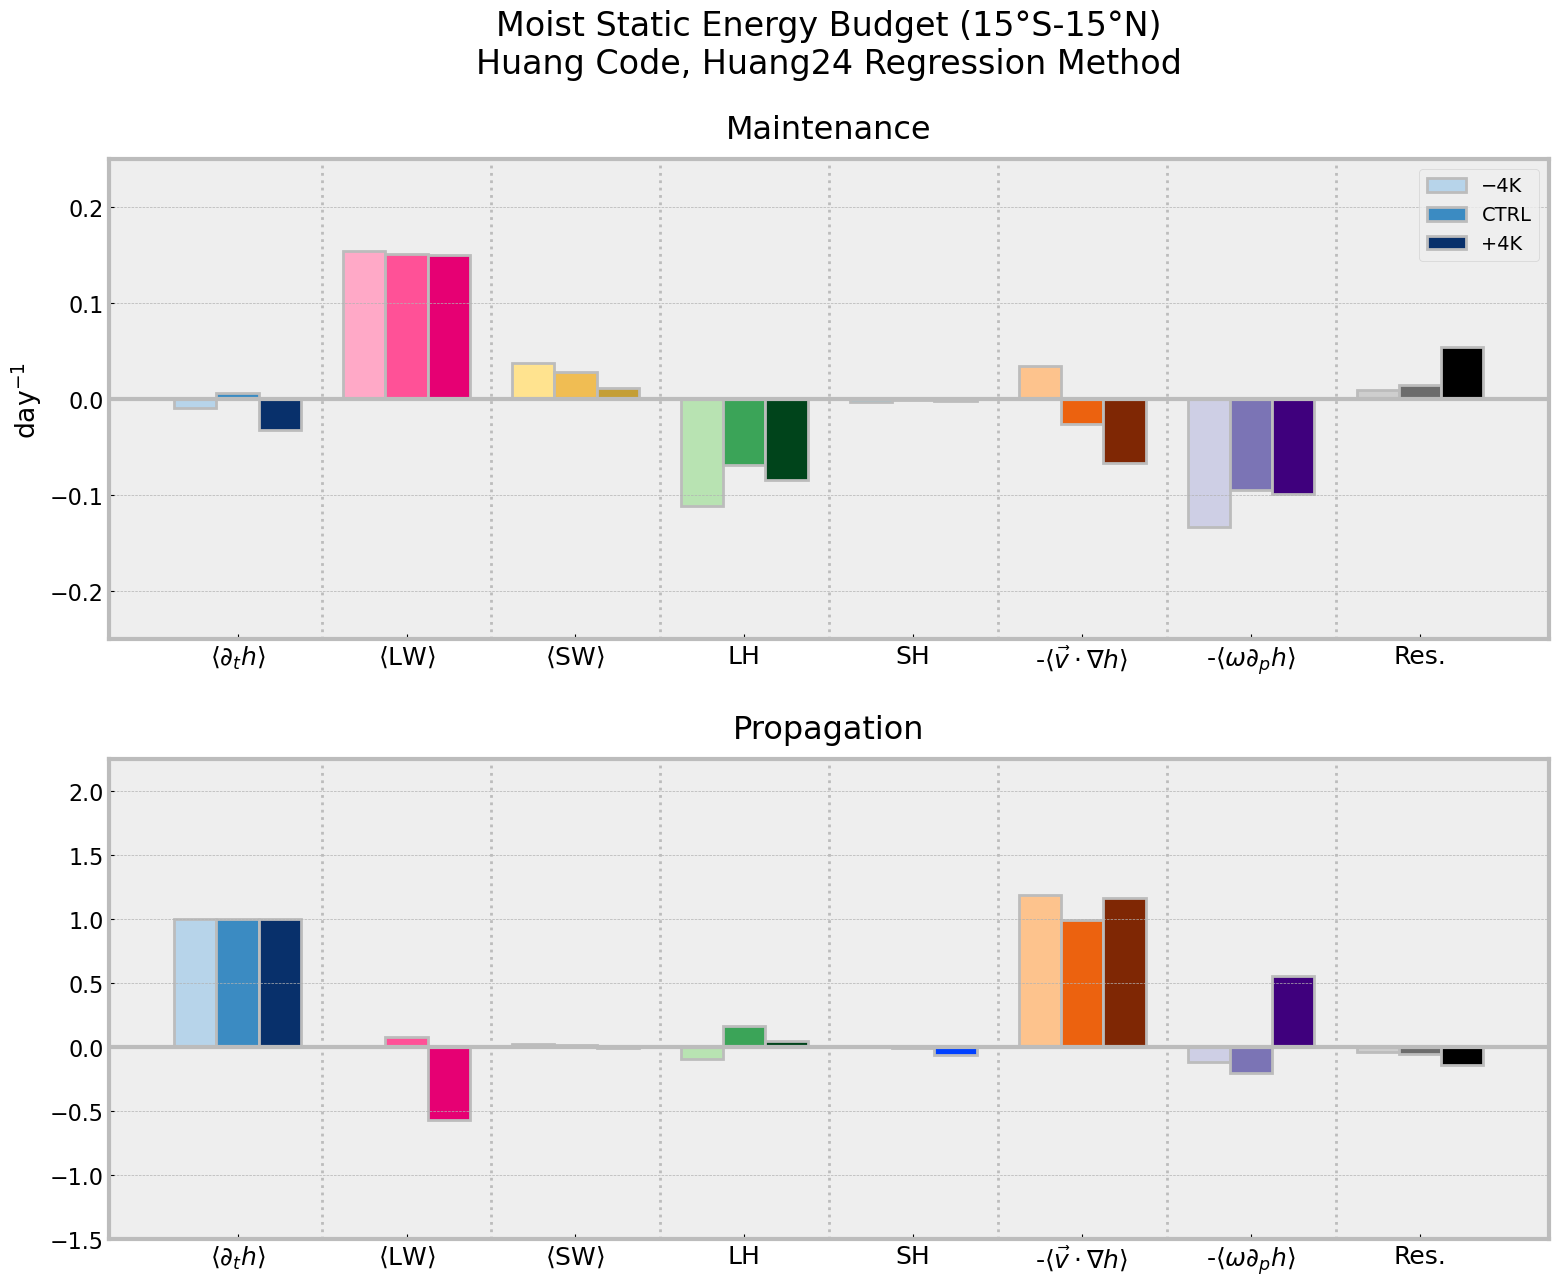

In [81]:
projected_variable = "Moist Static Energy"

plt.style.use('bmh')
plt.rcParams.update({'font.size': 16, 'mathtext.fontset': 'dejavusans'})

fig = plt.figure(figsize=(16, 12))
gs = GridSpec(2, 1, figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.25)

ax = []
ax.append(fig.add_subplot(gs[0]))
ax.append(fig.add_subplot(gs[1]))

fig.suptitle(
    (
        f"{projected_variable} Budget"
        + f" ({tick_labeller([latitude_integration_bounds[0]], 'lat')[0]}-{tick_labeller([latitude_integration_bounds[-1]], 'lat')[0]})"
        + f"\nHuang Code, {mjo_index_method} Regression Method"
    ),
    y=1.075,
    fontsize=24
)

ax[0].set_title("Maintenance", pad=15)

bar_width = 0.25
x_positions = np.arange(len(bar_processes.keys()))

# Plot bars for each experiment with different hatching
for i, experiment in enumerate(experiments_list):
    ax[0].bar(
        x_positions + i * bar_width,
        [budget_maintenance_contribution[process].sel(experiment=experiment).values for process in bar_processes.keys()],
        width=bar_width,
        label=experiments_array.sel(experiment=experiment)['name'].item(),
        color=[process['color'](0.3 + 0.35 * i) for process in bar_processes.values()],
        edgecolor='#bcbcbc',
        lw=2,
    )

ax[0].set_ylabel(r'day$^{-1}$')
# ax[0].set_ylim(-0.2, 0.2)
ax[0].set_ylim(-0.25, 0.25)

for spine in ax[0].spines.values():
    spine.set_edgecolor("#bcbcbc")
    spine.set_linewidth(3)

# Add legend to distinguish experiments
ax[0].legend(fontsize=14)

# Propagation
ax[1].set_title("Propagation", pad=15)

bar_width = 0.25
x_positions = np.arange(len(bar_processes.keys()))

# Plot bars for each experiment with different hatching
for i, experiment in enumerate(experiments_list):
    ax[1].bar(
        x_positions + i * bar_width,
        [budget_propagation_contribution[process].sel(experiment=experiment).values for process in bar_processes.keys()],
        width=bar_width,
        label=experiments_array.sel(experiment=experiment)['name'].item(),
        color=[process['color'](0.3 + 0.35 * i) for process in bar_processes.values()],
        edgecolor='#bcbcbc',
        lw=2,
    )

# ax[1].set_ylim(-0.675, 1.25)
ax[1].set_ylim(-1.5, 2.25)

for axis in ax:
    [axis.axvline(x=(position + 3*bar_width), ls=':', color='#bcbcbc') for position in x_positions[:-1]]
    axis.set_xticks(x_positions + bar_width, labels=[process['label'] for process in bar_processes.values()], fontsize=18)
    axis.axhline(y=0, color='#bcbcbc', lw=3)
    axis.grid(axis='x')

    for spine in axis.spines.values():
        spine.set_edgecolor("#bcbcbc")
        spine.set_linewidth(3)

plt.show()

### Horizontal Structures

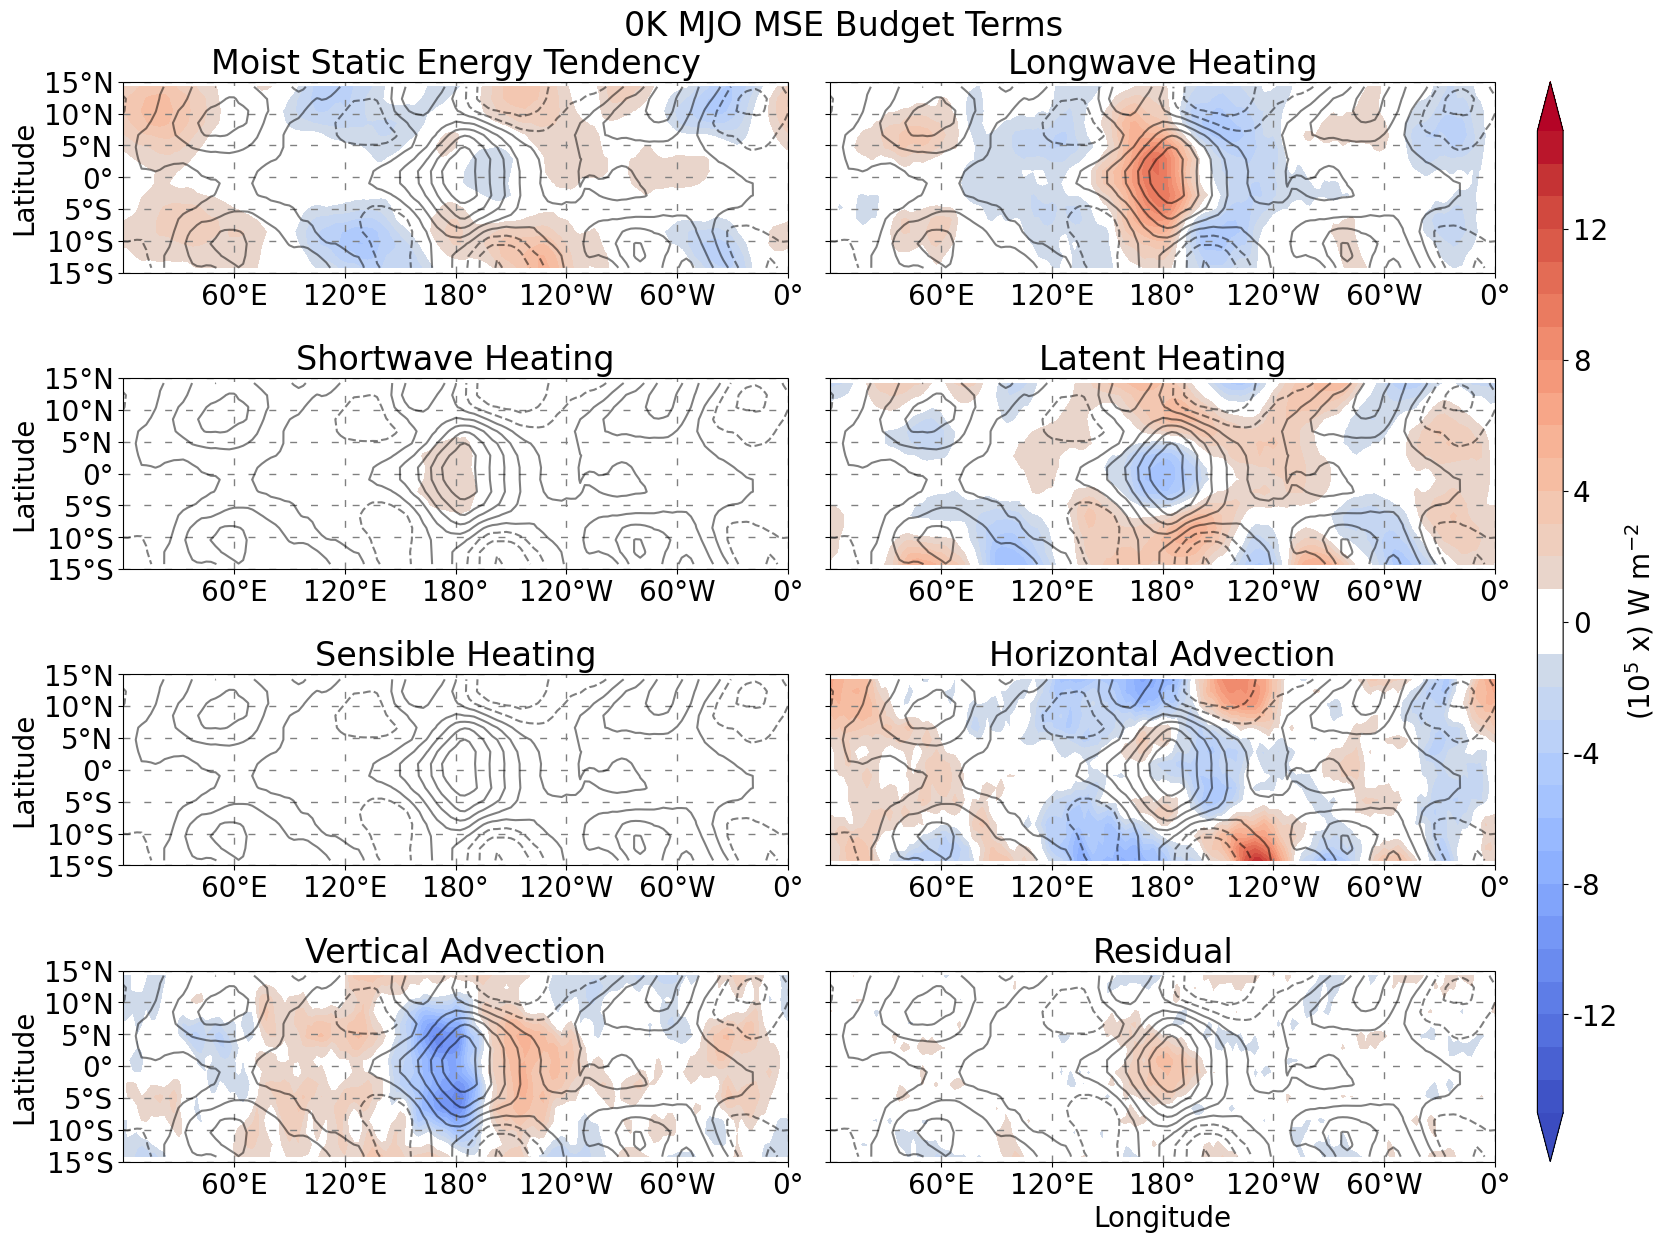

In [85]:
merged_multi_experiment_budget_variables_regressed = xr.merge(
    [variable.sel(lat=slice(-15,15))/10**5 for variable in multi_experiment_variables_regressed.values()]
)

experiment_to_plot = '0K'
savefig=False

plt.style.use('default')
plt.rcParams.update({'font.size':20})

meridional_mean_region = slice(-50,50)
colormap = 'RdYlBu_r'

fig = plt.figure(figsize=(16, 12))
gs = GridSpec(4, 7, width_ratios=[15,15,15,15,15,15,2], figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.55, wspace=0.25)

axes = []
axes.append(fig.add_subplot(gs[0, 0:3], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[0, 3:6], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[1, 0:3], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[1, 3:6], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[2, 0:3], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[2, 3:6], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[3, 0:3], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[3, 3:6], projection=ccrs.PlateCarree(central_longitude=180)))

cbar_ax = fig.add_subplot(gs[:,-1])

grand_max = merged_multi_experiment_budget_variables_regressed.sel(
    lat=meridional_mean_region
).drop_vars('Moist Static Energy').to_array().max()
grand_min = merged_multi_experiment_budget_variables_regressed.sel(
    lat=meridional_mean_region
).drop_vars('Moist Static Energy').to_array().min()

fig.suptitle(f"{experiment_to_plot} MJO MSE Budget Terms", x=0.5, y=1.01)

for ax, (variable_name, variable_data) in zip(
    axes, list(
        merged_multi_experiment_budget_variables_regressed.drop_vars('Moist Static Energy').data_vars.items()
    )
):

    [cdata, clon] = cutil.add_cyclic_point(
        variable_data.sel(lat=meridional_mean_region).sel(experiment=experiment_to_plot),
        variable_data.lon
    )

    ax.set_title(f"{variable_data.name}")
    im = ax.contourf(
        clon,
        variable_data.lat.sel(lat=meridional_mean_region),
        cdata,
        # cmap=colormap,
        cmap=mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05),
        # levels=np.linspace(grand_min, grand_max, 21),
        levels = np.arange(-15, 16, 1),
        norm=mcolors.CenteredNorm(vcenter=0),
        transform=ccrs.PlateCarree(),
        extend='both'
    )

    [cmoisture_data, cmoisture_lon] = cutil.add_cyclic_point(
        merged_multi_experiment_budget_variables_regressed['Moist Static Energy'].sel(experiment=experiment_to_plot),
        merged_multi_experiment_budget_variables_regressed['Moist Static Energy'].lon
    )

    ax.contour(
        cmoisture_lon,
        merged_multi_experiment_budget_variables_regressed['Moist Static Energy'].lat,
        cmoisture_data,
        transform=ccrs.PlateCarree(),
        colors='k',
        alpha=0.5,
        levels=7
    )

    # ax.plot(
    #     reference_longitude,
    #     reference_latitude.sel(experiment=experiment_to_plot),
    #     transform=ccrs.PlateCarree(),
    #     marker='x',
    #     color='black',
    #     ms=10
    # )

for index, ax in enumerate(axes):

    ax.set_aspect("auto")
    # ax.add_feature(cf.COASTLINE)
    ax.set_xlim(-180, 180)
    # x_ticks = np.arange(0, 360 + 60, 60)
    x_ticks = np.arange(-180, 180 + 60, 60)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(tick_labeller(x_ticks+180, "lon"))
    ax.xaxis.set_major_locator(mticker.MaxNLocator(7, prune="lower"))

    if index == len(axes)-1:
        ax.set_xlabel("Longitude")

    ax.set_ylim(-5, 5)
    # y_ticks = np.arange(-30, 45, 15)
    ax.set_ylim(-15, 15)
    y_ticks = np.arange(-15, 15+5, 5)
    ax.set_yticks(y_ticks)
    if index%2 == 0:
        ax.set_yticklabels(tick_labeller(y_ticks, "lat"))
        ax.set_ylabel("Latitude")
    else:
        ax.set_yticklabels('')

    grid_kwargs = {"linewidth": 1, "linestyle": (0, (5, 10)), "color": "gray"}
    ax.grid(True, **grid_kwargs)

cbar = fig.colorbar(im, cax=cbar_ax, format='%.0f')
cbar.set_label(r"(10$^{5}$ x) W m$^{-2}$")

# Save figure
output_filename = f"{experiment_to_plot}_budget_terms_latlon"
print(f"Output directory: {aquaplanet_output_directory}")
print(f"Output filename: {output_filename}/budget_analysis")
if savefig:
    print(f"{f'Saving...':<{str_width-1}}", end="")
    plt.savefig(
        f"{aquaplanet_output_directory}/budget_analysis/{output_filename}.png",
        dpi=500,
        bbox_inches="tight",
    )
    print(rf"{'✔':>1}")
else:
    print("Not Saving")
    plt.show()